### Imports

In [15]:
import numpy as np
import networkx as nx
from scipy.linalg import eigh, expm, sqrtm
from scipy.optimize import minimize
from scipy.special import binom
from tqdm import tqdm
from matplotlib import pyplot as plt
from itertools import combinations, chain, product
from time import time

### Functions

In [16]:
TOL = 1e-6

In [17]:
def powerset(iterable):
    "powerset([1,2,3]) --> [()] [(1,)] [(2,)] [(3,)] [(1, 2)] [(1, 3)] [(2, 3)] [(1, 2, 3)]"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [18]:
def add_weights(G, weight_type, scale=None):
    m = G.number_of_edges()
    if weight_type == 'unweighted':
        weights = np.ones(m)
    elif weight_type == 'zero':
        weights = np.zeros(m)
    elif weight_type == 'uniform':
        weights = np.random.uniform(low=0, high=1., size=m)
    elif weight_type == 'gaussian':
        weights = np.random.normal(loc=0., scale=scale, size=m)
    elif weight_type == 'exponential':
        weights = np.random.exponential(scale=scale, size=m)
    else:
        raise ValueError('weight_type must be one of "unweighted", "zero","uniform", "gaussian", or "exponential"')
    for idx, (_,_,w) in enumerate(G.edges(data=True)):
        w['weight'] = weights[idx]
    return 

def unweighted_G(G):
    add_weights(G, 'unweighted')
    return 

def get_weight_sum(G):
    return G.size(weight="weight")


def get_maximum_eigval(H):
    return eigh(H, eigvals_only=True, subset_by_index=(H.shape[0]-1, H.shape[0]-1))[0]

def get_spectral_gap(H):
    eigvals = eigh(H, eigvals_only=True)
    # get unique eigenvalues within tolerance
    eigvals = np.unique(np.round(eigvals, 8))
    return eigvals[-1] - eigvals[-2]

def get_maximum_matching(G, return_edges=False):
    M_list = nx.max_weight_matching(G, weight='weight')
    if return_edges: return sum([G[u][v]['weight'] for u,v in M_list]), M_list
    else: return sum([G[u][v]['weight'] for u,v in M_list])

def calculate_cut_value(G, partition):
    cut_value = 0
    for edge in G.edges(data=True):
        u, v, weight = edge[0], edge[1], edge[2].get('weight', 1)
        if (u in partition and v not in partition) or (u not in partition and v in partition):
            cut_value += weight
    return cut_value

def get_maximum_cut(G, return_partitions=False):
    nodes = G.nodes
    n = len(nodes)
    weights = range(1, n // 2 + 1)
    max_cut_at_weight = {weight: 0 for weight in weights}
    # Iterate over all possible partitions
    for weight in weights:
        for subset in combinations(nodes, weight):
            cut_value = calculate_cut_value(G, set(subset))
            if cut_value > max_cut_at_weight[weight]:
                max_cut_at_weight[weight] = cut_value
    max_cut = max(max_cut_at_weight.values())
    if return_partitions:
        return max_cut, [k for k,v in max_cut_at_weight.items() if np.abs(v-max_cut)<TOL]
    else:
        return max_cut
    
def get_maximum_cut_and_edges(G):
    nodes = G.nodes
    n = len(nodes)
    weights = range(1, n // 2 + 1)
    max_cut = 0
    partitions = [] 
    # Iterate over all possible partitions
    for weight in weights:
        for subset in combinations(nodes, weight):
            cut_value = calculate_cut_value(G, set(subset))
            if cut_value > max_cut:
                max_cut = cut_value
                #partition = set(subset)
    for weight in weights:
        for subset in combinations(nodes, weight):
            cut_value = calculate_cut_value(G, set(subset))
            if np.abs(cut_value-max_cut)<TOL:
                partitions.append(set(subset))
    return max_cut, partitions
    
def get_maximum_k_cut(G, k):
    nodes = G.nodes
    n = len(nodes)
    max_cut = -np.inf
    # Iterate over all possible partitions
    for subset in combinations(nodes, k):
        cut_value = calculate_cut_value(G, set(subset))
        if cut_value > max_cut: 
            max_cut  = cut_value
    return max_cut

In [19]:
def test_factor_critical(G):
    n=G.number_of_nodes()
    if n % 2 == 0:
        return False
    for v in G.nodes:
        G_prime = G.copy()
        G_prime.remove_node(v)
        add_weights(G_prime, 'unweighted')
        M = get_maximum_matching(G_prime)
        if np.abs( M- (n-1)/2) >= TOL:
            return False
    return True

def test_two_vertex_connected(G):
    for v in G.nodes:
        G_prime = G.copy()
        G_prime.remove_node(v)
        if not nx.is_connected(G_prime):
            return False
    return True

def test_2vc_fc(G):
    return test_factor_critical(G)  and test_two_vertex_connected(G)



In [26]:
I = np.eye(2).astype('complex')
X = np.array([[0,1],[1,0]]).astype('complex')
Y = np.array([[0, -1j], [1j, 0]]).astype('complex')
Z = np.array([[1,0],[0,-1]]).astype('complex')

def repeated_kron(args):
    op =args[0]
    for arg in args[1:]:
        op = np.kron(op, arg)
    return op

def get_xx_full(u, v, n):
    ops = [I for _ in range(n)]
    ops[u] = X
    ops[v] = X
    return repeated_kron(ops)

def get_yy_full(u, v, n):
    ops = [I for _ in range(n)]
    ops[u] = Y
    ops[v] = Y
    return repeated_kron(ops)

def get_zz_full(u, v, n):
    ops = [I for _ in range(n)]
    ops[u] = Z
    ops[v] = Z
    return repeated_kron(ops)

def generate_H_QMC(G):
    n = G.number_of_nodes()
    H = get_weight_sum(G) * np.eye(2**n).astype('complex') 
    for (u,v,w) in G.edges(data=True):
        H -= w['weight'] * get_xx_full(u, v, n)
        H -= w['weight'] * get_yy_full(u, v, n)
        H -= w['weight'] * get_zz_full(u, v, n)
    return H / 2

def generate_H_EPR(G):
    n = G.number_of_nodes()
    H = get_weight_sum(G) * np.eye(2**n).astype('complex') 
    for (u,v,w) in G.edges(data=True):
        H += w['weight'] * get_xx_full(u, v, n)
        H -= w['weight'] * get_yy_full(u, v, n)
        H += w['weight'] * get_zz_full(u, v, n)
    return H / 2

def generate_H_XY(G):
    n = G.number_of_nodes()
    H = np.zeros((2**n, 2**n)).astype('complex') 
    for (u,v,w) in G.edges(data=True):
        H -= w['weight'] * get_xx_full(u, v, n)
        H -= w['weight'] * get_yy_full(u, v, n)
    return H / 2

In [27]:
def get_token_graph_weighted(G, k, weighted=False):
    vertices = list(G.nodes)
    Gk = nx.Graph()
    token_nodes = list(combinations(vertices, k))
    Gk.add_nodes_from(token_nodes)
    for subset_1, subset_2 in combinations(token_nodes, 2):
        diff_1 = set(subset_1) - set(subset_2)
        diff_2 = set(subset_2) - set(subset_1)
        if len(diff_1) == 1 and len(diff_2) == 1:
            u, = diff_1
            v, = diff_2
            if G.has_edge(u, v):
                if weighted:
                    weight = G.get_edge_data(u, v, default={}).get('weight', 1)
                    Gk.add_edge(subset_1, subset_2, weight=weight)
                else:
                    Gk.add_edge(subset_1, subset_2)
    return Gk


def get_laplacian_matrix(G, nodelist=None):
    return nx.laplacian_matrix(G, nodelist=nodelist).todense()
def get_adjacency_matrix(G, nodelist=None):
    return nx.adjacency_matrix(G, nodelist=nodelist).todense()
def get_signless_laplacian_matrix(G, nodelist=None):
    return np.diag(np.diag(get_laplacian_matrix(G, nodelist=nodelist))) + get_adjacency_matrix(G, nodelist=nodelist)

In [30]:
def convert_graph6_to_networkx(graph6):
    G = nx.from_graph6_bytes(graph6)
    return G

#all graphs up to size 8
def load_graphs():
    """load graph6 files from ../data/all_graphs.txt"""
    with open('data/all_graphs.txt', 'r') as f:
        graphs = f.read().splitlines()
    return [convert_graph6_to_networkx(graph.encode()) for graph in graphs]

### Compute or Load Stats

##### Unweighted

All non-isomorphic $n\leq 9$ graphs (credit [Brendan McKay](https://users.cecs.anu.edu.au/~bdm/data/graphs.html))

loading takes ~19 seconds

In [33]:
all_graphs = load_graphs()
# TESTING only graphs up to size 7
all_graphs = [G for G in all_graphs if G.number_of_nodes() <= 7]
ns = np.array([G.number_of_nodes() for G in all_graphs])
unique_ns = np.unique(ns)
total_weights = np.array([G.number_of_edges() for G in all_graphs])
# get maximum degree of each graph
max_degrees = np.array([max([d for _,d in G.degree()]) for G in all_graphs])
print(len(all_graphs))

995


In [34]:
PATH_AND_CYCLE_NS = np.arange(2,14)
ODD_CYCLE_NS = np.arange(3,14,2)
# reload if already computed, otherwise will save in data folder
PRECOMPUTED_UNWEIGHTED_DATA = False
PRECOMPUTED_PATH_AND_CYCLE_DATA = False
PRECOMPUTED_WEIGHTED_DATA = False
PRECOMPUTED_2VC_FC_IDXS = False

In [ ]:
if PRECOMPUTED_UNWEIGHTED_DATA:
    max_Lk_energies = np.load('data/max_Lk_energies.npy')
    max_Qk_energies = np.load('data/max_Qk_energies.npy')
    max_Ak_energies = np.load('data/max_Ak_energies.npy')
    min_Ak_energies = np.load('data/min_Ak_energies.npy')
    cuts = np.load('data/cuts.npy')
    matches = np.load('data/matches.npy')

else:
    max_energies = np.zeros((len(all_graphs), 4))
    cuts, matches = np.zeros(len(all_graphs)), np.zeros(len(all_graphs))
    for idx, G in tqdm(enumerate(all_graphs)):
        max_energies[idx] = get_max_eigvals_wedge(G)
        add_weights(G, 'unweighted')
        cuts[idx] = get_maximum_cut(G)
        matches[idx] = get_maximum_matching(G)

    np.save('data/max_epr_energies.npy', max_energies[:,0])
    np.save('data/max_qmc_energies.npy', max_energies[:,1])
    np.save('data/max_yz_energies.npy', max_energies[:,2])
    np.save('data/max_nyz_energies.npy', max_energies[:,3])
    np.save('data/cuts.npy', cuts)
    np.save('data/matches.npy', matches)
    max_epr_energies = np.load('data/max_epr_energies.npy')
    max_qmc_energies = np.load('data/max_qmc_energies.npy')
    max_yz_energies = np.load('data/max_yz_energies.npy')
    max_nyz_energies = np.load('data/max_nyz_energies.npy')

if PRECOMPUTED_2VC_FC_IDXS:
    two_vc_fc_idxs = np.load('data/two_vc_fc_idxs.npy')
else:
    two_vc_fc_idxs = [idx for idx, G in enumerate(all_graphs) if test_2vc_fc(G)]
    np.save('data/two_vc_fc_idxs.npy', two_vc_fc_idxs)

if PRECOMPUTED_PATH_AND_CYCLE_DATA:
    max_path_energies = np.load('data/max_path_energies.npy')
    max_cycle_energies = np.load('data/max_cycle_energies.npy')
    max_odd_cycle_epr_energies = np.load('data/max_odd_cycle_epr_energies.npy')
    PATH_AND_CYCLE_NS = np.load('data/path_and_cycle_ns.npy')
    ODD_CYCLE_NS = np.load('data/odd_cycle_ns.npy') 

else:
    max_path_energies = []
    for n in tqdm(PATH_AND_CYCLE_NS):
        G = nx.path_graph(n)
        add_weights(G, 'unweighted')
        H = generate_H_QMC(G)
        max_path_energies.append(get_maximum_eigval(H))
    max_path_energies = np.array(max_path_energies)
    np.save('data/max_path_energies.npy', max_path_energies)
    np.save('data/path_ns.npy', PATH_AND_CYCLE_NS)

    max_cycle_energies = []
    for n in tqdm(PATH_AND_CYCLE_NS ):
        G = nx.cycle_graph(n)
        add_weights(G, 'unweighted')
        H = generate_H_QMC(G)
        max_cycle_energies.append(get_maximum_eigval(H))
    max_cycle_energies = np.array(max_cycle_energies)
    np.save('data/max_cycle_energies.npy', max_cycle_energies)
    np.save('data/cycle_ns.npy', PATH_AND_CYCLE_NS )

    max_odd_cycle_epr_energies = []
    for n in tqdm(ODD_CYCLE_NS):
        G = nx.cycle_graph(n)
        
        add_weights(G, 'unweighted')
        H = generate_H_EPR(G)
        max_odd_cycle_epr_energies.append(get_maximum_eigval(H))
    max_odd_cycle_epr_energies = np.array(max_odd_cycle_epr_energies)
    np.save('data/max_odd_cycle_epr_energies.npy', max_odd_cycle_epr_energies)
    np.save('data/odd_cycle_ns.npy', ODD_CYCLE_NS)

In [43]:
match_energies = get_energy_from_matching(total_weights, matches)
cut_energies = get_energy_from_cut(cuts)
cs = cuts/total_weights # corresponds to C' in paper
ms = matches/total_weights  # corresponds to M' in paper
opt_qmcs = max_qmc_energies/total_weights
opt_eprs = max_epr_energies/total_weights
opt_yzs = max_yz_energies/total_weights
opt_nyzs = max_nyz_energies/total_weights

### Analyze Small Unweighted Graphs

##### Testing Matching and Product Algorithms

QMC

n=2: MATCH worst apx: 1.00, CUT worst apx: 0.50, ALG' worst apx: 1.00


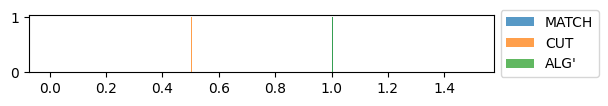

n=3: MATCH worst apx: 0.83, CUT worst apx: 0.67, ALG' worst apx: 0.83


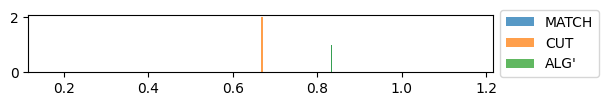

n=4: MATCH worst apx: 0.75, CUT worst apx: 0.60, ALG' worst apx: 0.75


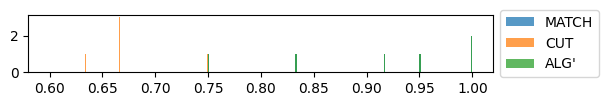

n=5: MATCH worst apx: 0.70, CUT worst apx: 0.64, ALG' worst apx: 0.75


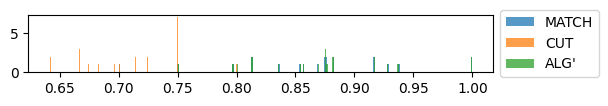

n=6: MATCH worst apx: 0.67, CUT worst apx: 0.62, ALG' worst apx: 0.75


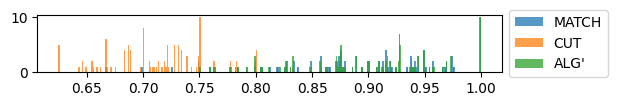

n=7: MATCH worst apx: 0.64, CUT worst apx: 0.64, ALG' worst apx: 0.76


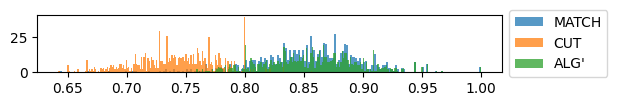

n=8: MATCH worst apx: 0.62, CUT worst apx: 0.63, ALG' worst apx: 0.76


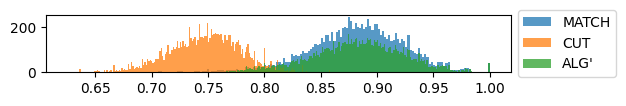

n=9: MATCH worst apx: 0.61, CUT worst apx: 0.64, ALG' worst apx: 0.75


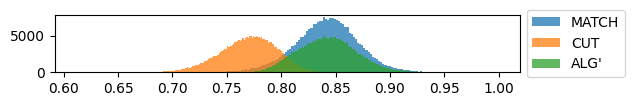

In [1304]:
for n in unique_ns:
    n_idxs = np.where(ns==n)[0]
    max_energies_n = max_qmc_energies[n_idxs]
    match_energies_n = match_energies[n_idxs]
    cut_energies_n = cut_energies[n_idxs]
    print(f"n={n}: MATCH worst apx: {np.min(match_energies_n/max_energies_n):.2f}, CUT worst apx: {np.min(cut_energies_n/max_energies_n):.2f}, ALG' worst apx: {np.min(np.maximum(match_energies_n, cut_energies_n)/max_energies_n):.2f}")
    plt.figure(figsize=(6,.75))
    plt.hist(match_energies_n/max_energies_n, bins=200, alpha=0.75, label='MATCH')
    plt.hist(cut_energies_n/max_energies_n, bins=200, alpha=0.75, label='CUT')
    plt.hist(np.maximum(match_energies_n, cut_energies_n)/max_energies_n, bins=200, alpha=0.75, label='ALG\'')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

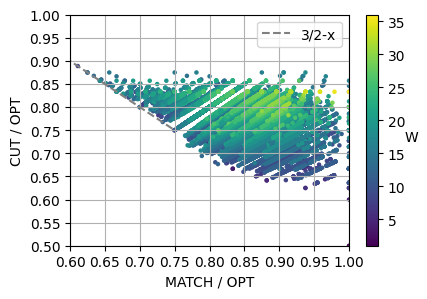

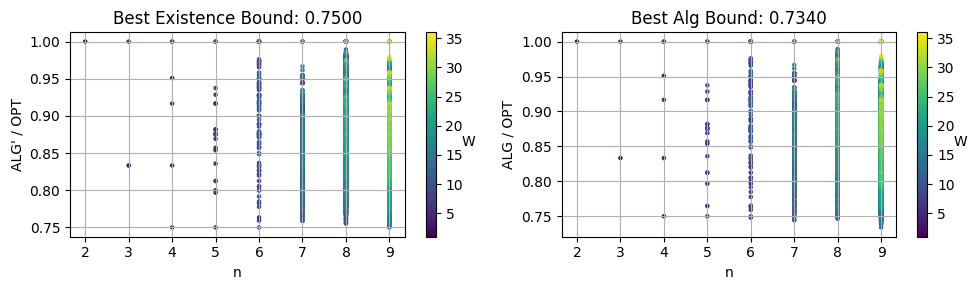

In [1305]:
plt.figure(figsize=(4.5,3))
small_x = np.linspace(.5,.75,100)
big_x = np.linspace(.75,1,100)
sc = plt.scatter(match_energies/max_qmc_energies, cut_energies/max_qmc_energies, c=total_weights, cmap='viridis', s=5)
plt.plot(small_x, 1.5-small_x, '--', color='grey', label='3/2-x')
cbar = plt.colorbar(sc)
cbar.set_label('W', rotation=0)
plt.xticks(np.arange(.6,1.05,.05))
plt.yticks(np.arange(.5,1.05,.05))
plt.ylim(.5,1)
plt.xlim(.6,1)
plt.grid()
plt.xlabel('MATCH / OPT')
plt.ylabel('CUT / OPT')
plt.legend()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

best_existence_bound = np.min(np.maximum(match_energies, cut_energies) / max_qmc_energies)
sc = axs[0].scatter(ns, np.maximum(match_energies, cut_energies) / max_qmc_energies, c=total_weights, cmap='viridis', s=5)
cbar = plt.colorbar(sc, ax=axs[0])
cbar.set_label('W', rotation=0)
axs[0].set_title(f"Best Existence Bound: {best_existence_bound:.4f}")
axs[0].set_xlabel('n')
axs[0].set_ylabel('ALG\' / OPT')
axs[0].grid()

best_alg_bound = np.min(np.maximum(match_energies, .956 * cut_energies) / max_qmc_energies)
sc = axs[1].scatter(ns, np.maximum(match_energies, .956 * cut_energies) / max_qmc_energies, c=total_weights, cmap='viridis', s=5)
cbar = plt.colorbar(sc, ax=axs[1])
cbar.set_label('W', rotation=0)
axs[1].set_title(f"Best Alg Bound: {best_alg_bound:.4f}")
axs[1].set_xlabel('n')
axs[1].set_ylabel('ALG / OPT')
axs[1].grid()

plt.tight_layout()
plt.show()

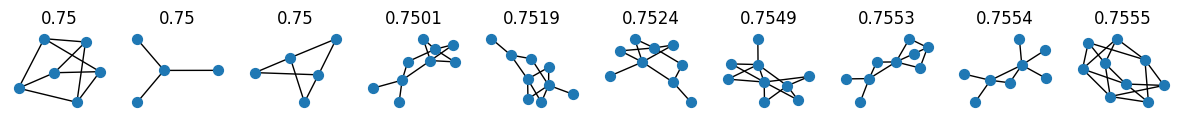

In [1318]:
# plot the worst graphs,  title = approximation ratio
keep = 10
worst_idxs = np.argsort(np.maximum(match_energies, cut_energies) / max_qmc_energies)[:keep]

plt.figure(figsize=(1.5*keep, 1))
for i, idx in enumerate(worst_idxs):  # Limit to 5 subplots
    plt.subplot(1, keep, i + 1)
    nx.draw(all_graphs[idx], node_size=50)
    plt.title(np.round(np.maximum(match_energies[idx], cut_energies[idx]) / max_qmc_energies[idx], 4))
plt.show()

All worst cases (.75 approx) are complete bipartite graphs with larger partition of size 3

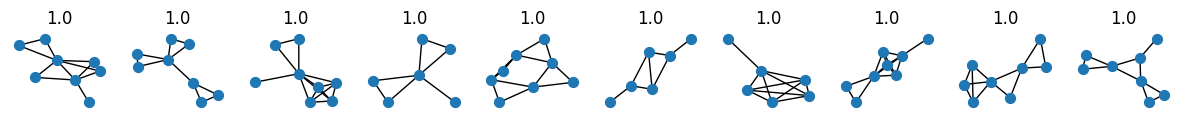

In [ ]:
# plot the best graphs,  title = approximation ratio
keep = 10
best_idxs = (np.argsort(np.maximum(match_energies, cut_energies) / max_qmc_energies)[::-1])[:keep]

plt.figure(figsize=(1.5*keep, 1))
for i, idx in enumerate(best_idxs):  # Limit to 5 subplots
    plt.subplot(1, keep, i + 1)
    nx.draw(all_graphs[idx], node_size=50)
    plt.title(np.round(np.maximum(match_energies[idx], cut_energies[idx]) / max_qmc_energies[idx], 4))
plt.show()

All best cases (1 approx) are unions of cliques

EPR

n=2: MATCH worst apx: 1.00, ZERO worst apx: 0.50, best worst apx: 1.00


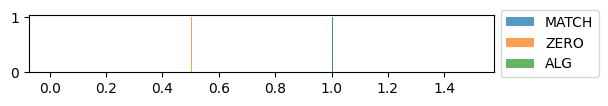

n=3: MATCH worst apx: 0.75, ZERO worst apx: 0.67, best worst apx: 0.75


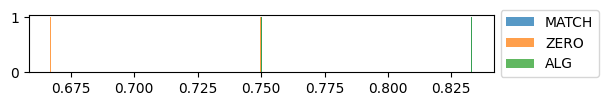

n=4: MATCH worst apx: 0.75, ZERO worst apx: 0.63, best worst apx: 0.75


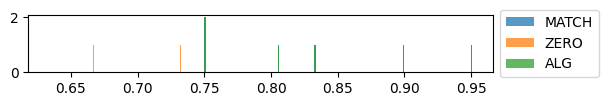

n=5: MATCH worst apx: 0.67, ZERO worst apx: 0.68, best worst apx: 0.75


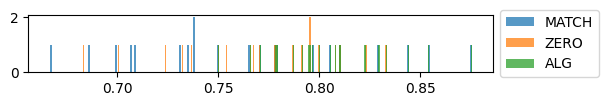

n=6: MATCH worst apx: 0.67, ZERO worst apx: 0.67, best worst apx: 0.75


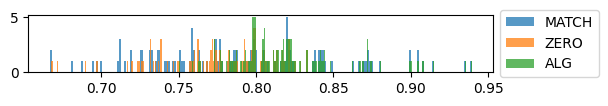

n=7: MATCH worst apx: 0.62, ZERO worst apx: 0.69, best worst apx: 0.76


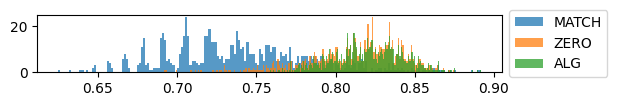

n=8: MATCH worst apx: 0.62, ZERO worst apx: 0.68, best worst apx: 0.76


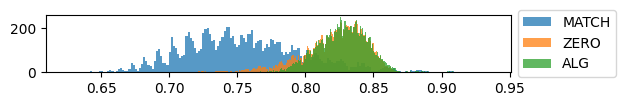

n=9: MATCH worst apx: 0.60, ZERO worst apx: 0.70, best worst apx: 0.76


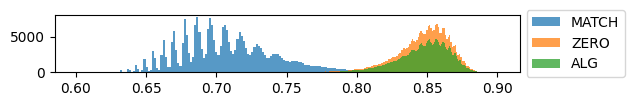

In [1306]:
for n in unique_ns:
    max_energies_n = max_epr_energies[np.where(ns==n)[0]]
    match_energies_n = match_energies[np.where(ns==n)[0]]
    zero_energies_n = total_weights[np.where(ns==n)[0]]
    print(f"n={n}: MATCH worst apx: {np.min(match_energies_n/max_energies_n):.2f}, ZERO worst apx: {np.min(zero_energies_n/max_energies_n):.2f}, best worst apx: {np.min(np.maximum(match_energies_n, zero_energies_n)/max_energies_n):.2f}")
    plt.figure(figsize=(6,.75))
    plt.hist(match_energies_n/max_energies_n, bins=200, alpha=0.75, label='MATCH')
    plt.hist(zero_energies_n/max_energies_n, bins=200, alpha=0.75, label='ZERO')
    plt.hist(np.maximum(match_energies_n, zero_energies_n)/max_energies_n, bins=200, alpha=0.75, label='ALG')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

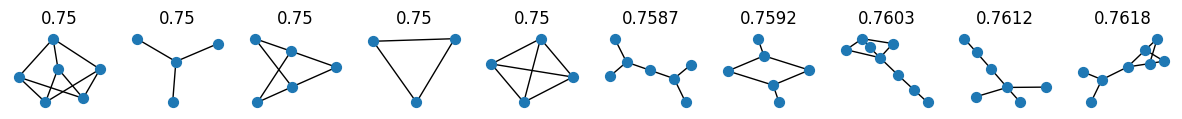

In [1323]:
# plot the worst graphs,  title = approximation ratio
keep = 10
worst_idxs = np.argsort(np.maximum(match_energies, total_weights) / max_epr_energies)[:keep]

plt.figure(figsize=(1.5*keep, 1))
for i, idx in enumerate(worst_idxs):  # Limit to 5 subplots
    plt.subplot(1, keep, i + 1)
    nx.draw(all_graphs[idx], node_size=50)
    plt.title(np.round(np.maximum(match_energies[idx], total_weights[idx]) / max_epr_energies[idx], 4))
plt.show()

All worst cases (.75 approx) are complete bipartite graphs with larger partition of size 3, or K_3 and K_4

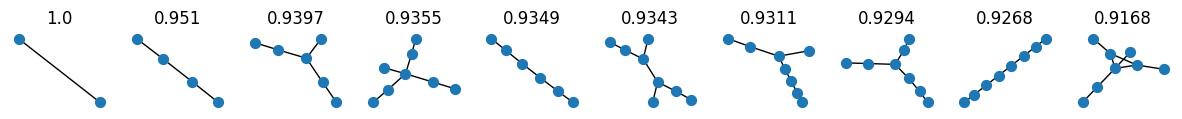

In [69]:
# plot the best graphs,  title = approximation ratio
keep = 10
best_idxs = (np.argsort(np.maximum(match_energies, total_weights) / max_epr_energies)[::-1])[:keep]

plt.figure(figsize=(1.5*keep, 1))
for i, idx in enumerate(best_idxs):  # Limit to 5 subplots
    plt.subplot(1, keep, i + 1)
    nx.draw(all_graphs[idx], node_size=50)
    plt.title(np.round(np.maximum(match_energies[idx], total_weights[idx]) / max_epr_energies[idx], 4))
plt.show()

##### Testing Conjectures and Pairwise values

Conjecture 1: OPT $\leq W+M$     (EPR and QMC)

Conjecture 2: OPT $\leq \frac{W+C}{2} + M$     (QMC)

Conjecture 3: OPT $\leq C + \frac{4M}{3}$     (QMC)

Conjecture 1 for QMC is True
Conjecture 1 for EPR is True

tight cases for conjecture 1 on QMC:


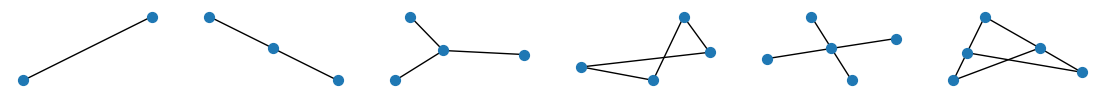

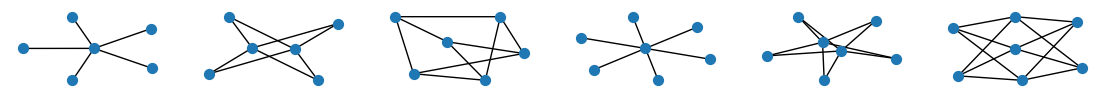

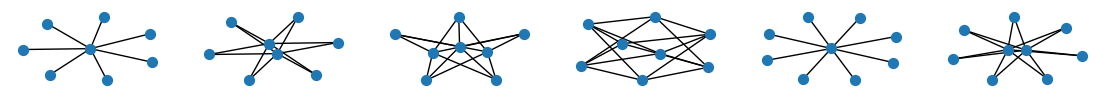

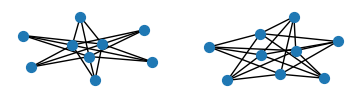

complete bipartite graphs

tight cases for conjecture 1 on EPR:


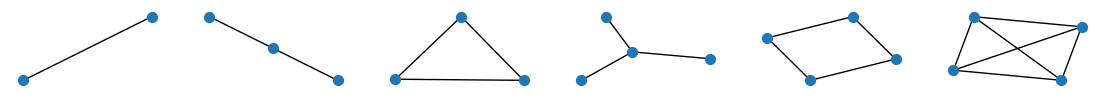

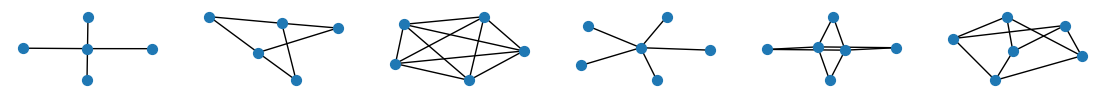

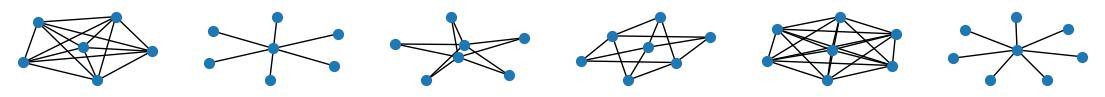

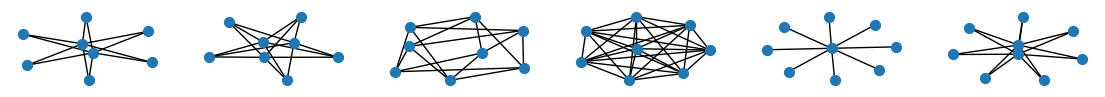

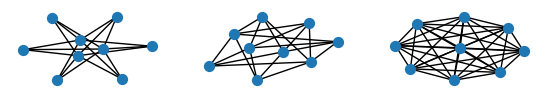

complete graphs and complete bipartite graphs


In [21]:
# test conjecture 1 and print tight cases

conj_1_true_qmc, conj_1_true_epr=True, True
for opt_qmc, opt_epr, m, G in zip(opt_qmcs, opt_eprs, ms, all_graphs):
    if opt_qmc >= m+1+TOL:
        print(opt_qmc, m)
        conj_1_true_qmc=False
    if opt_epr >= m+1+TOL:
        print(opt_qmc, m)
        conj_1_true_epr=False
print(f'Conjecture 1 for QMC is {conj_1_true_qmc}')
print(f'Conjecture 1 for EPR is {conj_1_true_epr}') 
print()

print('tight cases for conjecture 1 on QMC:')
tight_match_bound_idxs = np.where(np.abs(opt_qmcs - (1 +  ms)) < TOL)[0]
for start_idx in range(0, len(tight_match_bound_idxs), 6):
    plt.figure(figsize=(14, 1))
    for i in range(6):
        if start_idx + i < len(tight_match_bound_idxs):
            plt.subplot(1, 6, i + 1)
            G = all_graphs[tight_match_bound_idxs[start_idx + i]]
            nx.draw(G, node_size=50)
            #plt.title(f'OPT/E={np.round(opts[tight_match_bound_idxs[start_idx + i]], 3)}, (M/E+1)/2={np.round(0.5 + 0.5 * ms[tight_match_bound_idxs[start_idx + i]], 3)}')
    plt.show()
print('complete bipartite graphs')
print()
print('tight cases for conjecture 1 on EPR:')
tight_match_bound_idxs = np.where(np.abs(opt_eprs - (1 +  ms)) < TOL)[0]
for start_idx in range(0, len(tight_match_bound_idxs), 6):
    plt.figure(figsize=(14, 1))
    for i in range(6):
        if start_idx + i < len(tight_match_bound_idxs):
            plt.subplot(1, 6, i + 1)
            G = all_graphs[tight_match_bound_idxs[start_idx + i]]
            nx.draw(G, node_size=50)
            #plt.title(f'OPT/E={np.round(opts[tight_match_bound_idxs[start_idx + i]], 3)}, (M/E+1)/2={np.round(0.5 + 0.5 * ms[tight_match_bound_idxs[start_idx + i]], 3)}')
    plt.show()
print('complete graphs and complete bipartite graphs')

conjecture 3 is False, counterexample idx=117547
conjecture 2 is True
conjecture 3 is False

tight cases for conjecture 2:


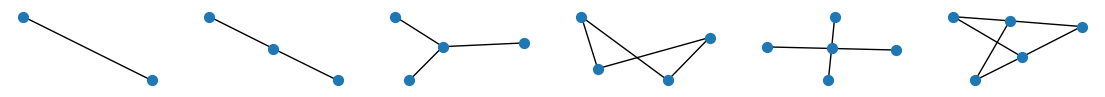

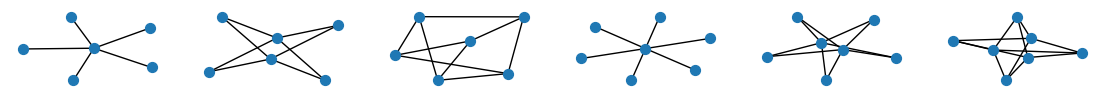

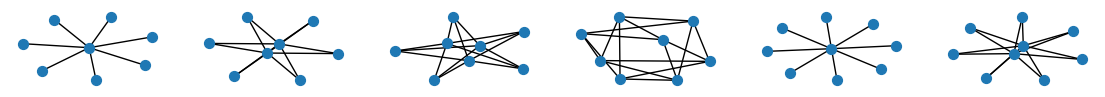

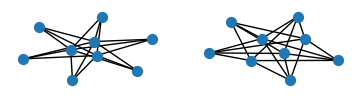

complete bipartite graphs


In [22]:
# test conjecture 2 and 3 and print tight cases

conj_2_true = True
conj_3_true = True
for idx, (opt, m, c, G) in enumerate(zip(opt_qmcs, ms, cs, all_graphs)):
    if  opt >= (c+1)/2 + m +TOL:
        conj_2_true = False
        print(idx)
        break
        
    if opt >= c + 4*m/3 + TOL:
        conj_3_true = False
        print(f'conjecture 3 is False, counterexample idx={idx}')
        break
        
print(f'conjecture 2 is {conj_2_true}')
print(f'conjecture 3 is {conj_3_true}')

print()
print("tight cases for conjecture 2:")
tight_alg_bound_idxs = np.where(np.abs(opt_qmcs - ((cs + 1)/2 + ms)) < TOL)[0]
for start_idx in range(0, len(tight_alg_bound_idxs), 6):
    plt.figure(figsize=(14, 1))
    for i in range(6):
        if start_idx + i < len(tight_alg_bound_idxs):
            plt.subplot(1, 6, i + 1)
            G = all_graphs[tight_alg_bound_idxs[start_idx + i]]
            nx.draw(G, node_size=50)
            #plt.title(f'OPT/E={np.round(opts[tight_alg_bound_idxs[start_idx + i]], 3)}, (C/E+1)/2={np.round(0.5 + 0.5 * cs[tight_alg_bound_idxs[start_idx + i]], 3)}')
    plt.show()
print('complete bipartite graphs')


In [1332]:
fail_idx = 117547
G= all_graphs[fail_idx]
max_qmc_energies[fail_idx], cuts[fail_idx]+4*matches[fail_idx]/3

(19.36223426607472, 19.333333333333332)

Test pairwise values

In particular, verify [AGM20](https://arxiv.org/pdf/2003.14394) bound on OPT:

(Eq. 18) opt $\leq 3c-1$

We also verify [GY21](https://arxiv.org/abs/2104.05536) that:

c \geq 1/2+m/2

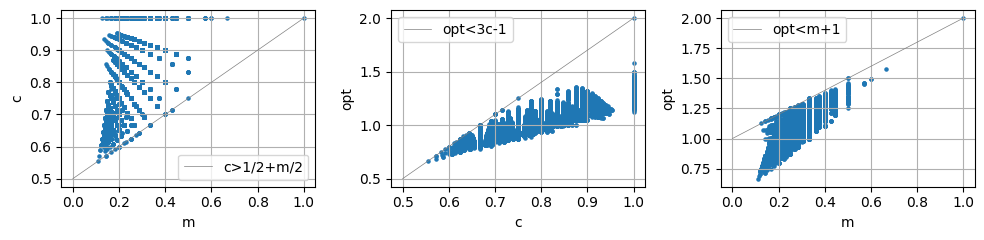

In [1336]:
xs_full = np.linspace(0,1,100)
xs_half = np.linspace(.5,1,100)

# visualize cs, ms and opts
fig, axs = plt.subplots(1, 3, figsize=(10, 2.5))

axs[0].plot(xs_full, 1/2 + xs_full / 2, label='c>1/2+m/2', linewidth=.5, color='grey')
axs[0].scatter(ms, cs, s=5)
axs[0].grid()
axs[0].set_xlabel('m')
axs[0].set_ylabel('c')
axs[0].legend()

axs[1].scatter(cs, opt_qmcs, s=5)
axs[1].plot(xs_half, (3 * xs_half - 1), label='opt<3c-1', linewidth=.5, color='grey')
axs[1].grid()
axs[1].set_xlabel('c')
axs[1].set_ylabel('opt')
axs[1].legend()

axs[2].plot(xs_full, 1 + xs_full, label='opt<m+1', linewidth=.5, color='grey')
axs[2].scatter(ms, opt_qmcs, s=5)
axs[2].grid()
axs[2].set_xlabel('m')
axs[2].set_ylabel('opt')
axs[2].legend()

plt.tight_layout()
plt.show()

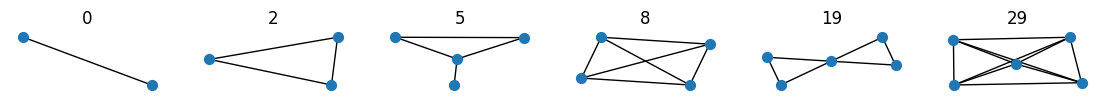

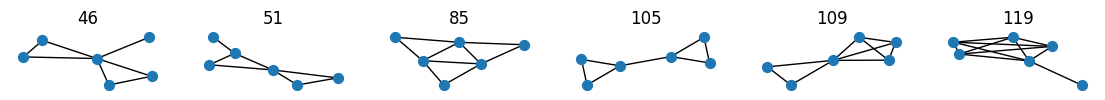

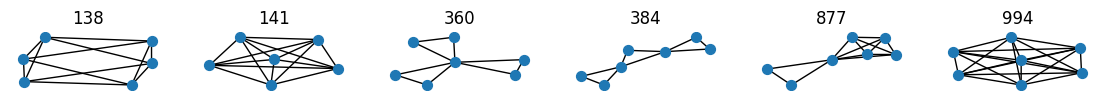

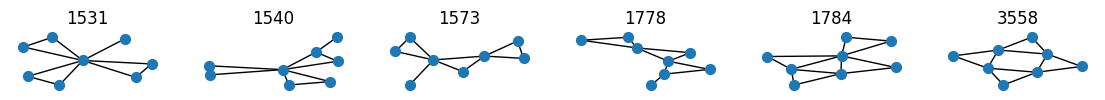

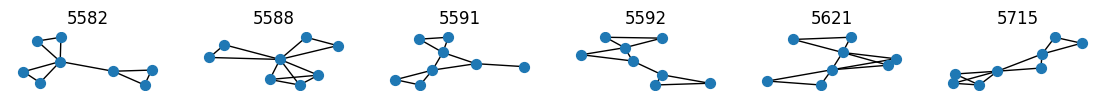

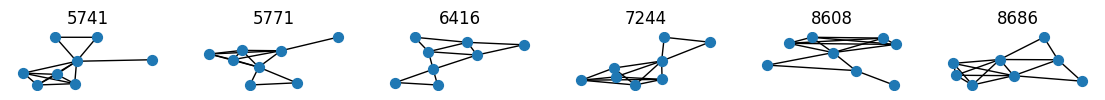

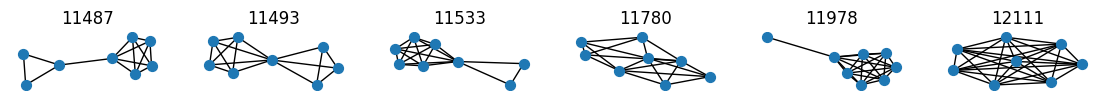

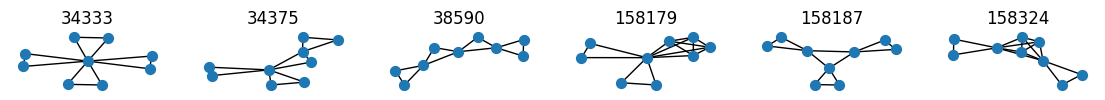

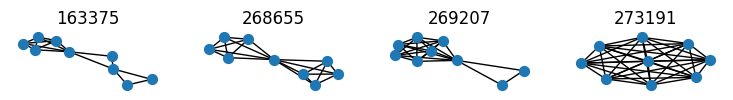

unions of edge disjoint cliques


In [24]:
#  graphs where AGM Eq 18 cut bound is tight
eps = TOL
idxs = np.where(np.abs(opt_qmcs-(3*cs-1))<eps)[0]
for start_idx in range(0, len(idxs), 6):
    plt.figure(figsize=(14, .75))
    for i in range(6):
        if start_idx + i < len(idxs):
            plt.subplot(1, 6, i + 1)
            G = all_graphs[idxs[start_idx + i]]
            nx.draw(G, node_size=50)
            plt.title(idxs[start_idx + i])
            #plt.title(f'OPT/E={np.round(opts[start_idx + i], 3)}, (3C/E-1)/2={np.round(1.5*cs[start_idx + i]-1/2, 3)}')
    plt.show()
print('unions of edge disjoint cliques')

##### Visualize opt and apx ratio vs m and c

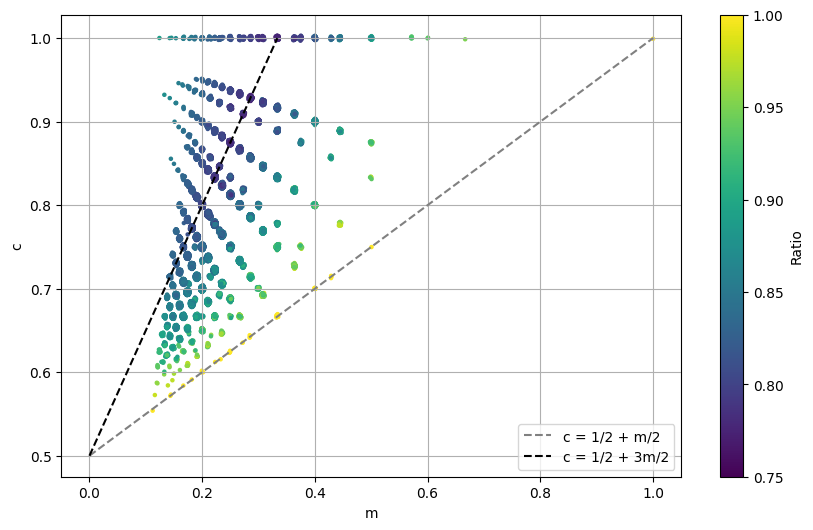

In [73]:
ratios = np.maximum(match_energies, cut_energies) / max_qmc_energies
jitter_strength = 0.001
ms_jittered = ms + np.random.normal(0, jitter_strength, size=ms.shape)
cs_jittered = cs + np.random.normal(0, jitter_strength, size=cs.shape)
plt.figure(figsize=(10, 6))
plt.scatter(ms_jittered, cs_jittered, c=ratios, s=5, cmap='viridis')
plt.colorbar(label='Ratio')
plt.plot(np.linspace(0,1,100), 0.5 + np.linspace(0,1,100) / 2, '--', color='grey', label='c = 1/2 + m/2')
plt.plot(np.linspace(0,1/3,100), 0.5 + 3*np.linspace(0,1/3,100) / 2, '--', color='black', label='c = 1/2 + 3m/2')
plt.grid()
plt.xlabel('m')
plt.ylabel('c')
plt.legend()
plt.show()

In [138]:
def quadratic_bound(alpha, m, c):
    return (c*(-3-6*m**2*alpha+m*(3+2*alpha)) + m*(-3-alpha+3*m**2*alpha+m*(3+2*alpha))) / (3*(m-1))

def quadratic_bound_2(alpha, beta, m, c):
    return (1 / (6 * (m - 1))) * (
        6 * m**3 * alpha 
        - 2 * m * (3 + alpha) 
        - 3 * beta 
        + 6 * c**2 * (m - 1) * beta 
        + m**2 * (6 + 4 * alpha + 3 * beta) 
        + c * (-6 + m * (6 + 4 * alpha - 6 * beta) + 9 * beta - 3 * m**2 * (4 * alpha + beta))
    )

def cost_fn(xs):
    alpha, beta = xs
    return np.sum((quadratic_bound_2(alpha, beta, ms[1:], cs[1:]) < opt_qmcs[1:]))

minimize(cost_fn, np.random.random(2)-np.random.random(2), method='cobyla')

# no quadratic bounds are valid!!!

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 20.0
       x: [-1.827e-01 -4.659e+00]
    nfev: 36
   maxcv: 0.0

In [182]:
fractions = set()
for numerator in range(1, 5):
    for denominator in range(1, 5):
        fractions.add(numerator / denominator)

fractions = [frac for frac in sorted(fractions) if frac <=3]
try_vars = [-frac for frac in fractions] + [0] + fractions

In [185]:
def test_b1_bound(B):
    return np.all(opt_qmcs <= (5-3*B)*ms/2 + B*cs +(1-B)/2 + TOL)
def test_b2_bound(B):
    return np.all(opt_qmcs <= (4-3*B)*ms/2 + B*cs + 2/3-B/2+ TOL)

for var in try_vars:
    if test_b1_bound(var): 
        print(f'test_b1_bound true, var={var}')
    if test_b2_bound(var):
        print(f'test b2 bound true, var={var}')

#####  Try various unconditional bounds of  opt <= a0 + am m + ac c for QMC, see which combinations can get to good approx ratios

In [130]:
def determine_coeffs_valid(a0, ac, am, tol=TOL):
    valid = np.all(opt_qmcs <= a0 + ac * cs + am * ms + tol)
    return valid 

def determine_coeffs_optimal(a0, ac, am, tol=TOL):
    minimum = not np.all(opt_qmcs <= (a0-tol) + ac * cs + am * ms)
    minimum = minimum and not np.all(opt_qmcs <= a0 + (ac-tol) * cs + am * ms)
    minimum = minimum and not np.all(opt_qmcs <= a0 + ac * cs + (am-tol) * ms)
    return determine_coeffs_valid(a0, ac, am, tol=TOL) and minimum

fractions = set()
for numerator in range(1, 4):
    for denominator in range(1, 4):
        fractions.add(numerator / denominator)

fractions = [frac for frac in sorted(fractions) if frac <=3]
#try_vars = np.array([-9/2,-4,-7/2,-3, -5/2,-2, -5/3, -3/2, -4/3, -1, -7/8, -3/4, -2/3, -5/8,-1/2, -1/3, -3/8, -1/4, -1/8, 0, 1/8,  1/4,3/8, 1/3, 1/2,5/8, 2/3, 3/4,7/8, 1, 4/3, 3/2, 5/3, 2, 5/2, 3, 7/2, 4,9/2 ])
#try_vars = np.array([-3/2,-1,-3/4,-1/2,-1/4,0,1/4,1/2,3/4,1,3/2])
#try_vars = np.array([-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12])/8
#try_vars = np.linspace(-1,2,250)
try_vars = [-frac for frac in fractions] + [0] + fractions
a0s, acs, ams = np.meshgrid(try_vars, try_vars, try_vars)
valids = np.vectorize(determine_coeffs_optimal)(a0s, acs, ams,tol=1e-3)

KeyboardInterrupt: 

In [33]:
approxs = []
bound_coeffs = []
for opt, m, c in tqdm(zip(opt_qmcs, ms, cs)):
    best_bound_idx = None
    smallest_bound = np.inf
    idx = 0
    for a0, ac, am in zip(a0s[valids], acs[valids], ams[valids]): 
        bound = a0 + ac*c + am*m
        if bound <= smallest_bound-TOL:
            best_bound_idx = idx
            smallest_bound=bound
        idx+=1
    best_alg = max((3*m+1)/2, c)
    if (a0s[valids][best_bound_idx], acs[valids][best_bound_idx], ams[valids][best_bound_idx]) not in bound_coeffs:
        bound_coeffs.append((a0s[valids][best_bound_idx], acs[valids][best_bound_idx], ams[valids][best_bound_idx]))
    if best_alg / smallest_bound <= .75-TOL:
        approxs.append(best_alg / smallest_bound)

print(f'approx ratio: {min(approxs)} from the bounds {bound_coeffs}')

0it [00:00, ?it/s]

273192it [00:53, 5129.07it/s]

approx ratio: 0.7272727272727273 from the bounds [(2.0, -0.3333333333333333, 0.3333333333333333), (1.5, -0.5, 1.0), (-1.0, 3.0, 0.0), (0.5, 0.5, 1.0), (-0.5, 2.0, 0.6666666666666666), (0.0, 1.0, 1.5), (-0.3333333333333333, 1.5, 1.5)]


In [45]:
two_subset_approxs=[]
for subset in combinations(bound_coeffs, 2):
    subset_approxs=[]
    for opt, m, c in zip(opt_qmcs, ms, cs):
        best_bound_idx = None
        smallest_bound = np.inf
        for a0, ac, am in subset:
            bound = a0 + ac*c + am*m
            if bound <= smallest_bound-TOL:
                best_bound_idx = bound
                smallest_bound=bound
        best_alg = max((3*m+1)/2, c)
        subset_approxs.append(best_alg / smallest_bound)
    two_subset_approxs.append(min(subset_approxs))
print([np.round(two_subset_approx,4) for two_subset_approx in two_subset_approxs])

[0.5, 0.52, 0.7143, 0.5806, 0.6667, 0.6, 0.5909, 0.7143, 0.6383, 0.6897, 0.66, 0.7143, 0.5806, 0.6667, 0.6, 0.7143, 0.7273, 0.72, 0.6667, 0.6, 0.6667]


In [35]:
# loop over all subsets of bound_coeffs to find the smallest subset with the same approx_ratio
best_subsets = []
best_subset_size=len(bound_coeffs)
best_subset_approx=np.inf
found_subset=False

for subset in tqdm(powerset(bound_coeffs)):
    subset_size = len(subset)
    if subset_size == 0:
        continue
    if found_subset and subset_size > best_subset_size:
        break
    
    subset_approxs = []
    for opt, m, c in zip(opt_qmcs, ms, cs):
        best_bound_idx = None
        smallest_bound = np.inf
        for a0, ac, am in subset:
            bound = a0 + ac*c + am*m
            if bound <= smallest_bound-TOL:
                best_bound_idx = bound
                smallest_bound=bound
        best_alg = max((3*m+1)/2, c)
        subset_approxs.append(best_alg / smallest_bound)

    if min(subset_approxs)>=min(approxs)-TOL:
        best_subset_size=subset_size
        best_subset_approx=min(subset_approxs)
        best_subsets.append(subset)
        found_subset=True
best_subset_approx, best_subsets

29it [00:36,  1.26s/it]


(0.7272727272727273, [((0.5, 0.5, 1.0), (0.0, 1.0, 1.5))])

In [ ]:
# refuting bounds for sizes up to 8
print(determine_coeffs_valid(1/2, 1/2, 1))
print(determine_coeffs_valid(0, 1, 4/3))
print(determine_coeffs_valid(2/5, 3/5, 1))
print(determine_coeffs_valid(1/7, 4/5, 7/5))
print(determine_coeffs_valid(2/5, 3/5, 1))
print(determine_coeffs_valid(1/10, 9/10, 6/5))

True
False
False
False
False
False


##### Paths and Cycles

In [304]:
for idx, n in enumerate(PATH_AND_CYCLE_NS):
    if n % 2 == 0:
        print(f"{n} node path OPT={max_path_energies[idx]:.4f}, cycle OPT={max_cycle_energies[idx]:.4f}")
    else:
        print(f"{n} node path OPT={max_path_energies[idx]:.4f}, QMC cycle OPT={max_cycle_energies[idx]:.4f}, EPR cycle OPT={max_odd_cycle_epr_energies[np.where(ODD_CYCLE_NS==n)[0][0]]:.4f}")

2 node path OPT=2.0000, cycle OPT=2.0000
3 node path OPT=3.0000, QMC cycle OPT=3.0000, EPR cycle OPT=4.0000
4 node path OPT=4.7321, cycle OPT=6.0000
5 node path OPT=5.8558, QMC cycle OPT=6.2361, EPR cycle OPT=6.8284
6 node path OPT=7.4872, cycle OPT=8.6056
7 node path OPT=8.6725, QMC cycle OPT=9.2104, EPR cycle OPT=9.6272
8 node path OPT=10.2499, cycle OPT=11.3022
9 node path OPT=11.4726, QMC cycle OPT=12.0946, EPR cycle OPT=12.4152
10 node path OPT=13.0161, cycle OPT=14.0309
11 node path OPT=14.2642, QMC cycle OPT=14.9379, EPR cycle OPT=15.1979
12 node path OPT=15.7842, cycle OPT=16.7748
13 node path OPT=17.0506, QMC cycle OPT=17.7592, EPR cycle OPT=17.9777


In [305]:
# visualize state for small N
SMALL_NS = [2,3,4,5,6]
for n in SMALL_NS:
    print(f'{n} node path:')
    G = nx.path_graph(n)
    add_weights(G, 'unweighted')
    H = generate_H_QMC(G)
    eigvals, eigvecs = np.linalg.eigh(H)
    max_eigval_idxs = np.where(np.abs(eigvals-max(eigvals))<TOL)[0]
    for idx in max_eigval_idxs:
        print(get_statevector_as_braket(eigvecs[:,idx], n))
    print()

2 node path:
['-0.7071|01>', '+0.7071|10>']

3 node path:
['+0.4082|001>', '-0.8165|010>', '+0.4082|100>']
['+0.4082|011>', '-0.8165|101>', '+0.4082|110>']

4 node path:
['+0.1494|0011>', '-0.5577|0101>', '+0.4082|0110>', '+0.4082|1001>', '-0.5577|1010>', '+0.1494|1100>']

5 node path:
['+0.0480|00111>', '-0.2330|01011>', '+0.3844|01101>', '-0.1994|01110>', '+0.2330|10011>', '-0.6655|10101>', '+0.3844|10110>', '+0.2330|11001>', '-0.2330|11010>', '+0.0480|11100>']
['+0.0480|00011>', '-0.2330|00101>', '+0.2330|00110>', '+0.3844|01001>', '-0.6655|01010>', '+0.2330|01100>', '-0.1994|10001>', '+0.3844|10010>', '-0.2330|10100>', '+0.0480|11000>']

6 node path:
['-0.0094|000111>', '+0.0607|001011>', '-0.1316|001101>', '+0.0802|001110>', '-0.1316|010011>', '+0.4494|010101>', '-0.3085|010110>', '-0.2376|011001>', '+0.3085|011010>', '-0.0802|011100>', '+0.0802|100011>', '-0.3085|100101>', '+0.2376|100110>', '+0.3085|101001>', '-0.4494|101010>', '+0.1316|101100>', '-0.0802|110001>', '+0.1316|1100

In [18]:
# visualize state for small N
SMALL_NS = [2,4,6,8,10,12]
for n in SMALL_NS:
    print(f'{n} node path:')
    G = nx.path_graph(n)
    add_weights(G, 'unweighted')
    H = generate_H_QMC(G)
    print(f'n={n}, spectral gap = {get_spectral_gap(H)}')

2 node path:
n=2, spectral gap = 2.0
4 node path:
n=4, spectral gap = 1.3178372499999997
6 node path:
n=6, spectral gap = 0.9831635599999995
8 node path:
n=8, spectral gap = 0.785384220000001
10 node path:
n=10, spectral gap = 0.6547232300000001
12 node path:
n=12, spectral gap = 0.5618853999999995


In [306]:
SMALL_NS = [2,3,4,5,6]
for n in SMALL_NS:  
    print(f'{n} node cycle:')
    G = nx.cycle_graph(n)
    add_weights(G, 'unweighted')
    H = generate_H_QMC(G)
    eigvals, eigvecs = np.linalg.eigh(H)
    max_eigval_idxs = np.where(np.abs(eigvals-max(eigvals))<TOL)[0]
    for idx in max_eigval_idxs:
        print(get_statevector_as_braket(eigvecs[:,idx], n))
    print()

2 node cycle:
['-0.7071|01>', '+0.7071|10>']

3 node cycle:
['-0.8059|011>', '+0.5164|101>', '+0.2895|110>']
['+0.1310|011>', '+0.6325|101>', '-0.7634|110>']
['+0.1310|001>', '+0.6325|010>', '-0.7634|100>']
['-0.8059|001>', '+0.5164|010>', '+0.2895|100>']

4 node cycle:
['+0.2887|0011>', '-0.5774|0101>', '+0.2887|0110>', '+0.2887|1001>', '-0.5774|1010>', '+0.2887|1100>']

5 node cycle:
['-0.0001|00011>', '+0.0028|00101>', '-0.0016|00110>', '+0.1600|00111>', '-0.0043|01001>', '+0.0042|01010>', '-0.5838|01011>', '-0.0009|01100>', '+0.5257|01101>', '-0.1019|01110>', '+0.0016|10001>', '-0.0024|10010>', '+0.2008|10011>', '-0.0002|10100>', '-0.2668|10101>', '-0.0940|10110>', '+0.0011|11000>', '-0.0359|11001>', '+0.4189|11010>', '-0.2230|11100>']
['+0.2255|00011>', '-0.4626|00101>', '+0.0604|00110>', '+0.1582|01001>', '+0.2066|01010>', '-0.1881|01100>', '+0.0789|10001>', '-0.4925|10010>', '+0.5903|10100>', '-0.1767|11000>']
['-0.0001|00011>', '+0.0042|00101>', '-0.0025|00110>', '+0.1591|00111

In [28]:
SMALL_NS = [3,5]
for n in SMALL_NS:  
    print(f'{n} node cycle:')
    G = nx.cycle_graph(n)
    add_weights(G, 'unweighted')
    H = generate_H_EPR(G)
    eigvals, eigvecs = np.linalg.eigh(H)
    max_eigval_idxs = np.where(np.abs(eigvals-max(eigvals))<TOL)[0]
    print(max(eigvals))
    for idx in max_eigval_idxs:
        print(get_statevector_as_braket(eigvecs[:,idx], n))
    print()

3 node cycle:
4.0
['+0.2887|001>', '+0.2887|010>', '+0.2887|100>', '+0.8660|111>']
['+0.8660|000>', '+0.2887|011>', '+0.2887|101>', '+0.2887|110>']

5 node cycle:
6.828427124746195
['-0.7304|00000>', '-0.2671|00011>', '-0.0251|00101>', '-0.2671|00110>', '-0.0251|01001>', '-0.0251|01010>', '-0.2671|01100>', '-0.1461|01111>', '-0.2671|10001>', '-0.0251|10010>', '-0.0251|10100>', '-0.1461|10111>', '-0.2671|11000>', '-0.1461|11011>', '-0.1461|11101>', '-0.1461|11110>']
['+0.1461|00001>', '+0.1461|00010>', '+0.1461|00100>', '+0.2671|00111>', '+0.1461|01000>', '+0.0251|01011>', '+0.0251|01101>', '+0.2671|01110>', '+0.1461|10000>', '+0.2671|10011>', '+0.0251|10101>', '+0.0251|10110>', '+0.2671|11001>', '+0.0251|11010>', '+0.2671|11100>', '+0.7304|11111>']



2


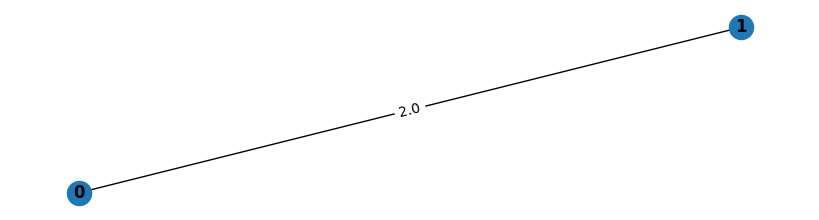

2.0
4


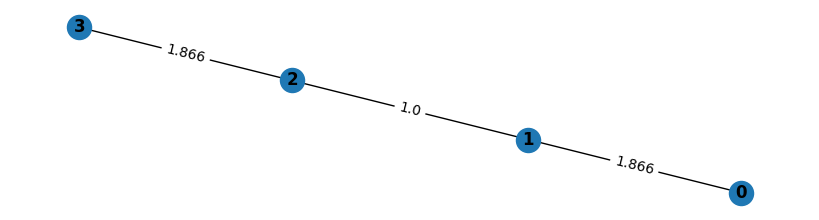

4.732
6


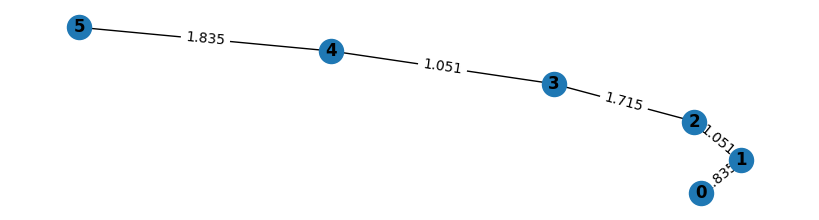

7.487
8


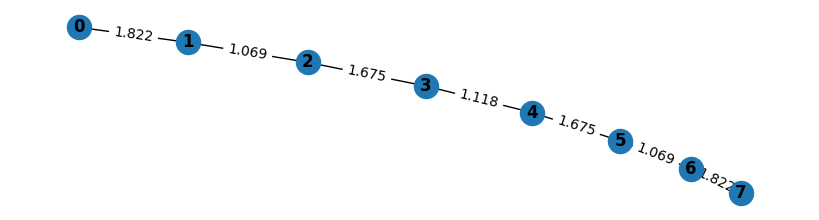

10.25
10


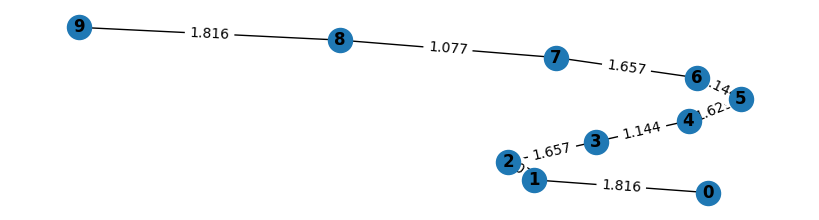

13.017000000000001


In [269]:
even_n_paths = [2,4,6,8,10]
for n in even_n_paths:
    print(n)
    G = nx.path_graph(n)
    add_weights(G, 'unweighted')
    H = generate_H_QMC(G)
    eigvals, eigvecs = np.linalg.eigh(H)
    max_eigval_idxs = np.where(np.abs(eigvals-max(eigvals))<TOL)[0]
    for idx in max_eigval_idxs:
        plot_eigvec_energy_on_edges(G, eigvecs[:,idx], ham_type='QMC', e_scale='g')

##### Testing adding edges to bipartite graphs

In [16]:
def generate_random_bipartite_graph(A, B, p, trials =10000):
    # Create a bipartite graph
    for trial in range(trials):
        G = nx.Graph()

        G.add_nodes_from(range(A))
        G.add_nodes_from(range(A, A + B))

        # Add edges with probability p
        for u in range(A):
            for v in range(A, A + B):
                if np.random.rand() < p:
                    G.add_edge(u, v)
        if nx.is_connected(G):
            return G

    raise AssertionError("Could not generate a connected graph")

In [52]:
G = nx.erdos_renyi_graph(9, .75)
for trial in tqdm(range(100)):
    if nx.is_connected:
        add_weights(G, 'unweighted')
        H_QMC, H_EPR = generate_H_QMC(G), generate_H_EPR(G)
        match_old = get_maximum_matching(G)
        qmc_old, epr_old = get_maximum_eigval(H_QMC), get_maximum_eigval(H_EPR)
        G.add_edges_from([(0,1)])
        add_weights(G, 'unweighted')
        if get_maximum_matching(G)-match_old >= 1 + TOL:
            if get_maximum_eigval(generate_H_QMC(G))-qmc_old >= 1 + TOL and get_maximum_eigval(generate_H_EPR(G))-epr_old >= 1 + TOL:
                print('failed')

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:06<00:00,  1.27s/it]


In [258]:
def glue_graphs_along_edge(A, B, i, j):
    """
    Glues two graphs A and B along the edge (i, j).
    
    Parameters:
    A (networkx.Graph): The first graph.
    B (networkx.Graph): The second graph.
    i (int): The node in graph A to be glued.
    j (int): The node in graph B to be glued.
    
    Returns:
    networkx.Graph: The resulting graph after gluing.
    """
    # Create a new graph that is the union of A and B
    G = nx.disjoint_union(A, B)
    
    # Get the number of nodes in graph A
    nA = A.number_of_nodes()
    
    # Add an edge between node i in A and node j in B
    G.add_edge(i, nA + j)
    
    return G


A= nx.random_regular_graph(3,6)
B = nx.random_regular_graph(3,6)
G = glue_graphs_along_edge(A,B,1,2)
plt.figure(figsize=(4,2))
nx.draw(A)
plt.show()
plt.figure(figsize=(4,2))
nx.draw(B)
plt.show()

nx.draw(G)
plt.show()

In [195]:
trials = 1
AB_pairs = [(2,1),(3,1),(3,2),(4,1),(4,2),(4,3),(5,1),(5,2),(5,3),(5,4)]

for A, B in AB_pairs:
    increase_max_qmc, increase_max_epr = [],[]
    bipartite_edges = [(u, v) for u in range(A) for v in range(A, A + B)]
    non_bipartite_edges = [(u, v) for u in range(A) for v in range(u)]+[(u, v) for u in range(A,A+B) for v in range(A,u)]

    for trial in range(trials):
        G=generate_random_bipartite_graph(A,B,1)
        add_weights(G, 'unweighted')
        H_QMC, H_EPR = generate_H_QMC(G), generate_H_EPR(G)
        old_max_QMC, old_max_EPR = get_maximum_eigval(H_QMC), get_maximum_eigval(H_EPR)
        old_cut = get_maximum_cut(G)
        for edge in non_bipartite_edges:
            G.add_edge(*edge)
            add_weights(G, 'unweighted')
            if get_maximum_cut(G) <= old_cut+TOL:
                H_QMC, H_EPR = generate_H_QMC(G), generate_H_EPR(G)
                max_QMC, max_EPR = get_maximum_eigval(H_QMC), get_maximum_eigval(H_EPR)
                increase_max_qmc.append(max_QMC-old_max_QMC) 
                increase_max_epr.append(max_EPR-old_max_EPR)
                old_max_QMC, old_max_EPR = max_QMC, max_EPR
    print(f'A={A}, B={B}: max increase QMC {max(increase_max_qmc):.2f}, max increase EPR {max(increase_max_epr):.2f}')

A=2, B=1: max increase QMC 0.00, max increase EPR 1.00
A=3, B=1: max increase QMC 1.00, max increase EPR 1.56
A=3, B=2: max increase QMC 0.00, max increase EPR 1.06
A=4, B=1: max increase QMC 1.00, max increase EPR 1.52
A=4, B=2: max increase QMC 1.00, max increase EPR 1.33
A=4, B=3: max increase QMC 0.00, max increase EPR 1.07
A=5, B=1: max increase QMC 1.00, max increase EPR 1.52
A=5, B=2: max increase QMC 1.00, max increase EPR 1.28
A=5, B=3: max increase QMC 1.00, max increase EPR 1.19
A=5, B=4: max increase QMC 0.00, max increase EPR 1.07


In [248]:
trials = 100
AB_pairs = [(2,1),(2,2),(3,1),(3,2),(3,3),(4,1),(4,2),(4,3),(4,4),(5,1),(5,2),(5,3),(5,4)]

for A, B in AB_pairs:
    increase_max_qmc, increase_max_epr = [],[]
    bipartite_edges = [(u, v) for u in range(A) for v in range(A, A + B)]
    non_bipartite_edges = [(u, v) for u in range(A) for v in range(u)]+[(u, v) for u in range(A,A+B) for v in range(A,u)]

    for trial in range(trials):
        G=generate_random_bipartite_graph(A,B,.5)
        add_weights(G, 'unweighted')
        H_QMC, H_EPR = generate_H_QMC(G), generate_H_EPR(G)
        old_max_QMC, old_max_EPR = get_maximum_eigval(H_QMC), get_maximum_eigval(H_EPR)
        old_cut = get_maximum_cut(G)
        for edge in non_bipartite_edges:
            G.add_edge(*edge)
            add_weights(G, 'unweighted')
            if get_maximum_cut(G) <= old_cut+TOL:
                H_QMC, H_EPR = generate_H_QMC(G), generate_H_EPR(G)
                max_QMC, max_EPR = get_maximum_eigval(H_QMC), get_maximum_eigval(H_EPR)
                increase_max_qmc.append(max_QMC-old_max_QMC) 
                increase_max_epr.append(max_EPR-old_max_EPR)
                old_max_QMC, old_max_EPR = max_QMC, max_EPR
    print(f'A={A}, B={B}: max increase QMC {max(increase_max_qmc):.2f}, max increase EPR {max(increase_max_epr):.2f}')

A=2, B=1: max increase QMC 0.00, max increase EPR 1.00
A=2, B=2: max increase QMC 0.27, max increase EPR 1.17
A=3, B=1: max increase QMC 1.00, max increase EPR 1.56
A=3, B=2: max increase QMC 0.53, max increase EPR 1.08
A=3, B=3: max increase QMC 0.55, max increase EPR 1.22
A=4, B=1: max increase QMC 1.00, max increase EPR 1.52
A=4, B=2: max increase QMC 1.26, max increase EPR 1.64
A=4, B=3: max increase QMC 0.80, max increase EPR 1.22
A=4, B=4: max increase QMC 0.64, max increase EPR 1.17
A=5, B=1: max increase QMC 1.00, max increase EPR 1.52
A=5, B=2: max increase QMC 1.26, max increase EPR 1.52
A=5, B=3: max increase QMC 1.36, max increase EPR 1.65
A=5, B=4: max increase QMC 0.80, max increase EPR 1.13


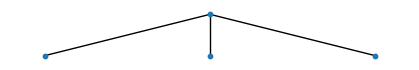

maxcut:3.0, qmc 4.0000, epr 4.0000


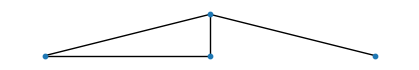

maxcut:3.0, increase qmc 1.0000, increase epr 1.5616


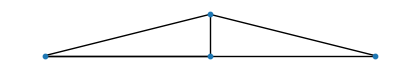

maxcut:4.0, increase qmc 1.0000, increase epr 1.2669


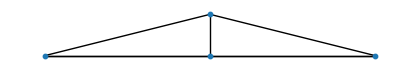

maxcut:4.0, increase qmc 0.0000, increase epr 1.1716


In [243]:
A, B = 3,1
bipartite_edges = [(u, v) for u in range(A) for v in range(A, A + B)]
non_bipartite_edges = [(u, v) for u in range(A) for v in range(u)]+[(u, v) for u in range(A,A+B) for v in range(A,u)]
pos = {0: (0, 0), 1: (1, 0), 2: (2, 0), 3:(1,1)}
G = generate_random_bipartite_graph(A,B,.5)
plt.figure(figsize=(4,.5))
nx.draw(G, node_size=10, pos=pos)
plt.show()
add_weights(G, 'unweighted')
H_QMC, H_EPR = generate_H_QMC(G), generate_H_EPR(G)
old_max_QMC, old_max_EPR = get_maximum_eigval(H_QMC), get_maximum_eigval(H_EPR)
print(f'maxcut:{get_maximum_cut(G)}, qmc {old_max_QMC:.4f}, epr {old_max_EPR:.4f}')
old_cut = get_maximum_cut(G)
for edge in non_bipartite_edges:
    G.add_edge(*edge)
    plt.figure(figsize=(4,.5))
    nx.draw(G, node_size=10, pos=pos)
    plt.show()
    add_weights(G, 'unweighted')
    H_QMC, H_EPR = generate_H_QMC(G), generate_H_EPR(G)
    max_QMC, max_EPR = get_maximum_eigval(H_QMC), get_maximum_eigval(H_EPR)
    increase_max_qmc.append(max_QMC-old_max_QMC) 
    increase_max_epr.append(max_EPR-old_max_EPR)
    print(f'maxcut:{get_maximum_cut(G)}, increase qmc {max_QMC-old_max_QMC:.4f}, increase epr {max_EPR-old_max_EPR:.4f}')
    old_max_QMC, old_max_EPR = max_QMC, max_EPR

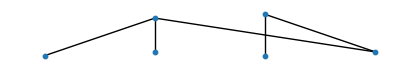

maxcut:5.0, qmc 6.8753, epr 6.8753


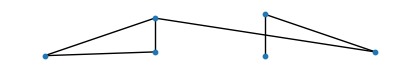

maxcut:5.0, increase qmc 0.8568, increase epr 1.4638


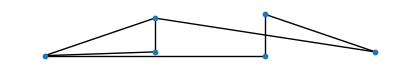

maxcut:6.0, increase qmc 1.0000, increase epr 1.0900


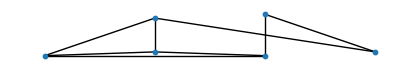

maxcut:6.0, increase qmc 0.4302, increase epr 1.0984


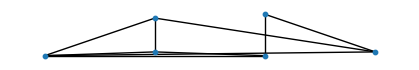

maxcut:7.0, increase qmc 1.0738, increase epr 1.0566


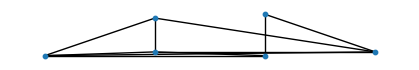

maxcut:8.0, increase qmc 0.6590, increase epr 1.0636


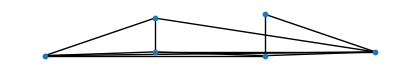

maxcut:8.0, increase qmc 0.0081, increase epr 0.9120


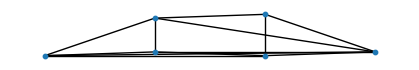

maxcut:9.0, increase qmc 1.0968, increase epr 1.2010


In [234]:
A, B = 4,2
bipartite_edges = [(u, v) for u in range(A) for v in range(A, A + B)]
non_bipartite_edges = [(u, v) for u in range(A) for v in range(u)]+[(u, v) for u in range(A,A+B) for v in range(A,u)]
pos = {0: (0, 0), 1: (1, .1), 2: (2,0), 3: (3, .1), 4: (1, 1), 5: (2,1.1)}
G = generate_random_bipartite_graph(A,B,.5)
plt.figure(figsize=(4,.5))
nx.draw(G, node_size=10, pos=pos)
plt.show()
add_weights(G, 'unweighted')
H_QMC, H_EPR = generate_H_QMC(G), generate_H_EPR(G)
old_max_QMC, old_max_EPR = get_maximum_eigval(H_QMC), get_maximum_eigval(H_EPR)
print(f'maxcut:{get_maximum_cut(G)}, qmc {old_max_QMC:.4f}, epr {old_max_EPR:.4f}')
old_cut = get_maximum_cut(G)
for edge in non_bipartite_edges:
    G.add_edge(*edge)
    plt.figure(figsize=(4,.5))
    nx.draw(G, node_size=10, pos=pos)
    plt.show()
    add_weights(G, 'unweighted')
    H_QMC, H_EPR = generate_H_QMC(G), generate_H_EPR(G)
    max_QMC, max_EPR = get_maximum_eigval(H_QMC), get_maximum_eigval(H_EPR)
    increase_max_qmc.append(max_QMC-old_max_QMC) 
    increase_max_epr.append(max_EPR-old_max_EPR)
    print(f'maxcut:{get_maximum_cut(G)}, increase qmc {max_QMC-old_max_QMC:.4f}, increase epr {max_EPR-old_max_EPR:.4f}')
    old_max_QMC, old_max_EPR = max_QMC, max_EPR

##### Test OPT QMC <= OPT EPR + (C-W)/2

In [186]:
invalid_idxs = np.where(total_weights*opt_qmcs > total_weights*opt_eprs+(cuts-total_weights)/2+TOL)

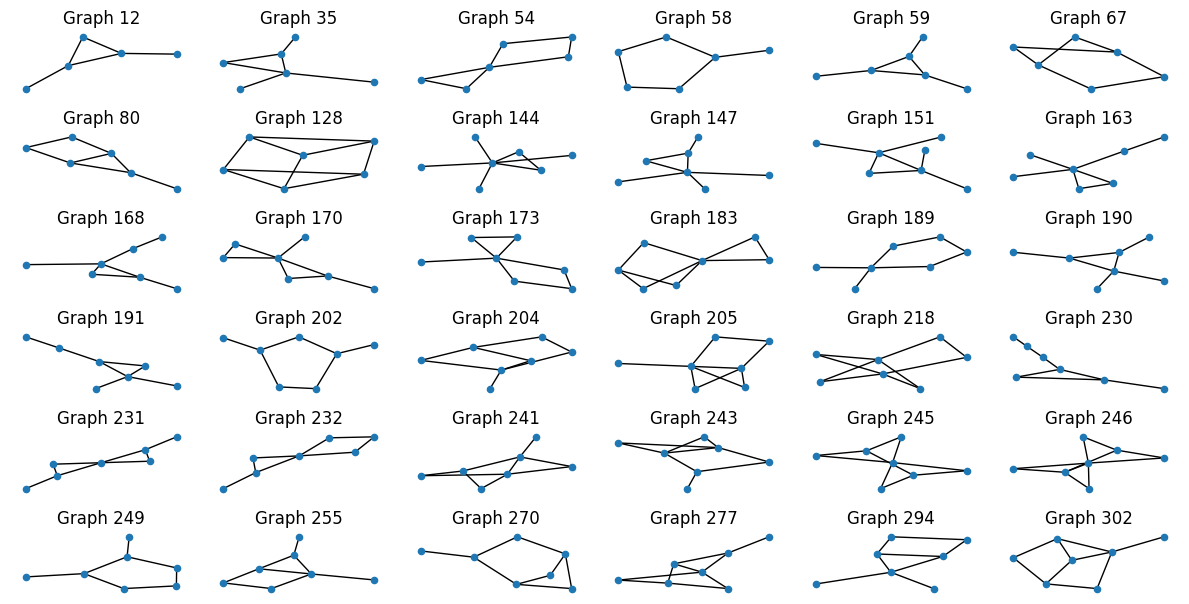

In [187]:
graphs_per_row=6
invalid_graphs = [all_graphs[i] for i in invalid_idxs[0]]
num_invalid_graphs = len(invalid_graphs)
num_rows_invalid = (num_invalid_graphs + graphs_per_row - 1) // graphs_per_row

plt.figure(figsize=(12, num_rows_invalid * 1))

for i, G in enumerate(invalid_graphs[:36]):
    plt.subplot(num_rows_invalid, graphs_per_row, i + 1)
    nx.draw(G, node_size=20)
    plt.title(f'Graph {invalid_idxs[0][i]}')
plt.tight_layout()
plt.show()

##### Various other experiments

In [26]:
data, Lks, Qks = [], [], []
for idx, G in tqdm(enumerate(all_graphs)):
    n = G.number_of_nodes()
    if n<=8:
        unweighted_G(G)
        C = get_maximum_cut(G)
        M = get_maximum_matching(G)
        for k in range(1, n//2+1):
            Gk = get_wedge_graph(G, k)
            kcut = get_maximum_k_cut(G, k)
            Lk = get_laplacian_matrix(Gk)
            Qk = get_signless_laplacian(Gk)
            data.append((idx, n, k, G.number_of_edges(), C, M, kcut))
            Lks.append(get_maximum_eigval(Lk))
            Qks.append(get_maximum_eigval(Qk))


0it [00:00, ?it/s]

273192it [06:01, 756.66it/s]   


In [27]:
idxs, ns, ks, Ws, Cs, Ms, kcuts = map(np.array, zip(*data))

In [69]:
features = np.array([ns, ks, Ws, kcuts, ks*ns, ks*Ws, ks*kcuts, ks**2])
# n =0
# k = 1
# W = 2
# kcut = 3
# n k = 4
# k W = 5
# k kcut = 6
# k^2 = 7

In [70]:
names = ["n", "k", "W", "kcut", "n*k", "k*W", "k*kcut", "k^2"]

In [75]:
def determine_coeffs_valid(features, coeffs, tol=TOL):
    valid = np.all(Lks <= np.sum(features * coeffs[:, np.newaxis], axis=0) +  tol)
    return valid 

def determine_coeffs_optimal(features, coeffs, tol=TOL):
    minimum = determine_coeffs_valid(features, coeffs, tol=TOL) and np.any(np.abs(Lks - np.sum(features * coeffs[:, np.newaxis], axis=0)) <= tol)
    if minimum:
        for idx, coeff in enumerate(coeffs):
            temp_coeffs = coeffs.copy()
            temp_coeffs[idx] = coeff - tol
            minimum = minimum and not np.all(Lks <= np.sum(features * temp_coeffs[:, np.newaxis], axis=0))
    return minimum

try_vars = [-1,  0, 1/2, 1]
valids = []
optimal_coeffs = []

for coeff in tqdm(product(try_vars, repeat=features.shape[0])):
    coeff_array = np.array(coeff)
    if determine_coeffs_optimal(features, coeff_array, tol=1e-3):
        valids.append(True)
        optimal_coeffs.append(coeff_array)
    else:
        valids.append(False)

417it [00:03, 128.33it/s]


KeyboardInterrupt: 

In [73]:
optimal_coeffs_sorted = sorted(optimal_coeffs, key=lambda arr: np.count_nonzero(arr))
# Go through each array
for arr in optimal_coeffs_sorted:
    if np.count_nonzero(arr) <=4:
        terms = [f"{arr[i]}{names[i]}" for i in range(len(arr)) if arr[i] != 0]
        print(" + ".join(terms) if terms else "")

1n*k
1k*W + 1k^2
0.5n*k + 1.0k*kcut
0.5n*k + 1.0k*W
1kcut + 1k*kcut
1.0kcut + 0.5n*k
1W + 1k^2
1.0W + 0.5n*k
1k + 1k*W
1k + 1W
0.5n + 1.0k*kcut
0.5n + 1.0k*W
0.5n + 1.0W
-1k + 1n*k + 1k^2
-1W + 1n*k + 1k*W
-1kcut + 1n*k + 1k*kcut
-1kcut + 1n*k + 1k*W
0.5k*W + 0.5k*kcut + 1.0k^2
0.5k*W + 1.0k*kcut + 0.5k^2
1.0k*W + 0.5k*kcut + 0.5k^2
0.5n*k + 0.5k*W + 0.5k^2
0.5n*k + 0.5k*W + 0.5k*kcut
1n*k + 1k*W + -1k*kcut
0.5kcut + 0.5k*W + 1.0k^2
0.5kcut + 0.5k*W + 1.0k*kcut
0.5kcut + 1.0k*W + 0.5k^2
0.5kcut + 1.0k*W + 0.5k*kcut
0.5kcut + 0.5n*k + 0.5k*kcut
0.5kcut + 0.5n*k + 0.5k*W
1.0kcut + 0.5k*W + 0.5k^2
1.0kcut + 0.5k*W + 0.5k*kcut
0.5W + 0.5k*kcut + 1.0k^2
0.5W + 1.0k*kcut + 0.5k^2
0.5W + 0.5k*W + 1.0k^2
0.5W + 0.5k*W + 1.0k*kcut
0.5W + 1.0k*W + 0.5k^2
0.5W + 1.0k*W + 0.5k*kcut
0.5W + 0.5n*k + 0.5k^2
0.5W + 0.5n*k + 0.5k*kcut
0.5W + 0.5n*k + 0.5k*W
0.5W + 0.5kcut + 1.0k^2
0.5W + 0.5kcut + 1.0k*kcut
0.5W + 0.5kcut + 1.0k*W
0.5W + 0.5kcut + 0.5n*k
0.5W + 1.0kcut + 0.5k^2
0.5W + 1.0kcut + 0.5k*kc

In [59]:
test_arr_1 = np.array([0, 1, 0, 0, 1, 0, 0, -1])
test_arr_2 = np.array([0,-1, 1, 0, 0, 0, 0, 0])

In [ ]:
optimal_coeffs_sorted = sorted(optimal_coeffs, key=lambda arr: np.count_nonzero(arr))
# Go through each array
for arr in optimal_coeffs_sorted:
    # keep only if it beats k(n-k) and W+k
    if len(np.where(np.sum(features * arr[:, np.newaxis], axis=0) < np.sum(features * test_arr_1[:, np.newaxis], axis=0)-TOL)[0]) >0: 
        if len(np.where(np.sum(features * arr[:, np.newaxis], axis=0) < np.sum(features * test_arr_2[:, np.newaxis], axis=0)-TOL)[0]) >0: 
            if np.count_nonzero(arr) <=4:
                terms = [f"{arr[i]}{names[i]}" for i in range(len(arr)) if arr[i] != 0]
                print(" + ".join(terms) if terms else "")
                #print(np.where(np.abs(Lks-np.sum(features * arr[:, np.newaxis], axis=0)) <= TOL)[0])

1kcut + 1k*kcut
1n + -1kcut + 1k*kcut
1n + 1k*kcut + -1k^2
-1n + 1kcut + 1n*k + 1k*kcut
-1k + 1kcut + 1k*kcut + 1k^2
-1W + 1kcut + 1k*W + 1k*kcut
1k + 1kcut + 1k*kcut + -1k^2


In [ ]:
"""
1) kcut + k*kcut >= 7
2) n - kcut + k*kcut
3) n + k*kcut - k^2
4) -n + kcut + n*k + k*kcut >= 1
5) -k + kcut + k*kcut + k^2 >= 7
6) -W + kcut + k*W + k*kcut >= 1
7) k + kcut + k*kcut - k^2
"""

In [ ]:
"""
a) n - kcut + k*kcut
b) n + k*kcut - k^2
c) k + kcut + k*kcut - k^2
"""

In [66]:
abounds = ns - kcuts + ks*kcuts
bbounds = ns + ks*kcuts - ks**2
cbounds = ks + kcuts + ks*kcuts - ks**2
print(len(np.where(abounds<bbounds-TOL)[0]),
len(np.where(abounds<cbounds-TOL)[0]),
len(np.where(bbounds<cbounds-TOL)[0]),
len(np.where(bbounds<abounds-TOL)[0]),
len(np.where(cbounds<abounds-TOL)[0]),
len(np.where(cbounds<bbounds-TOL)[0]))

33164 40602 34841 12414 2562 10903


c might not the tightest bound so the best are

$OPT <= n-kcut+k*kcut$

$OPT <= n+k*kcut-k^2$

In [67]:
features = np.array([ns, ks, Ws, ks*ns, ks*Ws,  ks**2])
# n =0
# k = 1
# W = 2
# n k = 3
# k W = 4
# k^2 = 5
names = ["n", "k", "W", "n*k", "k*W", "k^2"]

In [76]:
try_vars = [-1, -1/2, 0, 1/2, 1]
valids = []
optimal_coeffs = []

for coeff in tqdm(product(try_vars, repeat=features.shape[0])):
    coeff_array = np.array(coeff)
    if determine_coeffs_optimal(features, coeff_array, tol=1e-3):
        valids.append(True)
        optimal_coeffs.append(coeff_array)
    else:
        valids.append(False)

390625it [42:13, 154.15it/s]


In [77]:
optimal_coeffs_sorted = sorted(optimal_coeffs, key=lambda arr: np.count_nonzero(arr))
# Go through each array
for arr in optimal_coeffs_sorted:
    if np.count_nonzero(arr) <=4:
        terms = [f"{arr[i]}{names[i]}" for i in range(len(arr)) if arr[i] != 0]
        print(" + ".join(terms) if terms else "")

1n*k
1k*W + 1k^2
0.5n*k + 1.0k*kcut
0.5n*k + 1.0k*W
1kcut + 1k*kcut
1.0kcut + 0.5n*k
1W + 1k^2
1.0W + 0.5n*k
1k + 1k*W
1k + 1W
0.5n + 1.0k*kcut
0.5n + 1.0k*W
0.5n + 1.0W
-0.5n + 1.0n*k + 1.0k*kcut
-0.5n + 1.0n*k + 1.0k*W
-0.5n + 1.0kcut + 1.0n*k
-0.5n + 1.0W + 1.0n*k
-1k + 1n*k + 1k^2
-0.5k + 1.0n*k + 0.5k^2
-0.5k + 1.0n*k + 0.5k*kcut
-0.5k + 1.0n*k + 0.5k*W
-0.5k + 0.5kcut + 1.0n*k
-0.5k + 0.5W + 1.0n*k
-1W + 1n*k + 1k*W
-0.5W + 1.0n*k + 0.5k*W
-1kcut + 1n*k + 1k*kcut
-1kcut + 1n*k + 1k*W
-0.5kcut + 1.0n*k + 0.5k*kcut
-0.5kcut + 1.0n*k + 0.5k*W
0.5k*W + 0.5k*kcut + 1.0k^2
0.5k*W + 1.0k*kcut + 0.5k^2
1.0k*W + 0.5k*kcut + 0.5k^2
0.5n*k + 0.5k*W + 0.5k^2
0.5n*k + 0.5k*W + 0.5k*kcut
1.0n*k + 0.5k*kcut + -0.5k^2
1.0n*k + 0.5k*W + -0.5k*kcut
1.0n*k + 0.5k*W + -0.5k^2
1n*k + 1k*W + -1k*kcut
0.5kcut + 0.5k*W + 1.0k^2
0.5kcut + 0.5k*W + 1.0k*kcut
0.5kcut + 1.0k*W + 0.5k^2
0.5kcut + 1.0k*W + 0.5k*kcut
0.5kcut + 0.5n*k + 0.5k*kcut
0.5kcut + 0.5n*k + 0.5k*W
0.5kcut + 1.0n*k + -0.5k^2
1.0kcut + 0.

In [13]:
from scipy.optimize import minimize_scalar, minimize

In [95]:
G = nx.complete_graph(7)
np.round(np.linalg.eigvals(get_laplacian_matrix(get_wedge_graph(G,3))),2)

array([-0., 15.,  7., 12., 12.,  7.,  7., 15., 15., 12., 12.,  7.,  7.,
        7., 15., 12., 12., 15., 15., 15., 15., 12., 12., 12., 15., 15.,
       15., 12., 12., 12., 15., 15., 15., 12., 12.])

In [115]:
A,B=4,3
k=3
A_complete = nx.complete_graph(A)
B_complete = nx.complete_graph(B)
Ak = get_wedge_graph(A_complete, k)
Bk = get_wedge_graph(B_complete, k)
Lak = get_laplacian_matrix(Ak)
Lbk = get_laplacian_matrix(Bk)
print(np.round(np.linalg.eigvals(Lak),2),np.round(np.linalg.eigvals(Lbk),2))
G=nx.complete_bipartite_graph(A,B)
Gc = nx.complement(G)
Gck = get_wedge_graph(Gc,k)
Lck = get_laplacian_matrix(Gck)
print(np.round(np.linalg.eigvals(Lck),2))    

[ 4. -0.  4.  4.] [0.]
[ 4.  0.  4. -0.  3.  4.  7.  9.  9.  6.  6.  0.  9.  9.  3.  3.  3.  7.
  7.  7.  4.  7.  4.  7.  4.  4.  4.  4.  7.  7.  7.  7.  7.  7.  0.]


In [28]:

def numerator(t, m, c):
    expr1 = 0.5 * (1 - np.cos(t)**2) + 0.5 * m * np.sin(t) + np.cos(t)**2 * (.956*c)
    expr2 = (3 * m + 1) / 2
    return max(expr1, expr2)

def denominator(m, c):
    return min(3 * c - 1, 1+11*m/10)

def objective(vars):
    m, c = vars
    res_t = minimize_scalar(lambda t: -numerator(t, m, c), bounds=(0, np.pi), method='bounded')
    max_num = -res_t.fun
    denom = denominator(m, c)
    if denom <= 0:
        return np.inf  # prevent division by zero or negative denominator
    return max_num / denom

results = []
for _ in tqdm(range(50)):
    x0 = [np.random.uniform(0, 1), np.random.uniform(0.5, 1)]
    res = minimize(objective, x0=x0, bounds=[(0, 1), (0.5, 1)], method='L-BFGS-B')
    results.append(res)
best_res = min(results, key=lambda r: r.fun)

print("Minimum value:", best_res.fun)
print("At m =", best_res.x[0], "and c =", best_res.x[1])

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:14<00:00,  3.48it/s]

Minimum value: 0.6037384270647386
At m = 0.12410569376075992 and c = 0.7121720875000986


In [295]:
def det3x3(R):
    r11, r12, r13 = R[0]
    r21, r22, r23 = R[1]
    r31, r32, r33 = R[2]

    det = (
        r11 * (r22 * r33 - r23 * r32)
        - r12 * (r21 * r33 - r23 * r31)
        + r13 * (r21 * r32 - r22 * r31)
    )
    return det

In [296]:
R = np.random.random(size=(3,3))
np.trace(R.T@R), np.sum(np.abs(R)**2), det3x3(R), np.linalg.det(R)

(np.float64(2.8074076236174412),
 np.float64(2.8074076236174412),
 np.float64(0.22500604574752123),
 np.float64(0.22500604574752123))

In [ ]:
def make_B_matrix(n, k, l):
    k_subsets = list(combinations(range(n), k))
    l_subsets = list(combinations(range(n), l))
    B = np.zeros((len(k_subsets), len(l_subsets)))
    for i, sigma in enumerate(k_subsets):
        sigma_set = set(sigma)
        for j, eta in enumerate(l_subsets):
            if set(eta).issubset(sigma_set):
                B[i, j] = 1
    return B

def get_Gv(G, v):
    G_prime = G.copy()
    #G_prime.add_nodes_from(G.nodes(data=True))  # preserves node attributes if any
    for neighbor in G.neighbors(v):
        G_prime.remove_edge(v, neighbor, **G.get_edge_data(v, neighbor))
    return G_prime

def get_Gvs(G, v):
    G_prime = nx.Graph()
    G_prime.add_nodes_from(G.nodes(data=True))  # preserves node attributes if any
    for neighbor in G.neighbors(v):
        G_prime.add_edge(v, neighbor, **G.get_edge_data(v, neighbor))
    return G_prime

#from scipy.linalg import svd

def get_orthonormal_nullspace(BT):
    U, S, Vh = svd(BT)
    rank = (S > TOL).sum()
    null_space = Vh[rank:].T  # Take rows of Vh from rank to end, then transpose
    return null_space

def isin_tol(arr1, arr2):
    result = np.array([np.any(np.isclose(x, arr2, atol=TOL)) for x in arr1])
    return result

In [202]:
from scipy.linalg import null_space
from scipy.linalg import svd

In [196]:
for idx in tqdm(two_vc_fc_idxs[:400]):
    G = all_graphs[idx]
    n=G.number_of_nodes()
    k=n//2
    Gv = get_Gv(G, 0)
    Gvs = get_Gvs(G, 0)
    Gk = get_wedge_graph(G, k)
    Gvk = get_wedge_graph(Gv, k)
    Gvkm1 = get_wedge_graph(Gv, k-1)
    Lvk = get_laplacian_matrix(Gvk, nodelist=list(combinations(range(n), k)))
    Lvkm1 = get_laplacian_matrix(Gvkm1, nodelist=list(combinations(range(n), k-1)))
    Lvk_eigvals, Lvk_eigvecs = np.linalg.eigh(Lvk)
    Lvkm1_eigvals, Lvkm1_eigvecs = np.linalg.eigh(Lvkm1)
    Lvk_nontrivial_idxs = ~isin_tol(Lvk_eigvals, Lvkm1_eigvals)
    opt = get_maximum_eigval(get_laplacian_matrix(Gk))
    Lvk_nontrivial_eigvecs = Lvk_eigvecs[:, Lvk_nontrivial_idxs]
    Gvsk = get_wedge_graph(Gvs, k)
    Lvsk = get_laplacian_matrix(Gvsk, nodelist=list(combinations(range(n), k)))
    B = make_B_matrix(n, k, k-1)
    for eigvec in Lvk_nontrivial_eigvecs.T:
        if not np.allclose(B.T @ eigvec, 0):
            print(idx, 'Fail B.T @ x=0')
            break
        eigvec_E = np.conjugate(eigvec).T @ Lvsk @ eigvec
        if eigvec_E > G.degree(0) + TOL-1:
            print(idx, 'Fail eigvec_E > degree')
            break

100%|██████████| 400/400 [00:05<00:00, 71.99it/s]


In [301]:
n=5
k=n//2
G = nx.cycle_graph(n)
Gv = get_Gv(G, 0)
Gvk = get_wedge_graph(Gv, k)
Lvk = get_laplacian_matrix(Gvk, nodelist=list(combinations(range(n), k)))
Gvs = get_Gvs(G, 0)
Gvsk = get_wedge_graph(Gvs, k)
Lvsk = get_laplacian_matrix(Gvsk, nodelist=list(combinations(range(n), k)))
B = make_B_matrix(n, k, k-1)
B_on = null_space(B.T)
for eigvec in B_on.T:
    if not np.allclose(B.T @ eigvec, 0):
        print('Fail B.T @ x=0')
        break
    print(np.round(eigvec,2))
    print(f'Gv energy={np.conjugate(eigvec) @ Lvk @ eigvec:.2f}, Gvs energy={np.conjugate(eigvec) @ Lvsk @ eigvec:.2f}')

[-0.43  0.29 -0.22  0.36 -0.09  0.66 -0.13 -0.21  0.   -0.23]
Gv energy=3.16, Gvs energy=1.33
[-0.45  0.37  0.31 -0.24 -0.03 -0.15  0.62 -0.06 -0.28 -0.1 ]
Gv energy=2.51, Gvs energy=2.87
[-0.17 -0.41  0.06  0.52  0.17 -0.13  0.14  0.49 -0.24 -0.41]
Gv energy=1.74, Gvs energy=0.85
[-0.18 -0.33  0.59 -0.08  0.23  0.06 -0.11 -0.37  0.47 -0.28]
Gv energy=3.15, Gvs energy=2.01
[-0.23  0.02  0.02  0.19  0.64 -0.16 -0.25 -0.29 -0.38  0.43]
Gv energy=1.44, Gvs energy=0.94


In [197]:
n= 7
k= n//2
G= nx.complete_graph(n)
B = make_B_matrix(n, k, k-1)
Gv = get_Gv(G,0)
Gvk = get_wedge_graph(Gv, k)
Gvs = get_Gvs(G, 0)
Gvsk = get_wedge_graph(Gvs, k)
Lvsk = get_laplacian_matrix(Gvsk, nodelist=list(combinations(range(n), k)))
Lvk = get_laplacian_matrix(Gvk, nodelist=list(combinations(range(n), k)))
eigvals, eigvecs = np.linalg.eigh(Lvsk)
max_eigvals_idxs = np.abs(eigvals-max(eigvals))<TOL
print(f'W+k={G.number_of_edges()+k}, W-d+k={G.number_of_edges()-G.degree(0)+k}')
for idx, eigvec in enumerate(eigvecs.T):
    print(f'max_eigvec: {max_eigvals_idxs[idx]}, energy = {np.conjugate(eigvec)@Lvk@eigvec:.2f}')


W+k=24, W-d+k=18
max_eigvec: False, energy = -0.00
max_eigvec: False, energy = 6.00
max_eigvec: False, energy = 6.00
max_eigvec: False, energy = 6.00
max_eigvec: False, energy = 6.00
max_eigvec: False, energy = 6.00
max_eigvec: False, energy = 10.00
max_eigvec: False, energy = 10.00
max_eigvec: False, energy = 10.00
max_eigvec: False, energy = 10.00
max_eigvec: False, energy = 10.00
max_eigvec: False, energy = 10.00
max_eigvec: False, energy = 10.00
max_eigvec: False, energy = 10.00
max_eigvec: False, energy = 10.00
max_eigvec: False, energy = 12.00
max_eigvec: False, energy = 12.00
max_eigvec: False, energy = 12.00
max_eigvec: False, energy = 12.00
max_eigvec: False, energy = 12.00
max_eigvec: False, energy = 10.00
max_eigvec: False, energy = 10.00
max_eigvec: False, energy = 10.00
max_eigvec: False, energy = 10.00
max_eigvec: False, energy = 10.00
max_eigvec: False, energy = 10.00
max_eigvec: False, energy = 10.00
max_eigvec: False, energy = 10.00
max_eigvec: False, energy = 10.00
ma

In [166]:
for idx in tqdm(range(2,1000)):
    G= all_graphs[idx]
    n= G.number_of_nodes()
    k= n//2
    B = make_B_matrix(n, k, k-1)
    Gvs = get_Gvs(G, 0)
    Gvsk = get_wedge_graph(Gvs, k)
    Lvsk = get_laplacian_matrix(Gvsk)
    eigvals, eigvecs = np.linalg.eigh(Lvsk)
    max_eigvals_idxs = np.where(np.abs(eigvals-max(eigvals))<TOL)[0]
    max_eigvecs = eigvecs[:, max_eigvals_idxs]
    zero_eigvec= False
    for eigvec in max_eigvecs.T:
        if np.allclose(B.T @ eigvec, 0):
            zero_eigvec=True
            print(idx, 'fail')
            break

 14%|█▍        | 143/998 [00:00<00:01, 715.22it/s]

2 fail


100%|██████████| 998/998 [00:02<00:00, 435.82it/s]


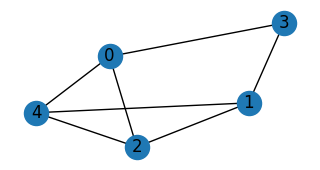

OPT=8.00
max Lvk: 5.00
nontrivial Lvk: [5.]
degree of vertex 0: 3
eigvec_E = 1.50 


In [ ]:
G = all_graphs[two_vc_fc_idxs[5]]
plt.figure(figsize=(3,1.5))
nx.draw(G, with_labels=True)
plt.show()
n=G.number_of_nodes()
k=n//2
Gv = get_Gv(G, 0)
Gvs = get_Gvs(G, 0)
Gk = get_wedge_graph(G, k)
Gvk = get_wedge_graph(Gv, k)
Gvkm1 = get_wedge_graph(Gv, k-1)
Lvk = get_laplacian_matrix(Gvk, nodelist=list(combinations(range(n), k)))
Lvkm1 = get_laplacian_matrix(Gvkm1, nodelist=list(combinations(range(n), k-1)))
Lvk_eigvals, Lvk_eigvecs = np.linalg.eigh(Lvk)
Lvkm1_eigvals, Lvkm1_eigvecs = np.linalg.eigh(Lvkm1)
Lvk_nontrivial_idxs = ~isin_tol(Lvk_eigvals, Lvkm1_eigvals)
print(f'OPT={get_maximum_eigval(get_laplacian_matrix(Gk)):.2f}')
print(f'max Lvk: {max(Lvk_eigvals):.2f}')
print('nontrivial Lvk:', np.round(Lvk_eigvals[Lvk_nontrivial_idxs],2))
for eigvec in Lv
Lvk_nontrivial_eigvecs = Lvk_eigvecs[:, Lvk_nontrivial_idxs]
Gvsk = get_wedge_graph(Gvs, k)
Lvsk = get_laplacian_matrix(Gvsk, nodelist=list(combinations(range(n), k)))
B = make_B_matrix(n, k, k-1)
print(f'degree of vertex 0: {G.degree(0)}')
for eigvec in Lvk_nontrivial_eigvecs.T:
    if not np.allclose(B.T @ eigvec, 0):
        print('Fail B.T @ x=0')
        break
    eigvec_E = np.conjugate(eigvec).T @ Lvsk @ eigvec
    print(f'eigvec_E = {eigvec_E:.2f} ')

In [156]:
for idx in tqdm(two_vc_fc_idxs[:1000]):
    G = all_graphs[idx]

    n=G.number_of_nodes()
    k=n//2
    Gv = get_Gv(G, 0)
    Gvs = get_Gvs(G, 0)
    Gk = get_wedge_graph(G, k)
    Gvk = get_wedge_graph(Gv, k)
    Gvkm1 = get_wedge_graph(Gv, k-1)
    Lvk = get_laplacian_matrix(Gvk, nodelist=list(combinations(range(n), k)))
    Lvkm1 = get_laplacian_matrix(Gvkm1, nodelist=list(combinations(range(n), k-1)))
    Lvk_eigvals, Lvk_eigvecs = np.linalg.eigh(Lvk)
    Lvkm1_eigvals, Lvkm1_eigvecs = np.linalg.eigh(Lvkm1)
    Lvk_nontrivial_idxs = ~isin_tol(Lvk_eigvals, Lvkm1_eigvals)
    opt = get_maximum_eigval(get_laplacian_matrix(Gk))
    Lvk_nontrivial_eigvecs = Lvk_eigvecs[:, Lvk_nontrivial_idxs]
    Gvsk = get_wedge_graph(Gvs, k)
    Lvsk = get_laplacian_matrix(Gvsk, nodelist=list(combinations(range(n), k)))
    B = make_B_matrix(n, k, k-1)
    for eigvec in Lvk_nontrivial_eigvecs.T:
        if not np.allclose(B.T @ eigvec, 0):
            print(idx, 'Fail B.T @ x=0')
            break
        eigvec_E = np.conjugate(eigvec).T @ Lvsk @ eigvec
        if eigvec_E > G.degree(0) + TOL-1:
            print(idx, 'Fail eigvec_E > degree')
            break

100%|██████████| 1000/1000 [02:09<00:00,  7.69it/s]


In [37]:
n=5
k=n//2
G = nx.cycle_graph(n)
G.add_edges_from([(1,3),(1,4)])
Gk = get_wedge_graph(G, k)
Gkm1 = get_wedge_graph(G, k-1)
Lk = get_laplacian_matrix(Gk, nodelist=list(combinations(range(n), k)))
Lkm1 = get_laplacian_matrix(Gkm1, nodelist=list(combinations(range(n), k-1)))
Qk = get_signless_laplacian(Gk, nodelist=list(combinations(range(n), k)))
Qkm1 = get_signless_laplacian(Gkm1, nodelist=list(combinations(range(n), k-1)))
B = make_B_matrix(n, k, k-1)
np.allclose(B@Lkm1, Lk@B), np.allclose(B@Qkm1, Qk@B)

(True, False)

In [38]:
Gvs = get_Gvs(G, 0)
Gkvs = get_wedge_graph(Gvs, k)
Lkvs = get_laplacian_matrix(Gkvs, nodelist=list(combinations(range(n), k)))
Lkvs_remainder = Lkvs - B @ B.T
get_maximum_eigval(Lkvs), get_maximum_eigval(Lkvs_remainder)

(np.float64(3.0000000000000004), np.float64(3.000000000000001))

3.9999999999999996
3.414213562373095


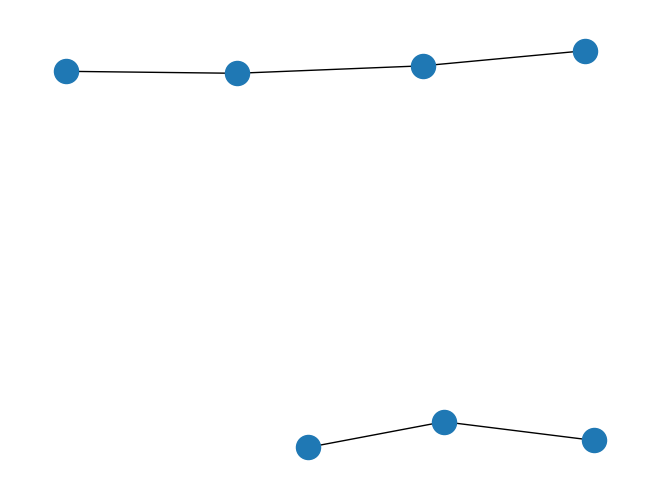

In [91]:
G = nx.cycle_graph(5)
k = 1
Gk = get_wedge_graph(G, k)
Lk = nx.laplacian_matrix(Gk).toarray()
Ak = nx.adjacency_matrix(Gk).toarray()
Qk = np.diag(np.diag(Lk))+Ak
print(get_maximum_eigval(Qk))
G = nx.Graph()
G.add_edges_from([(0,1),(0,2),(3,4),(4,5),(5,6)])
nx.draw(G)
Gk = get_wedge_graph(G, k)
Lk = nx.laplacian_matrix(Gk).toarray()
Ak = nx.adjacency_matrix(Gk).toarray()
Qk = np.diag(np.diag(Lk))+Ak
print(get_maximum_eigval(Qk))

Spamming bounds from  https://arxiv.org/pdf/1111.2897

In [63]:
def compute_t(G, u):
    """Compute t(u) = d(u) + m(u), where m(u) is the average degree of neighbors of u."""
    d_u = G.degree[u]
    neighbors = list(G.neighbors(u))
    if not neighbors:
        m_u = 0
    else:
        m_u = sum(G.degree[v] for v in neighbors) / len(neighbors)
    return d_u + m_u

def bound_14(G):
    max_val = float('-inf')
    for u, v in G.edges():
        d_u, d_v = G.degree[u], G.degree[v]
        t_u, t_v = compute_t(G, u), compute_t(G, v)  # t(u) = d(u) + m(u)
        numerator = d_u * t_u + d_v * t_v
        denominator = d_u + d_v
        val = numerator / denominator if denominator != 0 else 0
        max_val = max(max_val, val)
    return max_val

def bound_15(G):
    max_val = float('-inf')
    for u, v in G.edges():
        d_u, d_v = G.degree[u], G.degree[v]
        t_u, t_v = compute_t(G, u), compute_t(G, v)
        val = 2 + np.sqrt(d_u * (t_u - 4) + d_v * (t_v - 4) + 4)
        max_val = max(max_val, val)
    return max_val

def bound_16(G):
    max_val = float('-inf')
    for u, v in G.edges():
        d_u, d_v = G.degree[u], G.degree[v]
        t_u, t_v = compute_t(G, u), compute_t(G, v)
        val = np.sqrt(d_u * t_u + d_v * t_v)
        max_val = max(max_val, val)
    return max_val

def bound_17(G):
    max_val = float('-inf')
    for u in G.nodes():
        d_u = G.degree[u]
        t_u = compute_t(G, u)
        val = np.sqrt(2 * d_u * t_u)
        max_val = max(max_val, val)
    return max_val

def bound_18(G):
    max_val = float('-inf')
    for u in G.nodes():
        d_u = G.degree[u]
        neighbors = list(G.neighbors(u))
        m_u = sum(G.degree[v] for v in neighbors) / len(neighbors) if neighbors else 0
        val = d_u + np.sqrt(d_u * m_u)
        max_val = max(max_val, val)
    return max_val

def bound_19(G):
    max_val = float('-inf')
    for u in G.nodes():
        d_u = G.degree[u]
        N_u = set(G.neighbors(u))
        if d_u == 0:
            continue
        m_prime_u = sum(d_u - len(N_u & set(G.neighbors(v))) for v in N_u) / d_u
        val = np.sqrt(2 * d_u * (d_u + m_prime_u))
        max_val = max(max_val, val)
    return max_val

def bound_20(G):
    max_val = float('-inf')
    for u, v in G.edges():
        d_u, d_v = G.degree[u], G.degree[v]
        neighbors_u = list(G.neighbors(u))
        neighbors_v = list(G.neighbors(v))
        m_u = sum(G.degree[w] for w in neighbors_u) / len(neighbors_u) if neighbors_u else 0
        m_v = sum(G.degree[w] for w in neighbors_v) / len(neighbors_v) if neighbors_v else 0
        val = (d_u + d_v + np.sqrt((d_u - d_v)**2 + 4 * m_u * m_v)) / 2
        max_val = max(max_val, val)
    return max_val

def bound_22(G):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    degrees = [d for _, d in G.degree()]
    delta = min(degrees)
    Delta = max(degrees)
    numerator = (delta - 1) + np.sqrt((delta - 1)**2 + 8 * (Delta**2 + 2 * m - (n - 1) * delta))
    return numerator / 2

def bound_23(G):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    degrees = [d for _, d in G.degree()]
    delta = min(degrees)
    Delta = max(degrees)
    numerator = (Delta + delta - 1) + np.sqrt((Delta + delta - 1)**2 + 8 * (2 * m - (n - 1) * delta))
    return numerator / 2

In [31]:
def merris_bound(G):
    n = G.number_of_nodes()
    L = nx.laplacian_matrix(G).toarray()
    I = np.eye(n)
    Omega = np.linalg.inv(I + L)
    omega_G = np.min(Omega)
    return  2 * (n + 1) * omega_G

In [138]:
n=11
G=nx.cycle_graph(n)
Gc = nx.complement(G)
lk_min_prev, lk_max_prev = 0, np.inf
lkc_min_prev, lkc_max_prev = 0, np.inf
for k in range(1, n//2):
    Gk = get_wedge_graph(G, k)
    Gkc = get_wedge_graph(Gc, k)
    Lk = nx.laplacian_matrix(Gk).toarray()
    Lkc  = nx.laplacian_matrix(Gkc).toarray()
    eigvals, eigvecs = np.linalg.eigh(Lk)
    eigvals_c, eigvecs_c = np.linalg.eigh(Lkc)
    lk_min, lk_max = np.min(eigvals[eigvals>lk_min_prev+TOL]), np.max(eigvals)
    lkc_min, lkc_max = np.min(eigvals_c[eigvals_c>lkc_min_prev+TOL]), np.max(eigvals_c)
    lk_min_prev, lk_max_prev = lk_min, lk_max 
    lkc_min_prev, lkc_max_prev = lkc_min, lkc_max
    print(k, lk_min_prev, lk_max_prev, lkc_min, lkc_max)

1 0.31749293433763703 3.9189859472289954 7.081014052771005 10.682507065662364
2 0.5550846345178414 7.649349118717517 7.690278532109425 19.444915365482164
3 0.7167692599232683 10.940210277075323 8.715370323453438 26.283230740076743
4 0.7639320225002117 13.484034562476651 9.830830026003762 31.19406898135169


In [139]:
n=11
G=nx.cycle_graph(n)
k=1
L = nx.laplacian_matrix(G).toarray()
eigvals = np.linalg.eigvals(L)
lk_min_prev, lk_max_prev = np.unique(eigvals)[1], np.max(eigvals)
Gc = nx.complement(G)
Lc = nx.laplacian_matrix(Gc).toarray()
eigvals_c = np.linalg.eigvals(Lc)
lkc_min_prev, lkc_max_prev = np.unique(eigvals_c)[1], np.max(eigvals_c)
print(f'W+1={G.number_of_edges()+k}')
print(lk_min_prev, lk_max_prev, lkc_min_prev, lkc_max_prev)
for k in range(2, n//2):
    print(f'W+{k}={G.number_of_edges()+k}')
    lk_max = k /(k-1) * lk_max_prev
    lk_min = k/(k-1) * lk_min_prev - k
    lkc_max = k/(k-1) * lkc_max_prev
    lkc_min = k/(k-1) * lkc_min_prev - k
    lk_max = min(lk_max, k*(n-k+1)-lkc_min)
    lk_min = max(lk_min, k*(n-k+1)-lkc_max)
    lkc_max = min(lkc_max, k*(n-k+1)-lk_min)
    lkc_min = max(lkc_min, k*(n-k+1)-lk_max)
    lk_min_prev, lk_max_prev = lk_min, lk_max 
    lkc_min_prev, lkc_max_prev = lkc_min, lkc_max
    print(k, lk_min, lk_max, lkc_min, lkc_max)

W+1=12
0.3174929343376375 3.9189859472289945 7.081014052771001 10.682507065662374
W+2=13
2 -1.365014131324725 7.837971894457989 12.16202810554201 21.365014131324724
W+3=14
3 -5.047521196987084 11.756957841686983 15.243042158313017 32.047521196987084
W+4=15
4 -10.73002826264944 15.675943788915976 16.324056211084024 42.73002826264944


In [53]:
n=7
G=nx.cycle_graph(n)
Gc = nx.complement(G)
k=n//2
Gk = get_wedge_graph(G, k)
Gkc = get_wedge_graph(Gc, k)
Gkc_diam = nx.diameter(Gkc)
Gkc_edge_conn = nx.edge_connectivity(Gkc)
#print(Gkc_diam)
Gk_n = Gk.number_of_nodes() 
Gkc_m = Gkc.number_of_edges()
Lk = nx.laplacian_matrix(Gk).toarray()
eigvals, eigvecs = np.linalg.eigh(Lk)
print(f'W+M={G.number_of_nodes()+k}, OPT={max(eigvals)}')
print((n+3)*(n-1)/4 -(Gk_n / (1+ (Gk_n*(Gk_n-1)/2 - Gkc_m)*Gkc_diam)))
print((n+3)*(n-1)/4 -(2*Gkc_edge_conn * (1-np.cos(np.pi/Gk_n))))
Lkc_eigvals = np.linalg.eigh(nx.laplacian_matrix(Gkc).toarray())[0]
print(np.round(np.unique(Lkc_eigvals),2))
lambda_n_minus_1 = np.unique(Lkc_eigvals)[1]
print((n+3)*(n-1)/4 -merris_bound(Gkc))
print(np.round((n+3)*(n-1)/4 - lambda_n_minus_1,2))


W+M=10, OPT=9.210358513693386
14.974377745241581
14.951691527942868
[-0.    3.2   3.2   4.55  4.55  4.89  4.89  5.79  5.79  6.    6.25  6.25
  6.86  6.86  7.26  7.26  7.96  7.96  8.06  9.28  9.28 10.   10.   10.
 10.1  10.1  10.84 10.84 11.16 12.08 12.08 13.73 13.73]
13.816551080558927
11.8


In [16]:
n=7
G = nx.cycle_graph(n)
k = n//2
Gk = get_wedge_graph(G, k)
print(f'W+M={G.number_of_edges()+k}')
for bound_fn in [bound_14, bound_15, bound_16, bound_17, bound_18, bound_19, bound_20, bound_22, bound_23]:
    print(f'{bound_fn.__name__}(Gk)={bound_fn(Gk):.4f}')
    print()

W+M=10
bound_14(Gk)=10.6667

bound_15(Gk)=11.1652

bound_16(Gk)=11.3137

bound_17(Gk)=11.3137

bound_18(Gk)=11.2915

bound_19(Gk)=12.0000

bound_20(Gk)=10.6667

bound_22(Gk)=15.2054

bound_23(Gk)=16.0000



Deforming edges to a bipartite graph

In [22]:
n=7
G = nx.cycle_graph(n)
#nx.draw(G, with_labels=True)
#plt.show()
G.add_edges_from([(1,5),(0,4)])
unweighted_G(G)
H = generate_H_QMC(G)
eigvals, eigvecs = np.linalg.eigh(H)
print(np.max(eigvals))
G.remove_edges_from([(0,6),(1,5),(0,4)])
G.add_edges_from([(2,5),(1,6),(1,4)])
unweighted_G(G)
#nx.draw(G, with_labels=True)
#plt.show()
H = generate_H_QMC(G)
eigvals, eigvecs = np.linalg.eigh(H)
print(np.max(eigvals))


11.18516544128673
11.690937555387011


In [ ]:
#L>=R
L, R = 4,3
#R=L
k=3
G = nx.complete_bipartite_graph(L,R)
Gk = get_wedge_graph(G, k)
Lk = nx.laplacian_matrix(Gk).toarray()
print(f'W+k={G.number_of_edges()+k}, OPT = {get_maximum_eigval(Lk):.2f}, guess={k*(L+R-k+1)}')

W+k=15, OPT = 15.00, guess=15


In [120]:
def learn_linear_function(k):

    samples = []
    values = []
    # Select small values satisfying L >= R and k <= floor(R/2)
    for L in range(k+1, 8):
        for R in range(k+1, L + 1):
                samples.append([L, R, L*R, k])  # Augment with 1 for bias term
                G = nx.complete_bipartite_graph(L,R)
                Gk = get_wedge_graph(G, k)
                Lk = nx.laplacian_matrix(Gk).toarray()
                values.append(get_maximum_eigval(Lk))
    
    # Solve the linear system Ax = b
    A = np.array(samples)
    b = np.array(values)
    coeffs, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
    
    print(f"res={residuals}")
    return coeffs

In [123]:
np.round(learn_linear_function(4),2)

res=[3.17615892e-28]


array([ 4.,  4., -0., -3.])

Collatz–Wielandt Formula

$\lambda_{\text{max}}(M) = \max_{x > 0} \min_i \frac{(Mx)_i}{x_i}  = \min_{x > 0} \max_i \frac{(Mx)_i}{x_i}$?

In [12]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit import transpile
from qiskit.quantum_info import Statevector, Operator, Pauli
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()

In [12]:
# try matching ansatz for x
def prepare_max_matching_state(G):
    n=G.number_of_nodes()
    qc = QuantumCircuit(n)
    M, max_matching_edges = get_maximum_matching(G, return_edges=True)
    for (i,j) in max_matching_edges:
        qc.h(i)
        qc.cx(i,j)
        qc.x(i)
    #matched_nodes = set([i for (i,j) in max_matching_edges]+[j for (i,j) in max_matching_edges])
    #unmatched_nodes = [i for i in range(n) if i not in matched_nodes ]
    #for i in unmatched_nodes:
    #    qc.h(i)
    return np.real(Statevector(qc)._data)

def get_unitary_from_H(H, theta):
    U = expm(1j * theta * H)
    return UnitaryGate(U)

def safe_divide(a, b):
    result = np.zeros_like(a, dtype=float)  # Initialize result array with zeros.
    # Handle the case where both a[i] == 0 and b[i] == 0 (set to 0)
    mask_zero_a_zero_b = (a == 0) & (b == 0)
    result[mask_zero_a_zero_b] = 0
    # Handle the case where a[i] != 0 and b[i] == 0 (set to np.inf)
    mask_nonzero_a_zero_b = (a != 0) & (b == 0)
    result[mask_nonzero_a_zero_b] = np.inf
    # Normal element-wise division where b[i] != 0
    mask_nonzero_b = (b != 0)
    result[mask_nonzero_b] = a[mask_nonzero_b] / b[mask_nonzero_b]

    return result

def get_collatz_wielandt_bound(M, x, dual=True):
    #if dual: 
    #    nonzero_x_idxs = np.where(x != 0.)
        #x = np.maximum(x, 1e-16)
    #    nonzero_x_idxs = x > 0
    #    return np.max(M@x / x)
    if dual: return np.max(safe_divide(M @ x, x) )
    else: return np.min(safe_divide(M @ x, x) )

def optimize_collatz_wielandt_bound(M, dual=False, trials= 10):
    if dual:
        opt = np.inf
        for trial in range(trials):
            res = minimize(lambda x : get_collatz_wielandt_bound(M, x, dual=True), np.random.random(M.shape[0]), method='L-BFGS-B', bounds=[(0, None)]*M.shape[0])
            opt = min(opt, res.fun)
        return opt
    else:
        opt = -np.inf
        for trial in range(trials):
            res = minimize(lambda x : -get_collatz_wielandt_bound(M, x, dual=False), np.random.random(M.shape[0]), method='L-BFGS-B', bounds=[(0, None)]*M.shape[0])
            opt = max(opt, -res.fun)
        return opt

def optimize_collatz_wielandt_bound_w_plus_m(H, max_eigvec, w_plus_m):
    res = minimize(lambda x: (get_collatz_wielandt_bound(H, x, dual=True)-w_plus_m)**2, max_eigvec, method='nelder-mead')
    return res

def gershegorin_cost_fn(A, C, min_row=False):
    M = np.diag(1/np.diag(C)) @ A @ np.diag(np.diag(C))
    if min_row: return np.min(np.sum(np.abs(M), axis=1))
    else: return np.max(np.sum(np.abs(M), axis=1))
    
def ham_weight_mask(n, k):
    # return a boolean vector of length 2**n that is 1 if the corresponding bitstring hamming weight k and 0 otherwise
    # e.g. n=3, k=2 returns [0, 0, 0, 1, 0, 1, 1, 0]  (000, 001, 010, 011, 100, 101, 110, 111)
    mask = np.zeros(2**n, dtype=bool)
    for i in range(2**n):
        if bin(i).count('1') == k:
            mask[i] = 1
    return mask

def gershegorin_cost_fn(A, C, min_row=False, zero_to_eps=0):
    if zero_to_eps:
        #print(zero_to_eps)
        C = np.diag(np.maximum(np.diag(C), zero_to_eps*np.ones(len(np.diag(C)))))
    #print(np.diag(C))
    M = np.diag(1/np.diag(C)) @ A @ np.diag(np.diag(C))
    if min_row:
        return np.min(np.sum(np.abs(M), axis=1))
    else:
        return np.max(np.sum(np.abs(M), axis=1))

def gershegorin_cost_fn_degree_matrix_power(A, D, degree):
    M = np.diag(1/(np.diag(D)**degree)) @ A @ np.diag(np.diag(D)**degree)
    return np.max(np.sum(np.abs(M), axis=1))
    
def optimize_gershegorin(A, D, trials=50):
    n = A.shape[0]
    best_cost = np.inf
    best_C = None
    for _ in range(trials):
        C = np.diag(D)**(2*np.random.rand())
        #res = minimize
        res = minimize(lambda x: gershegorin_cost_fn(A, np.diag(x)), C, tol=1e-1, method='Nelder-Mead')
        if res.fun < best_cost:
            best_cost = res.fun
            best_C = res.x
    for _ in range(trials):
        C = np.random.rand(n)
        #res = minimize
        res = minimize(lambda x: gershegorin_cost_fn(A, np.diag(x)), C, tol=1e-1, method='Nelder-Mead')
        if res.fun < best_cost:
            best_cost = res.fun
            best_C = res.x
    return best_cost, best_C

def optimize_gershegorin_degree_matrix_power(A, D, trials=int(1e3)):
    best_cost = np.inf
    best_degree = None
    for _ in range(trials):
        # random float between 0 and 2
        degree = np.random.rand() * 4
        cost = gershegorin_cost_fn_degree_matrix_power(A, D, degree)
        if cost < best_cost:
            best_cost = cost
            best_degree = degree
    return best_cost, best_degree

In [40]:
n=5
k=n//2
G= nx.cycle_graph(n)
add_weights(G, 'unweighted')
H = generate_H_Phi_minus(G)
eigvals, eigvecs = np.linalg.eigh(H)
print(f'W+M={G.number_of_edges()+k}, OPT={eigvals[-1]:.2f}')
#max_eigvec = eigvecs[:, -1]
#print(f'opt={eigvals[-1]:.2f}, w+m={G.number_of_edges()+k}')
print(gershegorin_cost_fn(H, np.eye(2**n)))
print(optimize_gershegorin_degree_matrix_power(H, np.diag(np.diag(H))))

W+M=7, OPT=6.83
8.0


/tmp/ipykernel_1491/1672295183.py:87: RuntimeWarning: divide by zero encountered in divide
  M = np.diag(1/(np.diag(D)**degree)) @ A @ np.diag(np.diag(D)**degree)
/tmp/ipykernel_1491/1672295183.py:87: RuntimeWarning: invalid value encountered in divide
  M = np.diag(1/(np.diag(D)**degree)) @ A @ np.diag(np.diag(D)**degree)
/tmp/ipykernel_1491/1672295183.py:87: RuntimeWarning: invalid value encountered in matmul
  M = np.diag(1/(np.diag(D)**degree)) @ A @ np.diag(np.diag(D)**degree)


(inf, None)


In [182]:
def get_eunou_state(G, theta= np.arcsin((np.sqrt(5)-1)/2)/2 ):
    n=G.number_of_nodes()
    add_weights(G, 'unweighted')
    qc = QuantumCircuit(n)
    M, max_matching_edges = get_maximum_matching(G, return_edges=True)
    H = np.kron(X-Y, X-Y) / 2
    gate = get_unitary_from_H(H, theta)
    for (i,j) in max_matching_edges:
        qc.append(gate, [i, j])
    sqrtX = repeated_kron([sqrtm(X) for _ in range(n)])
    return sqrtX@np.real(Statevector(qc)._data)

In [183]:
n=5
k=n//2
G= nx.cycle_graph(n)
add_weights(G, 'unweighted')
H = generate_H_Phi_minus(G)
eigvals, eigvecs = np.linalg.eigh(H)
max_eigvec = eigvecs[:, -1]
print(f'opt={eigvals[-1]:.2f}, w+m={G.number_of_edges()+k}')
mm_state = prepare_max_matching_state(G)
eunou_state = get_eunou_state(G)
print(np.conjugate(mm_state) @ H @ mm_state)
print(np.conjugate(eunou_state) @ H @ eunou_state)
gershegorin_cost_fn(H, np.diag(mm_state), zero_to_eps=1e-4), gershegorin_cost_fn(H, np.diag(eunou_state))

opt=6.83, w+m=7
(5.499999999999998+0j)
(5.83123634963213+0j)


(np.float64(5006.999999999999), np.float64(8.544039299028139))

Try to find D such that D^-1 K D gives small gersheg bound

In [193]:
n=9
G = nx.cycle_graph(n)
k=n//2
Gk = get_wedge_graph(G, k)
Lk= nx.laplacian_matrix(Gk).toarray()
Ak = nx.adjacency_matrix(Gk).toarray()
Dk = np.diag(np.diag(Lk))
Kk = Dk+Ak
eigvals, eigvecs = np.linalg.eigh(Kk)
max_eigvec = eigvecs[:,-1]
second_eigvec = eigvecs[:,-2]
#gershegorin_cost_fn(Kk, np.eye(np.shape(Kk)[0]))
print(f'max eigval: {np.max(eigvals):.3f}, W+k: {(G.number_of_edges()+k):.2f}, naive gersheg: {gershegorin_cost_fn(Kk, np.eye(np.shape(Kk)[0])):.2f}')
#cost, C = optimize_gershegorin(Kk, Dk)
#print(f'optimized cost: {cost:.2f}, C: {np.round(C,2)}')
print(f'gershegorin with D: {gershegorin_cost_fn_degree_matrix_power(Kk, Dk, 1):.3f}')
#print(f'gershegorin with root D: {gershegorin_cost_fn_degree_matrix_power(Kk, Dk, .5):.2f}')
cost, degree = optimize_gershegorin_degree_matrix_power(Kk, Dk)
print(f'gershegorin with D^k: {cost:.3f}, k: {degree:.3f}')
print(f'gershegorin with max eigvec: {gershegorin_cost_fn(Kk, np.diag(max_eigvec), min_row=False):.3f}')
#print(f'gershegorin with min eigvec: {gershegorin_cost_fn(Kk, min_eigvec):.3f}')

max eigval: 12.415, W+k: 13.00, naive gersheg: 16.00
gershegorin with D: 14.500
gershegorin with D^k: 13.300, k: 2.078
gershegorin with max eigvec: 12.415


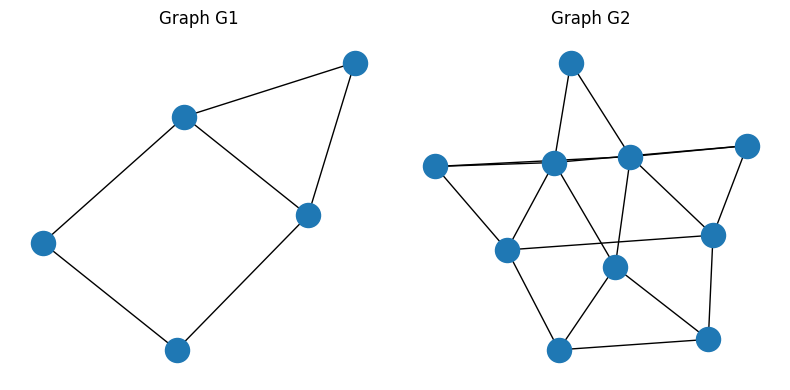

True

In [262]:
from networkx.algorithms import isomorphism

n=5
G = nx.cycle_graph(n)
G.add_edges_from([(0,2)])
G1 = get_wedge_graph(G, 1)
G2 = get_wedge_graph(G, 2)

GM = isomorphism.GraphMatcher(G2, G1)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
nx.draw(G1, ax=axs[0])
axs[0].set_title("Graph G1")
nx.draw(G2, ax=axs[1])
axs[1].set_title("Graph G2")
plt.tight_layout()
plt.show()
GM.subgraph_is_isomorphic()

In [212]:
def get_best_qmc_and_epr_eigvecs_and_sector(G, ham_types=['qmc', 'epr'], save_eigvecs=False):
    n=G.number_of_nodes()
    best_epr_eigval, best_qmc_eigval = 0,0
    best_epr_sector, best_qmc_sector = 0,0
    best_epr_eigvecs, best_qmc_eigvecs = [],[]
    for k in range(1, int(np.ceil(n/2))+1):
        G_k = get_wedge_graph(G,k)
        A_k = nx.adjacency_matrix(G_k).toarray()
        L_k = nx.laplacian_matrix(G_k).toarray()
        K_k =A_k + np.diag(np.diag(L_k)) 
        if 'epr' in ham_types:
            epr_eigvals, epr_eigvecs = np.linalg.eigh(K_k)
            epr = np.max(np.real(epr_eigvals))
            if epr>best_epr_eigval+TOL:
                best_epr_eigval=epr
                best_epr_sector=k
                if save_eigvecs: best_epr_eigvecs = [epr_eigvecs[:,idx].flatten() for idx in np.where(np.abs(epr_eigvals-epr)<TOL)]
        if 'qmc' in ham_types:
            qmc_eigvals, qmc_eigvecs = np.linalg.eigh(L_k)
            qmc = np.max(np.real(qmc_eigvals))
            if qmc>best_qmc_eigval+TOL:
                best_qmc_eigval=qmc
                best_qmc_sector=k
                if save_eigvecs: best_qmc_eigvecs= [qmc_eigvecs[:,idx].flatten() for idx in np.where(np.abs(qmc_eigvals-qmc)<TOL)]
    return {'best_epr_sector': best_epr_sector, 'best_qmc_sector': best_qmc_sector, 
            'best_epr_eigval': best_epr_eigval, 'best_qmc_eigval': best_qmc_eigval, 
            'best_epr_eigvecs': best_epr_eigvecs, 'best_qmc_eigvecs': best_qmc_eigvecs}

In [190]:
two_vc_fc_epr_opts, two_vc_fc_qmc_opts = max_epr_energies[two_vc_fc_idxs], max_qmc_energies[two_vc_fc_idxs]
two_vc_fc_yz_opts, two_vc_fc_nyz_opts = max_yz_energies[two_vc_fc_idxs], max_nyz_energies[two_vc_fc_idxs]
two_vc_fc_cuts, two_vc_fc_matches = cuts[two_vc_fc_idxs], matches[two_vc_fc_idxs]
two_vc_fc_ns, two_vc_fc_ms = ns[two_vc_fc_idxs], total_weights[two_vc_fc_idxs]

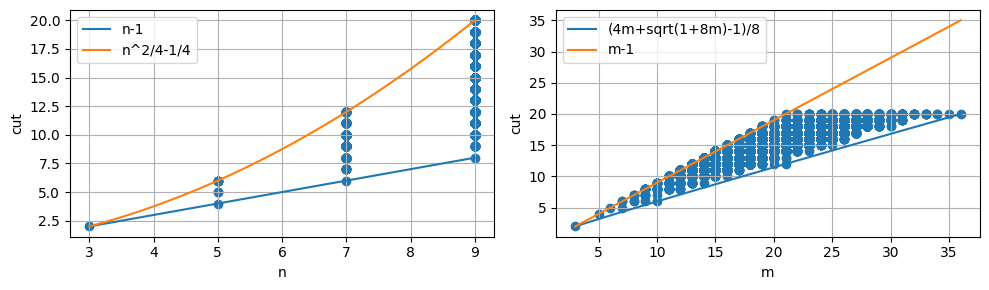

In [193]:
n_range = np.linspace(min(two_vc_fc_ns), max(two_vc_fc_ns), 100)
m_range = np.linspace(min(two_vc_fc_ms), max(two_vc_fc_ms), 100)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Plot for n
axs[0].plot(n_range, n_range-1, label='n-1')
axs[0].plot(n_range, n_range**2/4-1/4, label='n^2/4-1/4')
axs[0].scatter(two_vc_fc_ns, two_vc_fc_cuts)
axs[0].legend()
axs[0].grid()
axs[0].set_xlabel('n')
axs[0].set_ylabel('cut')

# Plot for m
axs[1].plot(m_range, (4*m_range+np.sqrt(1+8*m_range)-1)/8, label='(4m+sqrt(1+8m)-1)/8')
axs[1].plot(m_range, m_range-1, label='m-1')
axs[1].scatter(two_vc_fc_ms, two_vc_fc_cuts)
axs[1].legend()
axs[1].grid()
axs[1].set_xlabel('m')
axs[1].set_ylabel('cut')

plt.tight_layout()
plt.show()

In [209]:
len(two_vc_fc_idxs)

182217

In [215]:
# test if smallest sector with an optimal solution is always n//2
for idx in tqdm(two_vc_fc_idxs[:1000]):
    G= all_graphs[idx]
    n=G.number_of_nodes()
    best_eigvecs_and_sectors = get_best_qmc_and_epr_eigvecs_and_sector(G, ham_types=['epr'])
    best_epr_sector, best_qmc_sector = best_eigvecs_and_sectors['best_epr_sector'], best_eigvecs_and_sectors['best_qmc_sector']
    if np.abs(best_epr_sector-n//2) > TOL:
        print(f'epr {idx} fail!')
        break
    
for idx in tqdm(two_vc_fc_idxs):
    G= all_graphs[idx]
    n=G.number_of_nodes()
    best_eigvecs_and_sectors = get_best_qmc_and_epr_eigvecs_and_sector(G, ham_types=['qmc'])
    best_qmc_sector, best_qmc_sector = best_eigvecs_and_sectors['best_epr_sector'], best_eigvecs_and_sectors['best_qmc_sector']
    if np.abs(best_qmc_sector-n//2) > TOL:
        print(f'qmc {idx} fail!')
        break

  0%|          | 21/182217 [00:00<27:36, 109.99it/s]

qmc 431 fail!


In [217]:
# test if smallest sector with an optimal solution is always one of the maximum cut sectors
for idx in tqdm(two_vc_fc_idxs[:1000]):
    G= all_graphs[idx]
    n=G.number_of_nodes()
    best_eigvecs_and_sectors = get_best_qmc_and_epr_eigvecs_and_sector(G, ham_types=['epr'])
    best_epr_sector, best_qmc_sector = best_eigvecs_and_sectors['best_epr_sector'], best_eigvecs_and_sectors['best_qmc_sector']
    best_cut_sectors = get_maximum_cut(G, return_partitions=True)[1]
    if best_epr_sector not in best_cut_sectors:
        print(f'epr {idx} fail!')
        break
    
for idx in tqdm(two_vc_fc_idxs[:1000]):
    G= all_graphs[idx]
    n=G.number_of_nodes()
    best_eigvecs_and_sectors = get_best_qmc_and_epr_eigvecs_and_sector(G, ham_types=['qmc'])
    best_qmc_sector, best_qmc_sector = best_eigvecs_and_sectors['best_epr_sector'], best_eigvecs_and_sectors['best_qmc_sector']
    best_cut_sectors = get_maximum_cut(G, return_partitions=True)[1]
    if best_qmc_sector not in best_cut_sectors:
        print(f'qmc {idx} fail!')
        break

  2%|▏         | 21/1000 [00:00<00:17, 56.59it/s] 


epr 431 fail!


 43%|████▎     | 428/1000 [00:09<00:12, 45.06it/s]

qmc 34713 fail!


In [182]:
def get_cycle_eigval(n, k):
    G = nx.cycle_graph(n)
    Gk = get_wedge_graph(G, k)
    Lk = nx.laplacian_matrix(Gk).toarray()
    return get_maximum_eigval(Lk)

In [ ]:
from collections import defaultdict

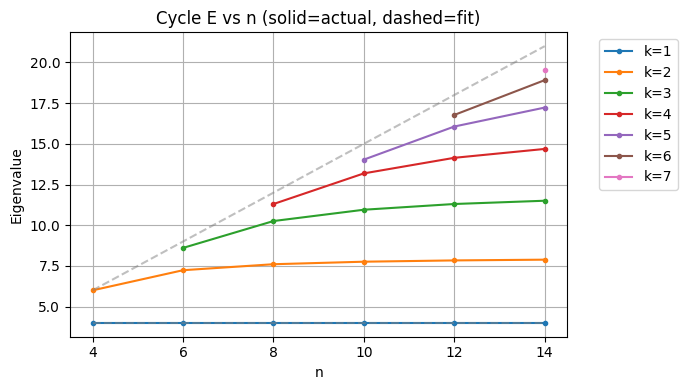

In [224]:
'''n_min = 4
n_max = 14
k_max = 7
data = []
for n in range(n_min, n_max + 1, 2):
    for k in range(1, n // 2 + 1):
        features = [1, n, k, n**2, k**2, n * k]
        value = get_cycle_eigval(n, k)
        data.append((n, k, features, value))
X = np.array([entry[2] for entry in data])
y = np.array([entry[3] for entry in data])
coeffs, *_ = np.linalg.lstsq(X, y, rcond=None)
results_by_k = defaultdict(list)
for n, k, features, value in data:
    predicted = np.dot(coeffs, features)
    results_by_k[k].append((n, value, predicted))'''

plt.figure(figsize=(7, 4))
for k in range(1, k_max + 1):
    if k not in results_by_k:
        continue
    sorted_vals = sorted(results_by_k[k], key=lambda tup: tup[0])  # sort by n
    n_vals = [item[0] for item in sorted_vals]
    actual_vals = [item[1] for item in sorted_vals]
    predicted_vals = [item[2] for item in sorted_vals]
    plt.plot(n_vals, actual_vals, '.-', label=f"k={k}")
    #plt.plot(n_vals, predicted_vals, '--', alpha=0.5)
xs = np.linspace(n_min, n_max, 100)
ys = xs
plt.plot(xs, 3*xs/2, '--', color='gray', alpha=0.5)
#plt.plot(xs, 4*xs/3, '--', color='gray', alpha=0.5)
plt.plot(xs, 4*xs**0, '--', color='gray', alpha=0.5)
plt.plot()
plt.title("Cycle E vs n (solid=actual, dashed=fit)")
plt.xlabel("n")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

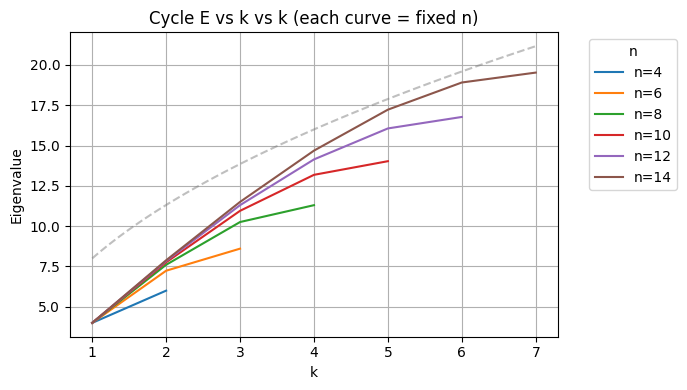

In [211]:
# Group data by n
results_by_n = defaultdict(list)
for n, k, features, value in data:
    results_by_n[n].append((k, value))

# Plotting
plt.figure(figsize=(7, 4))

# Choose how many curves you want to show (limit to avoid clutter)
n_to_plot = sorted(results_by_n.keys())  # plot every 5th n

for n in n_to_plot:
    sorted_vals = sorted(results_by_n[n], key=lambda tup: tup[0])  # sort by k
    k_vals = [item[0] for item in sorted_vals]
    actual_vals = [item[1] for item in sorted_vals]
    plt.plot(k_vals, actual_vals, label=f"n={n}")

xs=np.linspace(1, k_max, 100)
plt.plot(xs, 8*np.sqrt(xs), '--', color='gray', alpha=0.5)

plt.title("Cycle E vs k vs k (each curve = fixed n)")
plt.xlabel("k")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.legend(title="n", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

idx=0 is tight
1.9999999999999998 1 1.0


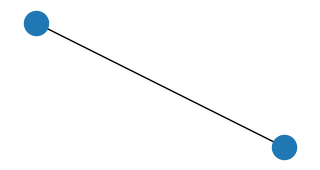

idx=1 is tight
2.9999999999999996 2 2.0


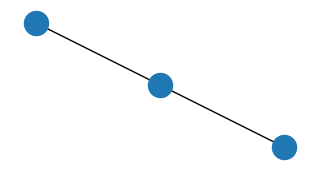

idx=2 is tight
3.9999999999999982 3 2.0


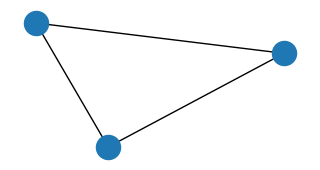

idx=3 is tight
4.0 3 3.0


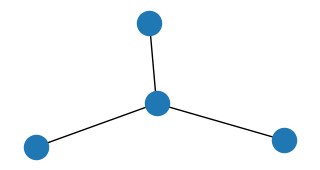

idx=9 is tight
4.999999999999999 4 4.0


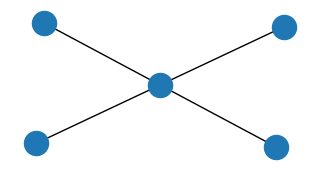

idx=30 is tight
6.000000000000001 5 5.0


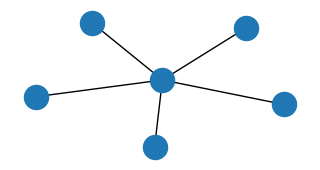

idx=142 is tight
7.0 6 6.0


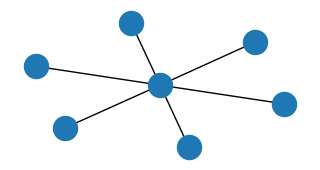

idx=995 is tight
8.000000000000002 7 7.0


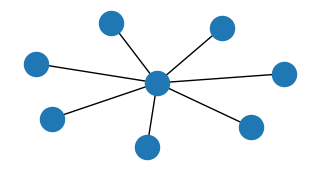

In [136]:
for idx in range(1000):
    G= all_graphs[idx]
    L = get_laplacian_matrix(G)
    Q = get_signless_laplacian(G)
    C = cs[idx] * total_weights[idx]
    Lmax = get_maximum_eigval(L)
    Qmax = get_maximum_eigval(Q)
    if np.abs(Qmax - ((total_weights[idx])+1)) < TOL:
        print(f'idx={idx} is tight')
        print(Qmax, total_weights[idx], C)
        plt.figure(figsize=(3,1.5))
        nx.draw(G)
        plt.show()

idx=0 is tight
1.9999999999999998 1 1.0


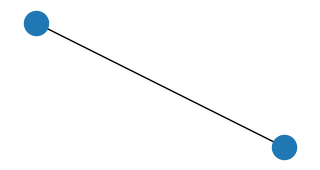

idx=1 is tight
2.9999999999999996 2 2.0


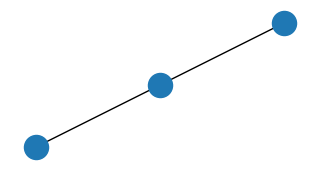

idx=3 is tight
4.0 3 3.0


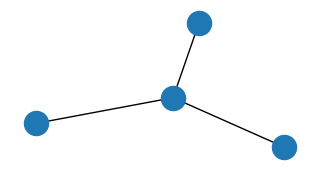

idx=9 is tight
4.999999999999999 4 4.0


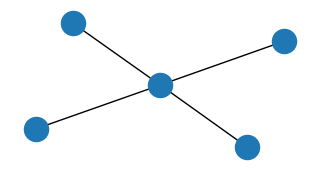

idx=30 is tight
6.000000000000001 5 5.0


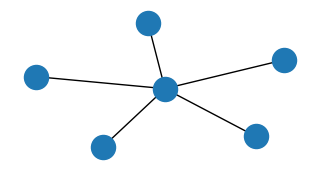

idx=142 is tight
7.0 6 6.0


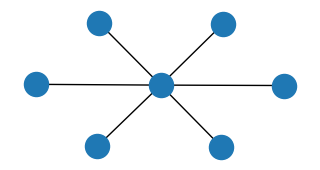

idx=995 is tight
8.000000000000002 7 7.0


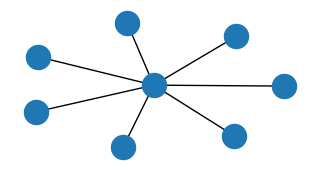

In [ ]:
for idx in range(1000):
    G= all_graphs[idx]
    L = get_laplacian_matrix(G)
    Q = get_signless_laplacian(G)
    C = cs[idx] * total_weights[idx]
    Lmax = get_maximum_eigval(L)
    Qmax = get_maximum_eigval(Q)
    if np.abs(Lmax - ((total_weights[idx]+C)/2+1)) < TOL:
        print(f'idx={idx} is tight')
        print(Lmax, total_weights[idx], C)
        plt.figure(figsize=(3,1.5))
        nx.draw(G)
        plt.show()

idx=6 is tight


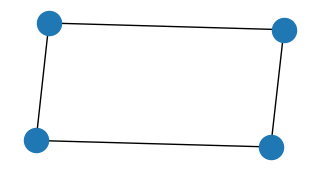

idx=8 is tight


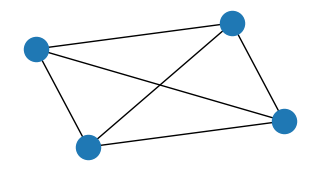

idx=15 is tight


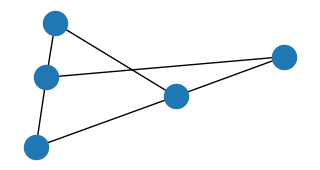

idx=29 is tight


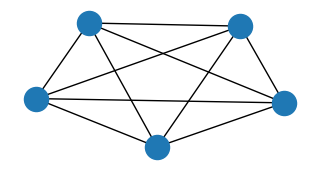

idx=42 is tight


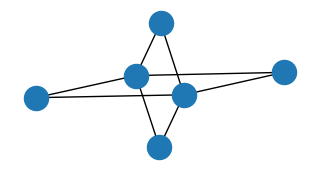

idx=160 is tight


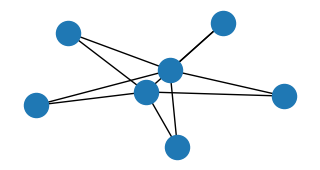

In [139]:
for idx in range(1000):
    G= get_wedge_graph(all_graphs[idx],2)
    L = get_laplacian_matrix(G)
    Q = get_signless_laplacian(G)
    C = cs[idx] * total_weights[idx]
    Lmax = get_maximum_eigval(L)
    Qmax = get_maximum_eigval(Q)
    if np.abs(Qmax - ((total_weights[idx])+2)) < TOL:
        print(f'idx={idx} is tight')
        plt.figure(figsize=(3,1.5))
        nx.draw(all_graphs[idx])
        plt.show()

idx=6 is tight
5.999999999999999 4 4.0


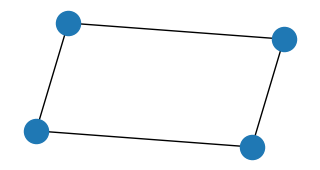

idx=15 is tight
8.000000000000002 6 6.0


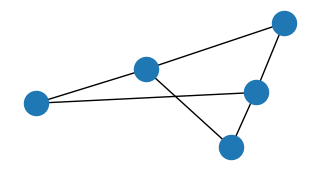

idx=42 is tight
10.000000000000002 8 8.0


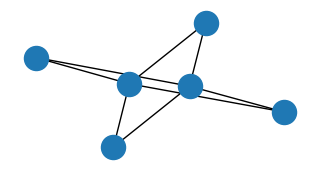

idx=160 is tight
12.000000000000002 10 10.0


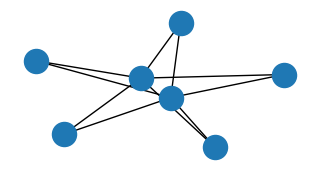

In [138]:
for idx in range(1000):
    G= get_wedge_graph(all_graphs[idx],2)
    L = get_laplacian_matrix(G)
    Q = get_signless_laplacian(G)
    C = cs[idx] * total_weights[idx]
    Lmax = get_maximum_eigval(L)
    Qmax = get_maximum_eigval(Q)
    if np.abs(Lmax - ((total_weights[idx]+C)/2+2)) < TOL:
        print(f'idx={idx} is tight')
        print(Lmax, total_weights[idx], C)
        plt.figure(figsize=(3,1.5))
        nx.draw(all_graphs[idx])
        plt.show()

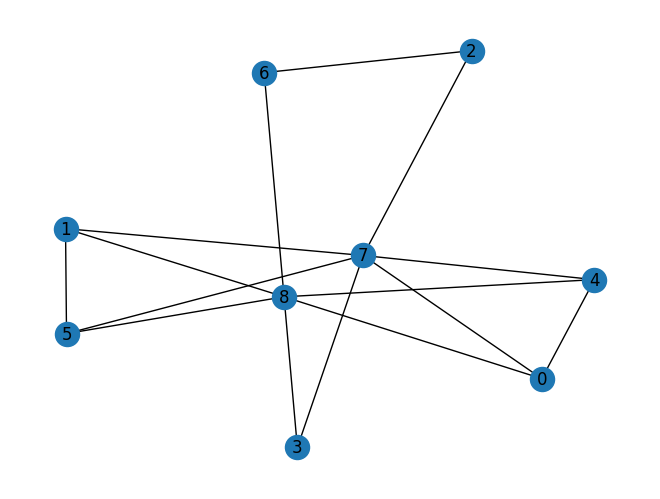

In [25]:
G= all_graphs[34713]
nx.draw(G, with_labels=True)

In [127]:
G= all_graphs[34713]
get_maximum_cut_and_edges(G)

(12, [{7, 8}, {2, 7, 8}, {6, 7, 8}])

In [26]:
G= all_graphs[34713]
n=G.number_of_nodes()
print(f'cut partitions={get_maximum_cut(G, return_partitions=True)}')
for k in range(1, n//2+1):
    G_k = get_wedge_graph(G,k)
    A_k = nx.adjacency_matrix(G_k).toarray()
    L_k = nx.laplacian_matrix(G_k).toarray()
    K_k =A_k + np.diag(np.diag(L_k)) 
    epr_eigvals, epr_eigvecs = np.linalg.eigh(K_k)
    epr = np.max(np.real(epr_eigvals))
    qmc_eigvals, qmc_eigvecs = np.linalg.eigh(L_k)
    qmc = np.max(np.real(qmc_eigvals))
    add_weights(G, 'unweighted')
    print(f'k={k}, epr={epr}, qmc={qmc}, ')

cut partitions=(12, [2, 3])
k=1, epr=8.344003239065476, qmc=7.854101966249684, 
k=2, epr=14.602665410454884, qmc=14.009485415059146, 
k=3, epr=16.632841530849113, qmc=15.109772228646442, 
k=4, epr=17.940815223506284, qmc=15.140054944640262, 


In [270]:
for idx in tqdm(two_vc_fc_idxs[1:10000]):
    G = all_graphs[idx]
    n=G.number_of_nodes()
    for k in range(1, n//2+1):
        G_k = get_wedge_graph(G, k)
        A_k = nx.adjacency_matrix(G_k).toarray()
        L_k = nx.laplacian_matrix(G_k).toarray()
        K_k = A_k + np.diag(np.diag(L_k))
        epr_eigvals,_ = np.linalg.eigh(K_k)
        if np.max(np.real(epr_eigvals)) > G.number_of_edges()+k+TOL:
            break

100%|██████████| 9999/9999 [08:45<00:00, 19.01it/s]


In [46]:
print(idx, k)

1 3


100%|██████████| 9999/9999 [00:09<00:00, 1097.89it/s]


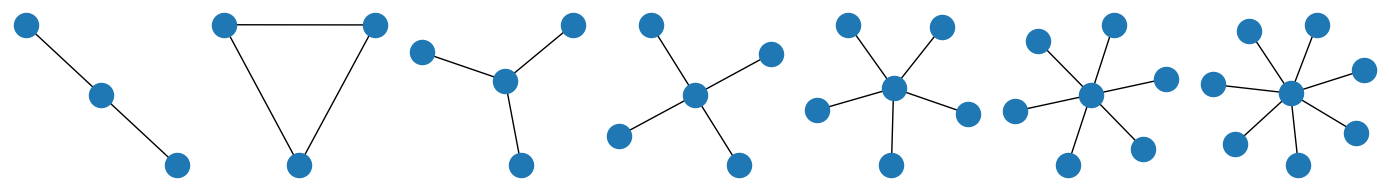

100%|██████████| 9999/9999 [00:17<00:00, 576.92it/s]


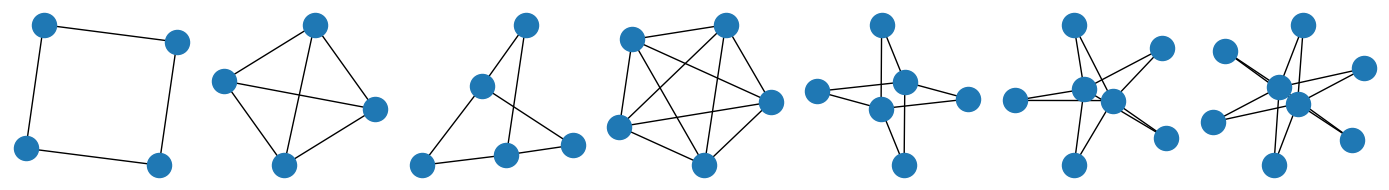

100%|██████████| 9999/9999 [00:45<00:00, 220.19it/s]


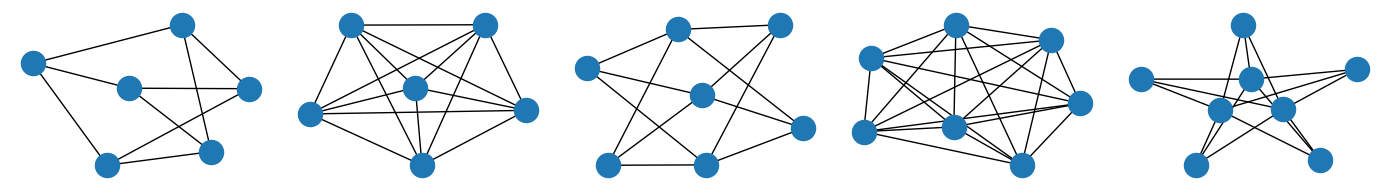

In [50]:
ks = [1,2,3]
for k in ks:
    tight_idxs = []
    for idx in tqdm(range(1,10000)):
        G = all_graphs[idx]
        n=G.number_of_nodes()
        if k<=n//2:
            Gk = get_wedge_graph(G,k)
            Ak = nx.adjacency_matrix(Gk).toarray()
            Lk = nx.laplacian_matrix(Gk).toarray()
            Kk = Ak + np.diag(np.diag(Lk))
            if np.abs(np.max(np.real(np.linalg.eigh(Kk)[0])) - (G.number_of_edges()+k)) <=TOL:
                tight_idxs.append((k,idx))
    plt.figure(figsize=(14, 2))
    num_idxs = len(tight_idxs)
    for plot_idx, (k, graph_idx) in enumerate(tight_idxs):
        plt.subplot(1, num_idxs, plot_idx + 1)
        nx.draw(all_graphs[graph_idx])
    plt.tight_layout()
    plt.show()

In [ ]:
tight_idxs = []
for idx in tqdm(range(1,1000)):
    G = all_graphs[idx]
    A = nx.adjacency_matrix(G).toarray()
    L = nx.laplacian_matrix(G).toarray()
    K = A + np.diag(np.diag(L))
    if np.abs(np.max(np.real(np.linalg.eigh(K)[0])) - (G.number_of_edges()+1)) <=TOL:
        tight_idxs.append((k,idx))

In [69]:
for idx in tqdm(range(1,10000)):
    G = all_graphs[idx]
    n=G.number_of_nodes()
    for k in range(1, n//2+1):
        G_k = get_wedge_graph(G, k)
        A_k = nx.adjacency_matrix(G_k).toarray()
        L_k = nx.laplacian_matrix(G_k).toarray()
        K_k = A_k + np.diag(np.diag(L_k))
        epr_eigvals,_ = np.linalg.eigh(K_k)
        if np.max(np.real(epr_eigvals)) > G.number_of_edges()+k+TOL:
            break

100%|██████████| 9999/9999 [04:23<00:00, 37.88it/s]


In [124]:
len(get_maximum_cut_and_edges(G)[1][0])

3

In [126]:
for idx in tqdm(range(1,2000)):
    G = all_graphs[idx]
    n=G.number_of_nodes()
    for k in range(1, n//2+1):
        G_k = get_wedge_graph(G, k)
        #A_k = nx.adjacency_matrix(G_k).toarray()
        L_k = nx.laplacian_matrix(G_k).toarray()
        #K_k = A_k + np.diag(np.diag(L_k))
        epr_eigvals,_ = np.linalg.eigh(L_k)
        maxcut, partition =get_maximum_cut_and_edges(G)
        A= len(partition[0])
        B = n-A
        if np.max(np.real(epr_eigvals)) > k*(A+B-k+1)+TOL:
            break

100%|██████████| 1999/1999 [00:49<00:00, 40.40it/s]


In [47]:
G=nx.cycle_graph(5)
unweighted_G(G)
get_maximum_cut(G)

np.float64(4.0)

In [ ]:
for idx in tqdm(two_vc_fc_idxs[1:10000]):
    G = all_graphs[idx]
    add_weights(G, 'unweighted')
    maxcut_val = get_maximum_cut(G)
    n=G.number_of_nodes()
    for k in range(1, n//2+1):
        G_k = get_wedge_graph(G, k)
        A_k = nx.adjacency_matrix(G_k).toarray()
        L_k = nx.laplacian_matrix(G_k).toarray()
        K_k = A_k + np.diag(np.diag(L_k))
        epr_eigvals,_ = np.linalg.eigh(K_k)
        qmc_eigvals,_ = np.linalg.eigh(L_k)
        if np.max(np.real(epr_eigvals)) > (G.number_of_edges()+maxcut_val)/2+k+TOL:
            print('fail')
            break

  0%|          | 0/999 [00:00<?, ?it/s]

  6%|▋         | 63/999 [00:00<00:03, 266.56it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 12%|█▏        | 116/999 [00:00<00:03, 247.47it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 14%|█▍        | 143/999 [00:00<00:03, 251.31it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 17%|█▋        | 169/999 [00:00<00:05, 158.29it/s]

fail
fail
fail
fail
fail
fail


 21%|██        | 207/999 [00:01<00:05, 150.15it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 22%|██▏       | 224/999 [00:01<00:05, 150.31it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 26%|██▌       | 257/999 [00:01<00:05, 138.23it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 27%|██▋       | 272/999 [00:01<00:05, 139.89it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 30%|███       | 300/999 [00:01<00:05, 117.14it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 33%|███▎      | 325/999 [00:02<00:06, 105.67it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 34%|███▎      | 336/999 [00:02<00:07, 94.41it/s] 

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 35%|███▍      | 346/999 [00:02<00:07, 86.59it/s]

fail
fail
fail
fail
fail
fail
fail


 36%|███▋      | 363/999 [00:02<00:09, 66.80it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 38%|███▊      | 378/999 [00:03<00:10, 60.53it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail


 39%|███▉      | 393/999 [00:03<00:09, 63.78it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 41%|████      | 408/999 [00:03<00:09, 65.41it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 42%|████▏     | 415/999 [00:03<00:10, 57.48it/s]

fail
fail
fail
fail
fail
fail
fail


 43%|████▎     | 427/999 [00:03<00:11, 51.88it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 45%|████▍     | 446/999 [00:04<00:07, 69.92it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 47%|████▋     | 467/999 [00:04<00:06, 80.03it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 49%|████▊     | 485/999 [00:04<00:06, 80.28it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 50%|█████     | 502/999 [00:04<00:06, 76.17it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 52%|█████▏    | 520/999 [00:05<00:05, 82.67it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 54%|█████▍    | 542/999 [00:05<00:04, 93.84it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 55%|█████▌    | 552/999 [00:05<00:04, 92.16it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 57%|█████▋    | 571/999 [00:05<00:06, 69.77it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail


 59%|█████▉    | 588/999 [00:05<00:05, 73.55it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 61%|██████    | 610/999 [00:06<00:04, 88.90it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 64%|██████▎   | 635/999 [00:06<00:03, 102.96it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 66%|██████▌   | 661/999 [00:06<00:02, 113.63it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 67%|██████▋   | 673/999 [00:06<00:02, 111.57it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 70%|██████▉   | 696/999 [00:06<00:03, 100.61it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 72%|███████▏  | 718/999 [00:07<00:02, 99.76it/s] 

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 74%|███████▍  | 739/999 [00:07<00:02, 95.27it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 76%|███████▌  | 760/999 [00:07<00:02, 99.46it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 78%|███████▊  | 784/999 [00:07<00:02, 91.45it/s] 

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 79%|███████▉  | 794/999 [00:08<00:02, 80.11it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 82%|████████▏ | 816/999 [00:08<00:01, 93.55it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 84%|████████▍ | 840/999 [00:08<00:01, 97.27it/s] 

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 86%|████████▌ | 860/999 [00:08<00:01, 94.27it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 88%|████████▊ | 880/999 [00:08<00:01, 83.60it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 90%|█████████ | 903/999 [00:09<00:00, 97.06it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 91%|█████████▏| 914/999 [00:09<00:00, 100.08it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 94%|█████████▎| 935/999 [00:09<00:00, 95.33it/s] 

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 95%|█████████▌| 954/999 [00:09<00:00, 82.56it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 97%|█████████▋| 972/999 [00:09<00:00, 84.04it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


 99%|█████████▉| 990/999 [00:10<00:00, 80.10it/s]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


100%|██████████| 999/999 [00:10<00:00, 96.10it/s]


In [86]:
def check_commutator_zero(A, B, tol=TOL, print_commutator=False):
    commutator = A @ B - B @ A
    if print_commutator:
        print(f"Commutator:\n{commutator}")
    return np.all(np.abs(commutator) < tol)

In [ ]:
n=4
k=2
G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,3),(1,3)])
Gc = nx.complement(G)   
Gk = get_wedge_graph(G, k)
Gck = get_wedge_graph(Gc, k)
nodelist = Gk.nodes()
Lk = nx.laplacian_matrix(Gk, nodelist=nodelist).toarray()
Lck = nx.laplacian_matrix(Gck, nodelist=nodelist).toarray()
Ak = nx.adjacency_matrix(Gk, nodelist=nodelist).toarray()
Ack = nx.adjacency_matrix(Gck, nodelist=nodelist).toarray()
Kk = Ak + np.diag(np.diag(Lk))
Kck = Ack + np.diag(np.diag(Lck))
check_commutator_zero(Kk, Kck, print_commutator=True), check_commutator_zero(Lk, Lck, print_commutator=True)

Commutator:
[[ 0 -2 -2 -2 -2  0]
 [ 2  0  0  0  0  2]
 [ 2  0  0  0  0  2]
 [ 2  0  0  0  0  2]
 [ 2  0  0  0  0  2]
 [ 0 -2 -2 -2 -2  0]]
Commutator:
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


(np.False_, np.True_)

In [85]:
Lk@Lck - Lck@Lk

array([[ 0,  2, -1,  2,  0, -2,  1, -2,  0,  0],
       [-2,  0, -1,  0,  1, -1,  2,  1,  0,  0],
       [ 1,  1,  0, -1,  1,  0, -1, -1,  0,  0],
       [-2,  0,  1,  0,  0,  0, -2,  0,  2,  1],
       [ 0, -1, -1,  0,  0,  2, -2,  0,  1,  1],
       [ 2,  1,  0,  0, -2,  0, -2,  0,  0,  1],
       [-1, -2,  1,  2,  2,  2,  0, -2, -1, -1],
       [ 2, -1,  1,  0,  0,  0,  2,  0, -1, -3],
       [ 0,  0,  0, -2, -1,  0,  1,  1,  0,  1],
       [ 0,  0,  0, -1, -1, -1,  1,  3, -1,  0]])

In [62]:
for idx in two_vc_fc_idxs[2:200]:
    G = all_graphs[idx]
    add_weights(G, 'unweighted')
    maxcut_val = get_maximum_cut(G)
    n=G.number_of_nodes()
    for k in range(1, n//2+1):
        max_k_cut = get_maximum_k_cut(G, k)
        G_k = get_wedge_graph(G, k)
        A_k = nx.adjacency_matrix(G_k).toarray()
        L_k = nx.laplacian_matrix(G_k).toarray()
        K_k = A_k + np.diag(np.diag(L_k))
        qmc_eigvals,_ = np.linalg.eigh(L_k)
        if np.max(np.real(qmc_eigvals)) > (G.number_of_edges()+max_k_cut)/2+k+TOL:
            print(idx, k, 'fail')
            break

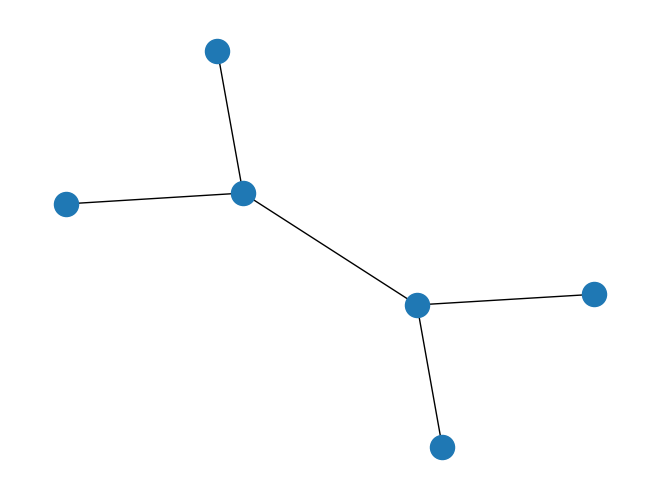

In [55]:
nx.draw(all_graphs[33])

In [68]:
idx = 12
G = all_graphs[idx]
add_weights(G, 'unweighted')
maxcut_val = get_maximum_cut(G)
max_matching = get_maximum_matching
n=G.number_of_nodes()
for k in range(1, n//2+1):
    max_k_cut = get_maximum_k_cut(G, k)
    G_k = get_wedge_graph(G, k)
    A_k = nx.adjacency_matrix(G_k).toarray()
    L_k = nx.laplacian_matrix(G_k).toarray()
    K_k = A_k + np.diag(np.diag(L_k))
    qmc_eigvals,_ = np.linalg.eigh(L_k)
    if np.max(np.real(qmc_eigvals)) > max_k_cut+k+TOL:
        print('fail', idx)
        break

fail 12


In [272]:
for idx in tqdm(two_vc_fc_idxs[1:10000]):
    G = all_graphs[idx]
    n=G.number_of_nodes()
    Ga = get_wedge_graph(G, n//2)
    Gb = get_wedge_graph(G, n//2-1)
    Aa = nx.adjacency_matrix(Ga).toarray()
    Ab = nx.adjacency_matrix(Gb).toarray()
    La = nx.laplacian_matrix(Ga).toarray()
    Lb = nx.laplacian_matrix(Gb).toarray()
    Ka = Aa + np.diag(np.diag(La))
    Kb = Ab + np.diag(np.diag(Lb))
    if get_maximum_eigval(Ka) < get_maximum_eigval(Kb) + 1 - TOL:
        print(f'{idx} fail!')
        break

100%|██████████| 9999/9999 [07:35<00:00, 21.93it/s]


In [273]:
for idx in tqdm(two_vc_fc_idxs[10:10000]):
    G = all_graphs[idx]
    n=G.number_of_nodes()
    Ga = get_wedge_graph(G, n//2)
    Gb = get_wedge_graph(G, n//2-2)
    Aa = nx.adjacency_matrix(Ga).toarray()
    Ab = nx.adjacency_matrix(Gb).toarray()
    La = nx.laplacian_matrix(Ga).toarray()
    Lb = nx.laplacian_matrix(Gb).toarray()
    Ka = Aa + np.diag(np.diag(La))
    Kb = Ab + np.diag(np.diag(Lb))
    if get_maximum_eigval(Ka) < get_maximum_eigval(Kb) + 2 - TOL:
        print(f'{idx} fail!')
        break

100%|██████████| 9990/9990 [05:55<00:00, 28.14it/s]


In [863]:
def check_valid_matching(G, matching):
    for e1 in matching:
        for e2 in matching:
            if e1 != e2 and set(e1).intersection(set(e2)):
                return False
    return True

def get_all_matchings(G):
    n=G.number_of_nodes()
    V = G.nodes
    E = G.edges
    match_sizes = range(1, int(np.ceil(n/2))+1)
    matchings = {match_size: [] for match_size in match_sizes}
    # returns list [(size matching, [list of matchings at that size])]
    for match_size in match_sizes:
        for subset in combinations(E, match_size):
            if check_valid_matching(G, subset): matchings[match_size].append(subset)
    
    return {k:v for k,v in matchings.items() if v}

def get_maximum_matching_bitstrings(G):
    n=G.number_of_nodes()
    match_bits = [(0,1),(1,0)]
    all_matchings = get_all_matchings(G)
    maximum_matchings = all_matchings[max(all_matchings.keys())]
    maximum_matching_size = len(maximum_matchings[0])
    maximum_matching_bitstrings = []
    for maximum_matching in maximum_matchings:
        idxs = np.array(maximum_matching).flatten()
        # cartesian product of k lists of ((0,1),(1,0))
        for bs in product(match_bits, repeat=maximum_matching_size):
            bitstring = np.zeros(n)
            bitstring[idxs] = np.array(bs).flatten()
            maximum_matching_bitstrings.append(bitstring)
    return maximum_matching_bitstrings  

In [179]:
def average_neighbor_degree_matrix(G):

    n = G.number_of_nodes()
    degrees = dict(G.degree())
    avg_neighbor_degrees = []

    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            avg_neighbor_degree = np.mean([degrees[neighbor] for neighbor in neighbors])
        else:
            avg_neighbor_degree = 0
        avg_neighbor_degrees.append(avg_neighbor_degree)

    return np.diag(avg_neighbor_degrees)

def average_next_nearest_neighbor_matrix(G):
    
    n = G.number_of_nodes()
    degrees = dict(G.degree())
    avg_next_nearest_neighbors = []

    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        next_nearest_neighbors = []
        for neighbor in neighbors:
            next_nearest_neighbors += list(G.neighbors(neighbor))
        next_nearest_neighbors = set(next_nearest_neighbors) - set(neighbors) - {node}
        if next_nearest_neighbors:
            avg_next_nearest_neighbor = np.mean([degrees[neighbor] for neighbor in next_nearest_neighbors])
        else:
            avg_next_nearest_neighbor = 0
        avg_next_nearest_neighbors.append(avg_next_nearest_neighbor)

    return np.diag(avg_next_nearest_neighbors)

In [203]:
def floyd_warshall_shortest_paths(G):
    nodes = list(G.nodes())
    n = len(nodes)
    dist = {node: {node: float('inf') for node in nodes} for node in nodes}
    
    for node in nodes:
        dist[node][node] = 0
    
    for u, v in G.edges():
        dist[u][v] = 1
        dist[v][u] = 1
    
    for k in nodes:
        for i in nodes:
            for j in nodes:
                if dist[i][j] > dist[i][k] + dist[k][j]:
                    dist[i][j] = dist[i][k] + dist[k][j]
    
    return dist

def closeness_centrality_matrix(G):
    shortest_paths = floyd_warshall_shortest_paths(G)
    centralities = []
    for u in G.nodes():
        val = 0 
        for v in G.nodes():
            if u != v:
                val += shortest_paths[u][v]
        centralities.append(1/val)
    return np.diag(centralities)

In [210]:
n = 9
G= nx.cycle_graph(n)
m=G.number_of_edges()
wedge_G = get_wedge_graph(G, n//2)
L = nx.laplacian_matrix(wedge_G).toarray()
A = nx.adjacency_matrix(wedge_G).toarray()
D = np.diag(np.diag(L))
nD = average_neighbor_degree_matrix(wedge_G)
nnD  = average_next_nearest_neighbor_matrix(wedge_G)
cc = closeness_centrality_matrix(wedge_G)
K = A + D
eigvals, eigvecs = np.linalg.eigh(K)
print('opt:', np.max(eigvals))
print('gersheg:', np.max(np.sum(np.abs(K), axis=0)))
print('bound:', m+n//2)
print('max degree:', np.max(D))

#print(K)

Mat = K
Mat = (D@cc) @ K @ np.linalg.inv(D@cc)
#print(Mat)

print(np.max(np.sum(np.abs(Mat), axis=0)), )


opt: 12.415162512442866
gersheg: 16
bound: 13
max degree: 8
14.088657564996248


In [992]:
def check_opt_state_matching(G):
    n = G.number_of_nodes()
    E = G.edges
    V = list(G.nodes)
    maximum_matching_bitstrings = get_maximum_matching_bitstrings(G)
    best_qmc_and_epr_eigvecs = get_best_qmc_and_epr_eigvecs(G)
    epr_sector, qmc_sector = best_qmc_and_epr_eigvecs['best_epr_sector'], best_qmc_and_epr_eigvecs['best_qmc_sector']
    epr_eigvecs, qmc_eigvecs = best_qmc_and_epr_eigvecs['best_epr_eigvecs'], best_qmc_and_epr_eigvecs['best_qmc_eigvecs']
    epr_idx_to_bitstring_map = {idx: bitstring for idx, bitstring in enumerate(combinations(V, epr_sector))}
    qmc_idx_to_bitstring_map = {idx: bitstring for idx, bitstring in enumerate(combinations(V, qmc_sector))}
    
    for eigvec in epr_eigvecs:
        for idx, val in enumerate(eigvec):
            if val > TOL:
                bitstring_idxs = epr_idx_to_bitstring_map.get(idx)
                if bitstring_idxs is None:
                    continue
                bitstring = np.zeros(n)
                bitstring[np.array([V.index(v) for v in bitstring_idxs])] = 1
                if not np.any(np.all(bitstring == maximum_matching_bitstrings, axis=1)):
                    print(f'invalid matching {bitstring}')
                    print(eigvec)
                    return False

    for eigvec in qmc_eigvecs:
        for idx, val in enumerate(eigvec):
            if val > TOL:
                bitstring_idxs = qmc_idx_to_bitstring_map.get(idx)
                if bitstring_idxs is None:
                    continue
                bitstring = np.zeros(n)
                bitstring[np.array([V.index(v) for v in bitstring_idxs])] = 1
                if not np.any(np.all(bitstring == maximum_matching_bitstrings, axis=1)):
                    print(f'invalid matching {bitstring}')
                    return False

    return True

In [995]:
n=7
G = nx.cycle_graph(n)
G.add_edge(0,2)
add_weights(G, 'unweighted')
check_opt_state_matching(G)

invalid matching [1. 1. 1. 0. 0. 0. 0.]
[0.02318037 0.09905151 0.09905151 0.15405293 0.08936572 0.04147457
 0.24128151 0.12455638 0.25065651 0.12455638 0.25558082 0.04147457
 0.25065651 0.15405293 0.09057213 0.08936572 0.19381934 0.15559875
 0.36529327 0.36529327 0.15559875 0.19381934 0.09057213 0.05716332
 0.09928968 0.15524935 0.25558082 0.18519243 0.09928968 0.18519243
 0.12551799 0.15524935 0.02978404 0.05716332 0.02978404]


False

In [996]:
n=7
G = nx.cycle_graph(n)
G.add_edge(0,2)
add_weights(G, 'unweighted')
eigvals, eigvecs = np.linalg.eigh(generate_H_Phi_minus(G))
#print(np.round(eigvals,4))
print(np.max(eigvals))
print(get_statevector_as_braket(eigvecs[:,-1], n))
G_k = get_wedge_graph(G,int(np.floor(n/2)))
A_k = nx.adjacency_matrix(G_k).toarray()
L_k = nx.laplacian_matrix(G_k).toarray()
K_k =A_k + np.diag(np.diag(L_k))
print(np.round(np.linalg.eigh(K_k)[0],4))
epr_eigvecs = np.linalg.eigh(K_k)[1]
qmc_eigvecs = np.linalg.eigh(L_k)[1]
print(np.round(epr_eigvecs[:,-1],4))


10.546155880542479
['-0.0298|0000111>', '-0.0993|0001011>', '-0.0993|0001101>', '-0.0298|0001110>', '-0.0001|0001111>', '-0.1556|0010011>', '-0.3653|0010101>', '-0.1552|0010110>', '-0.0004|0010111>', '-0.1938|0011001>', '-0.1852|0011010>', '-0.0007|0011011>', '-0.0572|0011100>', '-0.0006|0011101>', '-0.0002|0011110>', '-0.0906|0100011>', '-0.2556|0100101>', '-0.1255|0100110>', '-0.0004|0100111>', '-0.2413|0101001>', '-0.2556|0101010>', '-0.0011|0101011>', '-0.0906|0101100>', '-0.0011|0101101>', '-0.0004|0101110>', '-0.0991|0110001>', '-0.1541|0110010>', '-0.0007|0110011>', '-0.1246|0110100>', '-0.0017|0110101>', '-0.0009|0110110>', '-0.0415|0111000>', '-0.0007|0111001>', '-0.0008|0111010>', '-0.0003|0111100>', '-0.0572|1000011>', '-0.1852|1000101>', '-0.1552|1000110>', '-0.0002|1000111>', '-0.1938|1001001>', '-0.3653|1001010>', '-0.0006|1001011>', '-0.1556|1001100>', '-0.0007|1001101>', '-0.0004|1001110>', '-0.0894|1010001>', '-0.2507|1010010>', '-0.0004|1010011>', '-0.2507|1010100>', 

In [941]:
for n in [3,5,7,9,11]:
    G=nx.cycle_graph(n)
    print(check_opt_state_matching(G))

True
True
invalid matching [1. 1. 1. 0. 0. 0. 0.]
False
invalid matching [1. 1. 1. 1. 0. 0. 0. 0. 0.]
False
invalid matching [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
False


In [926]:
for idx, G in enumerate(two_vc_fc_graphs):
    if not check_opt_state_matching(G):
        print(f'failed for graph {idx}')
        break

invalid matching [1. 0. 1. 1. 0. 0. 0.]
failed for graph 9


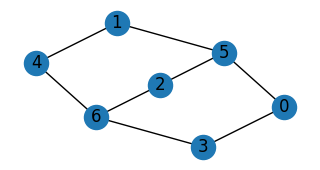

In [939]:
G = two_vc_fc_graphs[9]
plt.figure(figsize=(3,1.5))
nx.draw(G,with_labels=True)

In [940]:
n = G.number_of_nodes()
E = G.edges
V = list(G.nodes)
maximum_matching_bitstrings = get_maximum_matching_bitstrings(G)
best_qmc_and_epr_eigvecs = get_best_qmc_and_epr_eigvecs(G)
epr_sector, qmc_sector = best_qmc_and_epr_eigvecs['best_epr_sector'], best_qmc_and_epr_eigvecs['best_qmc_sector']
epr_eigvecs, qmc_eigvecs = best_qmc_and_epr_eigvecs['best_epr_eigvecs'], best_qmc_and_epr_eigvecs['best_qmc_eigvecs']
epr_idx_to_bitstring_map = {idx: bitstring for idx, bitstring in enumerate(combinations(V, epr_sector))}
qmc_idx_to_bitstring_map = {idx: bitstring for idx, bitstring in enumerate(combinations(V, qmc_sector))}

for matching in get_all_matchings(G)[3]:
    print(matching)

epr_eigvecs

((0, 3), (1, 4), (2, 5))
((0, 3), (1, 4), (2, 6))
((0, 3), (1, 5), (2, 6))
((0, 3), (1, 5), (4, 6))
((0, 3), (2, 5), (4, 6))
((0, 5), (1, 4), (2, 6))
((0, 5), (1, 4), (3, 6))
((1, 4), (2, 5), (3, 6))


[array([0.23897736, 0.08077922, 0.36240777, 0.2410269 , 0.07805578,
        0.2410269 , 0.07805578, 0.10831027, 0.10831027, 0.05155759,
        0.18443972, 0.10831027, 0.18443972, 0.10831027, 0.05155759,
        0.18443972, 0.22648967, 0.18443972, 0.22648967, 0.05316656,
        0.12189606, 0.05155759, 0.12189606, 0.23897736, 0.12189606,
        0.07805578, 0.07472653, 0.36240777, 0.22648967, 0.08077922,
        0.22648967, 0.12189606, 0.05316656, 0.05155759, 0.07805578])]

In [793]:
G=nx.path_graph(2)
unweighted_G(G)
H=generate_H_QMC(G)
eigvals, eigvecs = np.linalg.eigh(H)
max_eigval_idxs = np.where(np.abs(eigvals-max(eigvals))<TOL)[0]
for idx in max_eigval_idxs:
    print(get_statevector_as_braket(eigvecs[:,idx], 2))

['-0.7071|01>', '+0.7071|10>']


In [786]:
all_2vc_fc_graphs = [unweighted_G(G) for G in all_graphs if test_2vc_fc(G)]

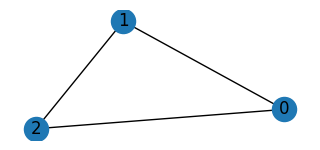

K statevectors
['-0.5774|001>', '-0.5774|010>', '-0.5774|100>']
['-0.5774|011>', '-0.5774|101>', '-0.5774|110>']
L statevectors
['-0.8059|011>', '+0.5164|101>', '+0.2895|110>']
['+0.1310|011>', '+0.6325|101>', '-0.7634|110>']
['+0.1310|001>', '+0.6325|010>', '-0.7634|100>']
['-0.8059|001>', '+0.5164|010>', '+0.2895|100>']


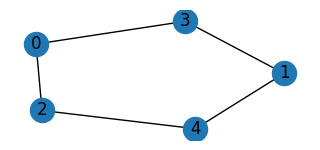

K statevectors
['-0.4132|00011>', '-0.1711|00101>', '-0.4132|00110>', '-0.1711|01001>', '-0.1711|01010>', '-0.4132|01100>', '-0.4132|10001>', '-0.1711|10010>', '-0.1711|10100>', '-0.4132|11000>']
['+0.4132|00111>', '+0.1711|01011>', '+0.1711|01101>', '+0.4132|01110>', '+0.4132|10011>', '+0.1711|10101>', '+0.1711|10110>', '+0.4132|11001>', '+0.1711|11010>', '+0.4132|11100>']
L statevectors
['+0.0653|00011>', '-0.1960|00101>', '-0.3824|00110>', '-0.1745|00111>', '-0.1461|01001>', '+0.1057|01010>', '-0.0208|01011>', '+0.5534|01100>', '+0.0538|01101>', '+0.1415|01110>', '+0.2767|10001>', '+0.2114|10010>', '+0.1409|10011>', '+0.0249|10100>', '+0.0540|10101>', '-0.0204|10110>', '-0.5130|11000>', '-0.0535|11001>', '-0.0667|11010>', '-0.0544|11100>']
['+0.5872|00011>', '+0.0920|00101>', '-0.4384|00110>', '+0.0194|00111>', '-0.1675|01001>', '-0.1955|01010>', '+0.0023|01011>', '+0.1222|01100>', '-0.0060|01101>', '-0.0157|01110>', '-0.5117|10001>', '+0.0467|10010>', '-0.0157|10011>', '+0.2243|101

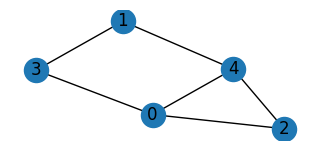

K statevectors
['-0.4763|00111>', '-0.1721|01011>', '-0.2636|01101>', '-0.3382|01110>', '-0.3217|10011>', '-0.1633|10101>', '-0.2636|10110>', '-0.3217|11001>', '-0.1721|11010>', '-0.4763|11100>']
['-0.4763|00011>', '-0.1721|00101>', '-0.3217|00110>', '-0.2636|01001>', '-0.1633|01010>', '-0.3217|01100>', '-0.3382|10001>', '-0.2636|10010>', '-0.1721|10100>', '-0.4763|11000>']
L statevectors
['+0.5586|00011>', '+0.0991|00101>', '-0.0991|00110>', '-0.2437|01001>', '-0.2158|01010>', '-0.0991|01100>', '-0.4140|10001>', '-0.2437|10010>', '+0.0991|10100>', '+0.5586|11000>']
['+0.5586|00111>', '+0.0991|01011>', '-0.2437|01101>', '-0.4140|01110>', '-0.0991|10011>', '-0.2158|10101>', '-0.2437|10110>', '-0.0991|11001>', '+0.0991|11010>', '+0.5586|11100>']


In [791]:
for G in all_2vc_fc_graphs[:3]:
    n=G.number_of_nodes()
    plt.figure(figsize=(3, 1.3))
    nx.draw(G, with_labels=True)
    plt.show()
    K, L = generate_H_Phi_minus(G), generate_H_QMC(G)
    K_eigvals, K_eigvecs = np.linalg.eigh(K)
    L_eigvals, L_eigvecs = np.linalg.eigh(L)
    max_K_eigvals = np.where(np.abs(K_eigvals - max(K_eigvals)) < TOL)[0]
    max_L_eigvals = np.where(np.abs(L_eigvals - max(L_eigvals)) < TOL)[0]
    print('K statevectors')
    for idx in max_K_eigvals:
        print(get_statevector_as_braket(K_eigvecs[:, idx], n))
    print('L statevectors')
    for idx in max_L_eigvals:
        print(get_statevector_as_braket(L_eigvecs[:, idx], n))
    

In [781]:
def get_wedge_graph(G, k):
    n=G.number_of_nodes()
    vertices  = list(G.nodes)
    Gk = nx.Graph()
    for subset_1 in combinations(vertices, k):
        for subset_2 in combinations(vertices, k):
            i = set(subset_1)  - set(subset_2)
            j = set(subset_2) - set(subset_1)
            # check if edge (i,j) is in edges of G
            if len(i) == 1 and len(j)==1 and G.has_edge(next(iter(i)),next(iter(j))):
                Gk.add_edge(subset_1, subset_2)
    return Gk

In [782]:
n=5
G = nx.star_graph(n)
n = G.number_of_nodes()
A = nx.adjacency_matrix(G).todense()
L = nx.laplacian_matrix(G).todense()
A_eigvals = np.linalg.eigvals(A)
print(f'n = {n}')
#print(f'A_eigvals={np.real(np.round(A_eigvals,2))}')

print('maxcut=', get_maximum_cut(G))
add_weights(G, 'unweighted')
H_EPR, H_QMC, H_YZ, nH_YZ = generate_H_EPR(G), generate_H_QMC(G), generate_H_YZ(G), -generate_H_YZ(G)
max_epr, max_qmc, max_yz, nmax_yz = get_maximum_eigval(H_EPR), get_maximum_eigval(H_QMC), get_maximum_eigval(H_YZ), get_maximum_eigval(nH_YZ)
print(f'max EPR={max_epr:.2f}, max QMC={max_qmc:.2f}, max YZ={max_yz:.2f}, max nYZ={nmax_yz:.2f}')

for k in range(1,int(np.floor(n/2))+1):
    print(f'k={k}')
    Gk = get_wedge_graph(G, k)
    Lk = nx.laplacian_matrix(Gk).todense()
    Ak = nx.adjacency_matrix(Gk).todense()
    ADk = Ak+np.diag(np.diag(Lk))
    max_Lk_eigval  = np.real(np.max(np.linalg.eigvals(Lk)))
    max_Ak_eigval = np.real(np.max(np.linalg.eigvals(Ak)))
    max_ADk_eigval = np.real(np.max(np.linalg.eigvals(ADk)))
    print(f'max(L)={max_Lk_eigval:.2f}, max(A)={max_Ak_eigval:.2f}, max(A+D)={max_ADk_eigval:.2f}')
    

n = 6
maxcut= 5
max EPR=6.00, max QMC=6.00, max YZ=3.00, max nYZ=3.00
k=1
max(L)=6.00, max(A)=2.24, max(A+D)=6.00
k=2
max(L)=6.00, max(A)=2.83, max(A+D)=6.00
k=3
max(L)=6.00, max(A)=3.00, max(A+D)=6.00


In [683]:
def find_max_ham_weight_sector_with_opt(G):
    n=G.number_of_nodes()
    op_names = ['L', 'A', '-A', 'A+D']
    max_sectors = {op:[0,0] for op in op_names}
    for k in range(1,int(np.floor(n/2))+1):
        Gk = get_wedge_graph(G, k)
        Lk = nx.laplacian_matrix(Gk).todense()
        Ak = nx.adjacency_matrix(Gk).todense()
        nAk = -nx.adjacency_matrix(Gk).todense()
        ADk = Ak+np.diag(np.diag(Lk))
        for op, name in zip([Lk, Ak, nAk, ADk], op_names):
            max_eigval = np.real(np.max(np.linalg.eigvals(op)))
            if max_eigval > max_sectors[name][1] +TOL:
                max_sectors[name][0] = k
                max_sectors[name][1] = max_eigval
    return max_sectors

In [766]:
for idx, G in tqdm(enumerate(get_five_node_fc_graphs())):
    n=G.number_of_nodes()
    max_cut_ham_weights = get_maximum_cut(G, return_partitions=True)[1]
    max_cut_ham_weight = min(max_cut_ham_weight, n-max_cut_ham_weight)
    max_ham_weight_sector = find_max_ham_weight_sector_with_opt(G)
    # see if all opts are in max han weght setor
    if not all([max_ham_weight_sector[name][0] in max_cut_ham_weights for name in ['L']]):
        print(f'{idx} failed')
        print(max_ham_weight_sector, max_cut_ham_weights)
        break

0it [00:00, ?it/s]

8it [00:00, 145.25it/s]


In [755]:
for idx, G in tqdm(enumerate(all_graphs)):
    n=G.number_of_nodes()
    max_cut_ham_weights = get_maximum_cut(G, return_partitions=True)[1]
    max_cut_ham_weight = min(max_cut_ham_weight, n-max_cut_ham_weight)
    max_ham_weight_sector = find_max_ham_weight_sector_with_opt(G)
    # see if all opts are in max han weght setor
    if not all([max_ham_weight_sector[name][0] in max_cut_ham_weights for name in ['L']]):
        print(f'{idx} failed')
        print(max_ham_weight_sector, max_cut_ham_weights)
        break

79it [00:00, 189.34it/s]

79 failed
{'L': [3, 7.999999999999974], 'A': [3, 4.440362991045999], '-A': [3, 3.285392544476073], 'A+D': [3, 9.174755615407234]} [2]


In [777]:
len([G for G in all_graphs if test_2vc_fc(G)])

410

In [776]:
for idx, G in tqdm(enumerate(all_graphs)):
    if test_2vc_fc(G):
        n=G.number_of_nodes()
        max_cut_ham_weights = get_maximum_cut(G, return_partitions=True)[1]
        max_cut_ham_weight = min(max_cut_ham_weight, n-max_cut_ham_weight)
        max_ham_weight_sector = find_max_ham_weight_sector_with_opt(G)
        # see if all opts are in max han weght setor
        if not all([max_ham_weight_sector[name][0] in max_cut_ham_weights for name in ['L']]):
            print(f'{idx} failed')
            print(max_ham_weight_sector, max_cut_ham_weights)
            break

12112it [00:04, 2696.50it/s]


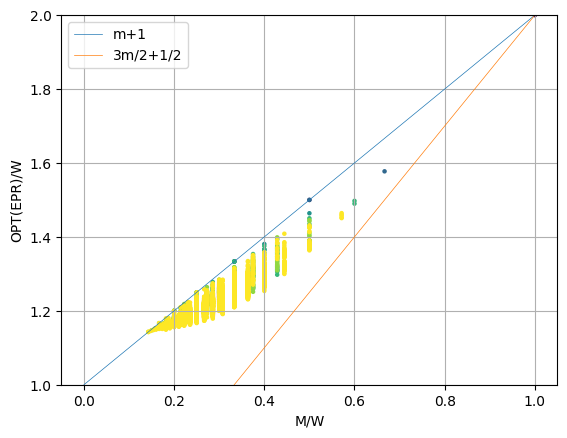

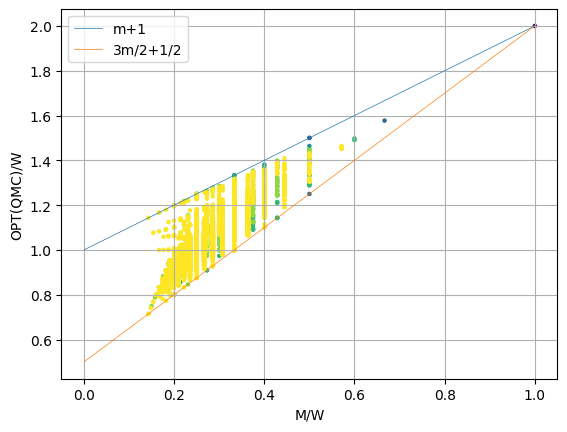

In [456]:
plt.scatter(ms, opt_eprs, c=ns, s=5)  
xs = np.linspace(0,1,100)
upper_bound=1+xs
lower_bound = 1.5*(xs) +.5
#lower_bound_1 = xs**2+1
#lower_bound_2 = 2+4*(xs-1)/3
#lower_bound_3 = 1+xs/2
plt.plot(xs, upper_bound, label='m+1', linewidth=.5)
plt.plot(xs, lower_bound, label='3m/2+1/2', linewidth=.5)
#plt.plot(xs, lower_bound_1, label='m^2+1', linewidth=.5)
#plt.plot(xs, lower_bound_2, label='2+4(m-1)/3', linewidth=.5)
#plt.plot(xs, lower_bound_3, label='1+m/2', linewidth=.5)
plt.legend()
plt.xlabel('M/W')
plt.ylabel('OPT(EPR)/W')
plt.ylim(1,2)
plt.grid()
plt.show()

plt.scatter(ms, opts, c=ns, s=5)  
xs = np.linspace(0,1,100)
upper_bound=1+xs
lower_bound = 1.5*(xs) +.5
plt.plot(xs, upper_bound, label='m+1', linewidth=.5)
plt.plot(xs, lower_bound, label='3m/2+1/2', linewidth=.5)
plt.legend()
plt.xlabel('M/W')
plt.ylabel('OPT(QMC)/W')
plt.grid()
plt.show()



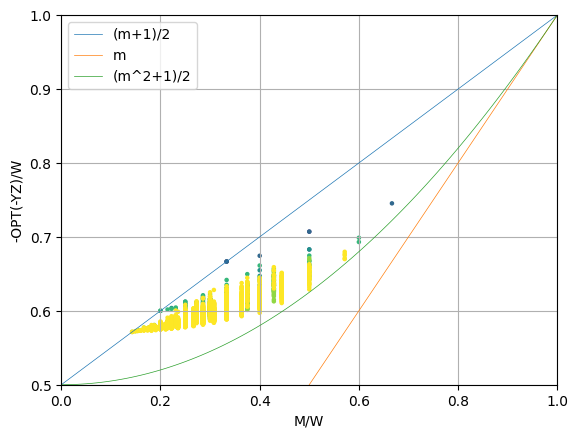

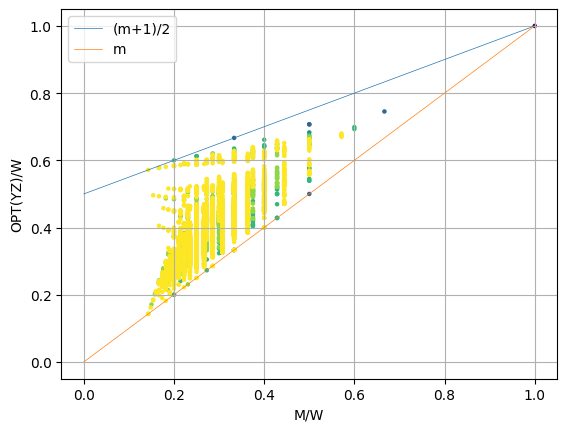

In [457]:
plt.scatter(ms, -min_yz_energies/total_weights, c=ns, s=5)  
xs = np.linspace(0,1,100)
upper_bound=(1+xs)/2
lower_bound = xs
lower_bound_1 = (xs**2+1)/2
#lower_bound_2 = 1+(xs-1)*.8
#lower_bound_3 = 1/2+xs/4
plt.plot(xs, upper_bound, label='(m+1)/2', linewidth=.5)
plt.plot(xs, lower_bound, label='m', linewidth=.5)
plt.plot(xs, lower_bound_1, label='(m^2+1)/2', linewidth=.5)
#plt.plot(xs, lower_bound_2, label='1+2(m-1)/3', linewidth=.5)
#plt.plot(xs, lower_bound_3, label='1/2+m/4', linewidth=.5)
plt.legend()
plt.ylim(.5,1)
plt.xlim(0,1)
plt.xlabel('M/W')
plt.ylabel('-OPT(-YZ)/W')
plt.grid()
plt.show()

plt.scatter(ms, yz_energies/total_weights, c=ns, s=5)  
xs = np.linspace(0,1,100)
upper_bound=(1+xs)/2
lower_bound = xs
plt.plot(xs, upper_bound, label='(m+1)/2', linewidth=.5)
plt.plot(xs, lower_bound, label='m', linewidth=.5)
plt.legend()
plt.xlabel('M/W')
plt.ylabel('OPT(YZ)/W')
plt.grid()
plt.show()

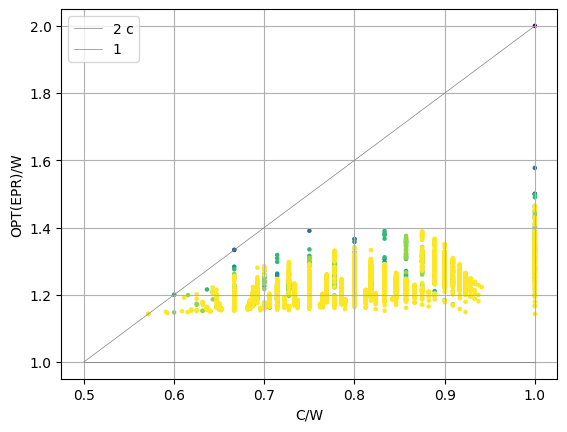

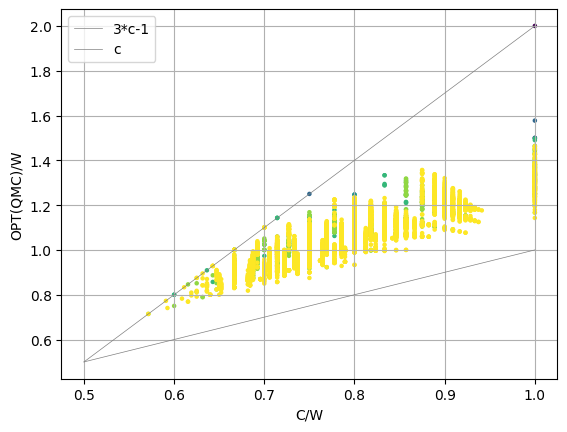

In [452]:
plt.scatter(cs, opt_eprs, c=ns, s=5)  
xs = np.linspace(.5,1,100)
upper_bound=2*xs
lower_bound = np.ones_like(xs)
plt.plot(xs, upper_bound, label='2 c', linewidth=.5, color='grey')
plt.plot(xs, lower_bound, label='1', linewidth=.5, color='grey')
plt.legend()
plt.xlabel('C/W')
plt.ylabel('OPT(EPR)/W')
plt.grid()
plt.show()

plt.scatter(cs, opts, c=ns, s=5)  
xs = np.linspace(.5,1,100)
upper_bound=3*xs-1
lower_bound = xs
plt.plot(xs, upper_bound, label='3*c-1', linewidth=.5, color='grey')
plt.plot(xs, lower_bound, label='c', linewidth=.5, color='grey')
plt.legend()
plt.xlabel('C/W')
plt.ylabel('OPT(QMC)/W')
plt.grid()
plt.show()

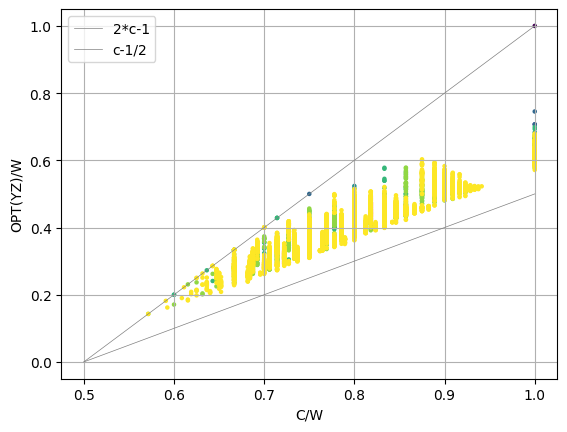

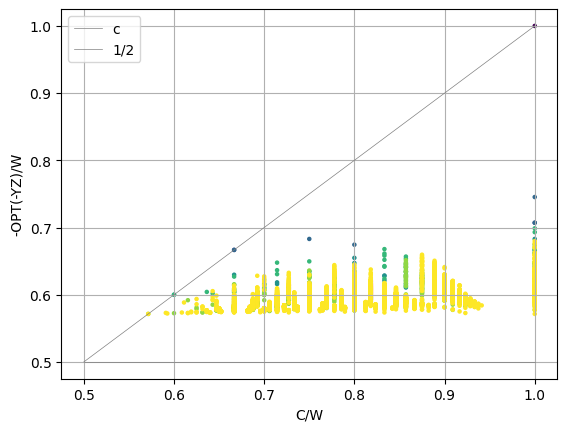

In [478]:
plt.scatter(cs, yz_energies/total_weights, c=ns, s=5)  
xs = np.linspace(.5,1,100)
upper_bound=2*xs-1
lower_bound = xs-1/2
plt.plot(xs, upper_bound, label='2*c-1', linewidth=.5, color='grey')
plt.plot(xs, lower_bound, label='c-1/2', linewidth=.5, color='grey')
plt.legend()
plt.xlabel('C/W')
plt.ylabel('OPT(YZ)/W')
plt.grid()
plt.show()

plt.scatter(cs, -min_yz_energies/total_weights, c=ns, s=5)  
xs = np.linspace(.5,1,100)
upper_bound=xs
lower_bound = np.ones_like(xs)/2
plt.plot(xs, upper_bound, label='c', linewidth=.5, color='grey')
plt.plot(xs, lower_bound, label='1/2', linewidth=.5, color='grey')
plt.legend()
plt.xlabel('C/W')
plt.ylabel('-OPT(-YZ)/W')
plt.grid()
plt.show()

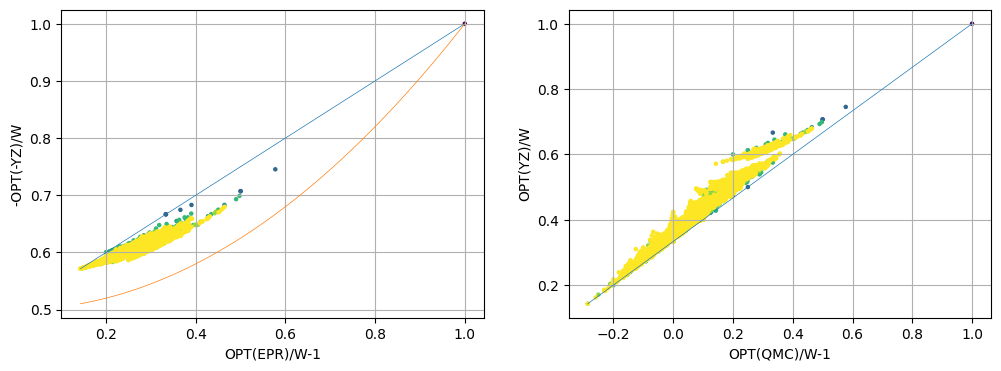

In [482]:
fig, axs= plt.subplots(1,2, figsize=(12,4))
ax_0_xs = np.linspace(min(opt_eprs-1),max(opt_eprs-1),100)
axs[0].plot(ax_0_xs, .5+.5*ax_0_xs, label='', linewidth=.5)
axs[0].plot(ax_0_xs, .5+(ax_0_xs)**2/2, linewidth=.5)
axs[0].scatter(opt_eprs-1, -min_yz_energies/total_weights, c=ns, s=5)
axs[0].grid()
axs[0].set_xlabel('OPT(EPR)/W-1')
axs[0].set_ylabel('-OPT(-YZ)/W')
ax_1_xs = np.linspace(min(opts-1),max(opt_eprs-1),100)
axs[1].plot(ax_1_xs, 1/3+2*ax_1_xs/3, label='', linewidth=.5)
axs[1].scatter(opts-1, yz_energies/total_weights, c=ns, s=5)
axs[1].grid()
axs[1].set_xlabel('OPT(QMC)/W-1')
axs[1].set_ylabel('OPT(YZ)/W')
plt.show()

In [484]:
from itertools import product

In [641]:
def get_wedge_A_eigenenergies(G):
    n=G.number_of_nodes()
    A = nx.adjacency_matrix(G).todense()
    eigvals = np.linalg.eigvals(A)
    
    energies  = []
    for idx, j_array in enumerate(product([0, 1], repeat=n)):
        energy = 0
        for j in np.where(j_array)[0]:
            energy += eigvals[j]
        energies.append(energy)
    return np.array(energies)

G = nx.cycle_graph(4)
A = nx.adjacency_matrix(G).todense()
eigvals = np.linalg.eigvals(A)
print(np.round(np.real(eigvals),2))
add_weights(G, 'unweighted')
H = generate_H_YZ(G)
print(np.round(np.sort(np.real(np.linalg.eigvals(H))),4))
print(np.round(np.sort(np.real(get_wedge_A_eigenenergies(G))),4))
np.allclose(np.sort(np.real(np.linalg.eigvals(H))), np.sort(np.real(get_wedge_A_eigenenergies(G))))

[-2.  2. -0. -0.]
[-2.8284 -2.     -2.     -0.     -0.     -0.     -0.      0.      0.
  0.      0.      0.      0.      2.      2.      2.8284]
[-2. -2. -2. -2. -0. -0. -0. -0. -0. -0. -0.  0.  2.  2.  2.  2.]


False

In [489]:
def get_path_A_eigenenergies(n, j):
    return  -2 * np.cos((np.pi * (j+1)) / (n+1))    

def get_path_wedge_A_eigenenergies(n):
    energies  = np.zeros(2**n)
    for idx, j_array in enumerate(product([0, 1], repeat=n)):
        for j in np.where(j_array)[0]:
            energies[idx] += get_path_A_eigenenergies(n, j)
    return energies

np.round(get_path_wedge_A_eigenenergies(4),4)

array([ 0.    ,  1.618 ,  0.618 ,  2.2361, -0.618 ,  1.    , -0.    ,
        1.618 , -1.618 , -0.    , -1.    ,  0.618 , -2.2361, -0.618 ,
       -1.618 , -0.    ])

In [493]:
G=nx.path_graph(4)
add_weights(G, 'unweighted')
H = generate_H_YZ(G)
eigvals, eigvecs = np.linalg.eigh(H)
np.round(eigvals,4)

array([-2.2361, -1.618 , -1.618 , -1.    , -0.618 , -0.618 ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.618 ,  0.618 ,  1.    ,  1.618 ,
        1.618 ,  2.2361])

In [249]:
G=nx.complete_graph(8)
add_weights(G, 'unweighted')
H = generate_H_YZ(G)
get_maximum_eigval(H)/G.number_of_edges(), get_maximum_cut(G)/G.number_of_edges()

(0.142857142857143, 0.5714285714285714)

[12111   995   994 12110   993 12093  1021 12109 11978 11484]


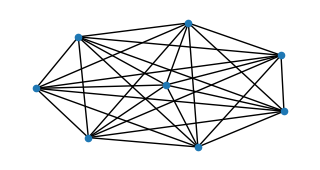

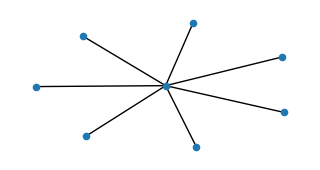

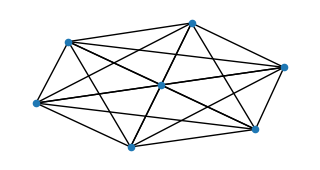

In [246]:
print(np.argsort(-min_yz_energies/total_weights)[:10])
plt.figure(figsize=(3, 1.5))
nx.draw(all_graphs[12111], node_size=20)
plt.figure(figsize=(3, 1.5))
nx.draw(all_graphs[995], node_size=20)
plt.figure(figsize=(3, 1.5))
nx.draw(all_graphs[994], node_size=20)

(array([    0,     2,     5,     8,    19,    29,    46,    51,    85,
         105,   109,   119,   138,   141,   360,   384,   877,   994,
        1531,  1540,  1573,  1778,  1784,  3558,  5582,  5588,  5591,
        5592,  5621,  5715,  5741,  5771,  6416,  7244,  8608,  8686,
       11487, 11493, 11533, 11780, 11978, 12111]),)


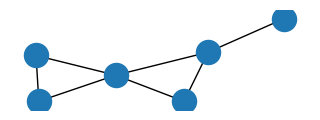

In [215]:
print(np.where(np.abs(yz_energies/total_weights - (2*cs-1))<=TOL))
plt.figure(figsize=(3,1))
nx.draw(all_graphs[51])

# all disjoint sums of complete graphs (signed sums of cliques?)

(array([    0,     2,     8,    29,   141,   994, 12111]),)


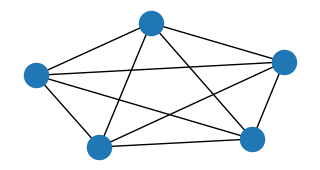

In [ ]:
print(np.where(np.abs(-min_yz_energies/total_weights - cs)<=TOL))
plt.figure(figsize=(3,1.5))
nx.draw(all_graphs[29])
# all complete graphs

In [124]:
biggest_n = 7

In [121]:
small_graphs = [G for G in all_graphs if G.number_of_nodes() <= biggest_n]
opt_Gs, opt_Gcs = [],[]
for G in small_graphs:
    add_weights(G, 'unweighted')
    H= generate_H_EPR(G)
    opt_Gs.append(get_maximum_eigval(H))
    #complement graph
    Gc = nx.complement(G)
    add_weights(Gc, 'unweighted')
    Hc = generate_H_EPR(Gc)
    opt_Gcs.append(get_maximum_eigval(Hc))

In [128]:
opt_Gs, opt_Gcs = np.array(opt_Gs), np.array(opt_Gcs)

In [148]:
#find max of opt_Gs for the indexes whre ns=5
[(n,np.round(np.max((opt_Gs+opt_Gcs)[np.where(ns==n)[0]]),4)) for n in range(2, biggest_n+1)]

[(2, 2.0), (3, 5.0), (4, 10.0), (5, 14.0), (6, 20.7446), (7, 27.0)]

In [129]:
np.argmax(opt_Gs + opt_Gcs)

353

In [130]:
opt_Gs[353]+opt_Gcs[353]

27.000000000000007

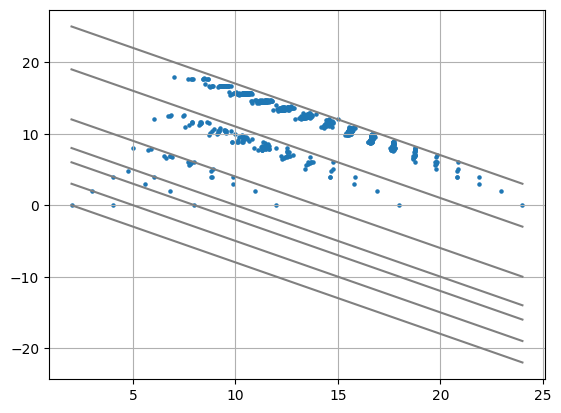

In [143]:
xs= np.linspace(2,biggest_n**2/2-1/2,100)
plt.plot(xs, 2-xs, label='y=x', color='grey') 
plt.plot(xs, 5-xs, label='y=x', color='grey') 
plt.plot(xs, 8-xs, label='y=x', color='grey') 
plt.plot(xs, 10-xs, label='y=x', color='grey') 
plt.plot(xs, 14-xs, label='y=x', color='grey') 
plt.plot(xs, 21-xs, label='y=x', color='grey') 
plt.plot(xs, 27-xs, label='y=x', color='grey') 
plt.scatter(opt_Gs, opt_Gcs, s=5)
plt.grid()
plt.show()

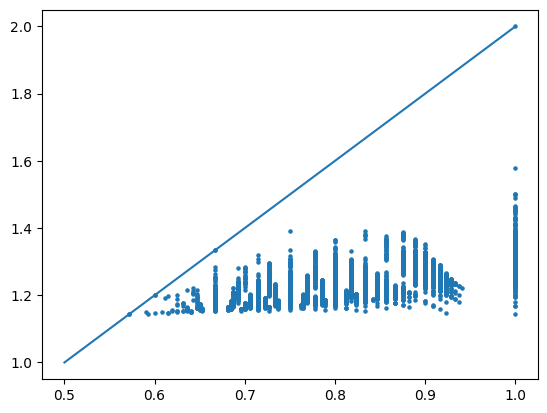

In [95]:
OPT_EPRS = opt_eprs * total_weights
OPT_QMCS  = opts * total_weights
xs = np.linspace(.5, 1, 100)
# plot y=3x-1
plt.plot(xs,2*xs,label='y=x')
#make an arbitrary line
#plt.plo
plt.scatter(cs, opt_eprs, s=5)

In [ ]:
# matrix square root
def matrix_sqrt(A):
    eigvals, eigvecs = np.linalg.eigh(A)
    sqrt_eigvals = np.sqrt(eigvals)
    return eigvecs @ np.diag(sqrt_eigvals) @ np.linalg.inv(eigvecs)

In [238]:
norm_H_F + norm_H_P

8.828427124746192

In [269]:
F = nx.cycle_graph(5)
add_weights(F, 'unweighted')
H_F = generate_H_EPR(F)
P = nx.cycle_graph(5)
add_weights(P, 'zero')
P.add_edge(0, 2)
P[0][2]['weight'] = 1
H_P = generate_H_EPR(P)
norm_H_F, norm_H_P = get_maximum_eigval(H_F), get_maximum_eigval(H_P)
r,s=.3,.9
t=1
AB_norm = get_maximum_eigval((1/t)*la.fractional_matrix_power(H_F, r)@la.fractional_matrix_power(H_P, s) + t* la.fractional_matrix_power(H_F, 1-r)@la.fractional_matrix_power(H_P, 1-s))
AB_norm**2



35.53606192389023

In [ ]:
import operator
import functools
import scipy.linalg as la

In [14]:
# https://github.com/jan-provaznik/departed/blob/main/departed/_ptrace.py
def ptrace(matrix, component_dims, keep):

    dims = list(map(int, component_dims))
    mask = list(map(int, map(bool, keep)))
    nsys = len(dims)
    index_trace = [ m for m in range(nsys) if not mask[m] ]
    index_carry = [ m for m in range(nsys) if     mask[m] ]
    
    width_trace = functools.reduce(operator.mul, 
        [ dims[m] for m in index_trace ], 1)
    width_carry = functools.reduce(operator.mul, 
        [ dims[m] for m in index_carry ], 1)
    
    system_axes = [ (m, m + nsys) for m in range(nsys) ]

    permutation = (
        [ system_axes[m][0] for m in index_trace ] + 
        [ system_axes[m][1] for m in index_trace ] + 
        [ system_axes[m][0] for m in index_carry ] + 
        [ system_axes[m][1] for m in index_carry ]
    )
    
    return (matrix
        .reshape(dims + dims)
        .transpose(permutation)
        .reshape(width_trace, width_trace, width_carry, width_carry)
        .trace()
        .reshape(width_carry, width_carry)
    )

def state_to_dm(state):
    return np.outer(state, state.conj())

In [52]:
phi_p_state = np.array([1, 0, 0, 1]) / np.sqrt(2)
phi_m_state = np.array([1, 0, 0, -1]) / np.sqrt(2)
psi_p_state = np.array([0, 1, 1, 0]) / np.sqrt(2)
psi_m_state = np.array([0, 1, -1, 0]) / np.sqrt(2)

bell_states = [phi_p_state, phi_m_state, psi_p_state, psi_m_state]

zero_state = np.array([1,0,0,0])
one_state = np.array([0,0,0,1])
zero_one_state = np.array([0,1,0,0])
one_zero_state = np.array([0,0,1,0])

prod_states = [zero_state, one_state, zero_one_state, one_zero_state]

bell_rhos = [state_to_dm(state) for state in bell_states]
prod_rhos = [state_to_dm(state) for state in prod_states]

In [27]:
def get_op_energy_on_edge(rho, ham_type='epr'):

    
    # Get the operator on the edge
    if ham_type == 'epr':
        op = (np.eye(4) + np.kron(X, X) - np.kron(Y, Y) + np.kron(Z, Z))/2
    elif ham_type == 'qmc':
        op = (np.eye(4) - np.kron(X, X) - np.kron(Y, Y) - np.kron(Z, Z))/2
    else:
        raise ValueError("ham_type must be either 'epr' or 'qmc'")
    
    # Calculate the energy
    return np.real(np.trace(rho @ op))

In [56]:
def concurrence(rho):
    yy_mat = np.fliplr(np.diag([-1, 1, 1, -1]))
    sigma = rho.dot(yy_mat).dot(rho.conj()).dot(yy_mat)
    w = np.sort(np.real(la.eigvals(sigma)))
    w = np.sqrt(np.maximum(w, 0.))
    return max(0.0, w[-1] - np.sum(w[0:-1]))

def random_density_matrix(dim=4):
    # Create a random complex matrix
    A = np.random.randn(dim, dim) + 1j * np.random.randn(dim, dim)
    # Make it Hermitian: H = A * A^\dagger
    H = A @ A.conj().T
    # Normalize to ensure trace = 1
    rho = H / np.trace(H)
    return rho

def von_neumann_entropy(rho):
    n=np.log2(rho.shape[0])
    log_rho = la.logm(rho)
    return -np.trace(rho @ log_rho)#/np.log(2**n)

von_neumann_entropy(ptrace(bell_rhos[0], [2,2], [1,0]))

0.6931471805599454

In [60]:
# get a bunch of random density matrices
n = 2
num_states = 10000
random_dms = [random_density_matrix(dim=2**n) for _ in range(num_states)]
tangles = [concurrence(rho)**2 for rho in random_dms]
vn_entropies = [von_neumann_entropy(ptrace(rho, [2,2], [1,0])) for rho in random_dms]

eprs_Es = [get_op_energy_on_edge(rho, 'qmc') for rho in random_dms]

for rho in bell_rhos + prod_rhos:
    tangles.append(concurrence(rho))
    eprs_Es.append(get_op_energy_on_edge(rho, 'qmc'))
    vn_entropies.append(von_neumann_entropy(ptrace(rho, [2,2], [1,0])))


/home/jamessud/anaconda3/envs/qiskit_qaoa/lib/python3.10/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)


In [61]:
tangles= np.array(tangles)
eprs_Es = np.array(eprs_Es)
vn_entropies = np.array(vn_entropies)

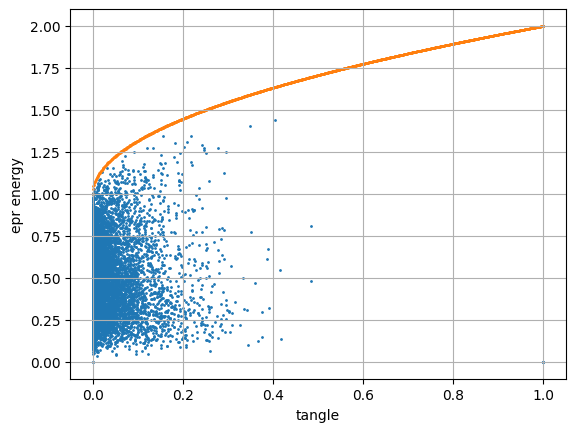

In [65]:
plt.scatter(tangles, eprs_Es, s=1)
#plot line 
#plt.plot([0,1],[1,2], color='red')
xs = np.linspace(0,1,1000)
ys = np.sqrt(xs)
plt.scatter(xs, 1+ys, s=1)
plt.xlabel('tangle')
plt.ylabel('epr energy')
plt.grid()

plt.show()

In [43]:
np.all(eprs_Es <= 1+np.sqrt(tangles)+TOL)

True

In [122]:
i_state = np.array([1, 1j])
i_state= i_state/np.linalg.norm(i_state)
i_state_dm = state_to_dm(i_state)
i_state_dm

array([[0.5+0.j , 0. -0.5j],
       [0. +0.5j, 0.5+0.j ]])

In [141]:
ptrace(repeated_kron([i_state_dm]*5), [2]*5, [1,0,0,0,0])

array([[0.5+0.j , 0. -0.5j],
       [0. +0.5j, 0.5+0.j ]])

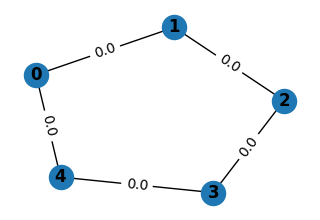

0.0


In [142]:
plot_eigvec_energy_on_edges(G, repeated_kron([i_state]*5), ham_type='EPR', e_scale='g')

In [168]:
def get_idx_vector(n, idxs):
    return np.array([1 if i in idxs else 0 for i in range(n)])

1 body rdms


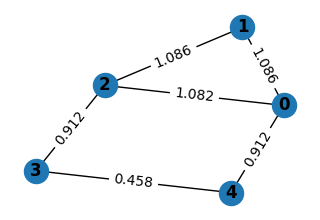

5.5360000000000005
-3
[[0.26 +0.j 0.004+0.j]
 [0.004+0.j 0.74 +0.j]]
[[0.115+0.j 0.007+0.j]
 [0.007+0.j 0.885+0.j]]
[[0.26 +0.j 0.004+0.j]
 [0.004+0.j 0.74 +0.j]]
[[ 0.544+0.j -0.001+0.j]
 [-0.001+0.j  0.456+0.j]]
[[ 0.544+0.j -0.001+0.j]
 [-0.001+0.j  0.456+0.j]]
2 body rdms
[[0.06+0.j 0.  +0.j 0.  +0.j 0.17+0.j]
 [0.  +0.j 0.2 +0.j 0.07+0.j 0.  +0.j]
 [0.  +0.j 0.07+0.j 0.06+0.j 0.  +0.j]
 [0.17+0.j 0.  +0.j 0.  +0.j 0.68+0.j]]
[[0.06+0.j 0.  +0.j 0.  +0.j 0.17+0.j]
 [0.  +0.j 0.06+0.j 0.07+0.j 0.  +0.j]
 [0.  +0.j 0.07+0.j 0.2 +0.j 0.  +0.j]
 [0.17+0.j 0.  +0.j 0.  +0.j 0.68+0.j]]
[[ 0.17+0.j -0.  +0.j  0.  +0.j  0.19+0.j]
 [-0.  +0.j  0.09+0.j -0.16+0.j  0.  +0.j]
 [ 0.  +0.j -0.16+0.j  0.38+0.j -0.  +0.j]
 [ 0.19+0.j  0.  +0.j -0.  +0.j  0.36+0.j]]
[[ 0.16+0.j -0.  +0.j -0.  +0.j  0.11+0.j]
 [-0.  +0.j  0.38+0.j -0.37+0.j -0.  +0.j]
 [-0.  +0.j -0.37+0.j  0.38+0.j -0.  +0.j]
 [ 0.11+0.j -0.  +0.j -0.  +0.j  0.07+0.j]]
1 body rdms


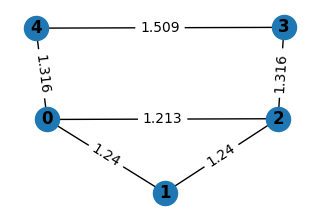

7.834
-1
[[0.766+0.j 0.   +0.j]
 [0.   +0.j 0.234+0.j]]
[[0.852+0.j 0.   +0.j]
 [0.   +0.j 0.148+0.j]]
[[0.766+0.j 0.   +0.j]
 [0.   +0.j 0.234+0.j]]
[[0.736+0.j 0.   +0.j]
 [0.   +0.j 0.264+0.j]]
[[0.736+0.j 0.   +0.j]
 [0.   +0.j 0.264+0.j]]
2 body rdms
[[0.71+0.j 0.  +0.j 0.  +0.j 0.22+0.j]
 [0.  +0.j 0.06+0.j 0.07+0.j 0.  +0.j]
 [0.  +0.j 0.07+0.j 0.14+0.j 0.  +0.j]
 [0.22+0.j 0.  +0.j 0.  +0.j 0.09+0.j]]
[[0.71+0.j 0.  +0.j 0.  +0.j 0.22+0.j]
 [0.  +0.j 0.14+0.j 0.07+0.j 0.  +0.j]
 [0.  +0.j 0.07+0.j 0.06+0.j 0.  +0.j]
 [0.22+0.j 0.  +0.j 0.  +0.j 0.09+0.j]]
[[0.65+0.j 0.  +0.j 0.  +0.j 0.26+0.j]
 [0.  +0.j 0.12+0.j 0.03+0.j 0.  +0.j]
 [0.  +0.j 0.03+0.j 0.09+0.j 0.  +0.j]
 [0.26+0.j 0.  +0.j 0.  +0.j 0.15+0.j]]
[[0.66+0.j 0.  +0.j 0.  +0.j 0.33+0.j]
 [0.  +0.j 0.07+0.j 0.03+0.j 0.  +0.j]
 [0.  +0.j 0.03+0.j 0.07+0.j 0.  +0.j]
 [0.33+0.j 0.  +0.j 0.  +0.j 0.19+0.j]]


In [221]:
n=5
idxs = [-3,-1]
G=nx.cycle_graph(n)
G.add_edges_from([(0,2)])
add_weights(G, 'unweighted')
H = generate_H_EPR(G)
eigvals, eigvecs = np.linalg.eigh(H)
#np.round(ptrace(state_to_dm(eigvecs[:,-1]), [2]*5, [1,0,0,0,0]),3)
for idx in idxs:
    print('1 body rdms')
    plot_eigvec_energy_on_edges(G, eigvecs[:,idx], ham_type='EPR', e_scale='g')
    print(idx)
    for i in range(n):
        print(np.round(ptrace(state_to_dm(eigvecs[:,idx]), [2]*n, get_idx_vector(n, [i])), 3))
    print('2 body rdms')
    for i in range(n-1):
            print(np.round(ptrace(state_to_dm(eigvecs[:,idx]), [2]*n, get_idx_vector(n, [i,i+1])), 2))
   

In [129]:
eigvecs[:,1], repeated_kron([i_state]*5)

(array([-0.00509394+0.j,  0.2499481 +0.j,  0.2499481 +0.j,  0.00509394+0.j,
         0.2499481 +0.j,  0.00509394+0.j,  0.00509394+0.j, -0.2499481 +0.j,
         0.2499481 +0.j,  0.00509394+0.j,  0.00509394+0.j, -0.2499481 +0.j,
         0.00509394+0.j, -0.2499481 +0.j, -0.2499481 +0.j, -0.00509394+0.j,
         0.2499481 +0.j,  0.00509394+0.j,  0.00509394+0.j, -0.2499481 +0.j,
         0.00509394+0.j, -0.2499481 +0.j, -0.2499481 +0.j, -0.00509394+0.j,
         0.00509394+0.j, -0.2499481 +0.j, -0.2499481 +0.j, -0.00509394+0.j,
        -0.2499481 +0.j, -0.00509394+0.j, -0.00509394+0.j,  0.2499481 +0.j]),
 array([ 0.1767767+0.j       ,  0.       +0.1767767j,
         0.       +0.1767767j, -0.1767767+0.j       ,
         0.       +0.1767767j, -0.1767767+0.j       ,
        -0.1767767+0.j       , -0.       -0.1767767j,
         0.       +0.1767767j, -0.1767767+0.j       ,
        -0.1767767+0.j       , -0.       -0.1767767j,
        -0.1767767+0.j       , -0.       -0.1767767j,
         0. 

In [35]:
def get_five_node_fc_graphs():
    fc_graphs = []
    G = nx.cycle_graph(5)
    fc_graphs.append(G)
    G_1e = G.copy()
    G_1e.add_edge(0,2)
    fc_graphs.append(G_1e)
    G_2e = G_1e.copy()
    G_2e.add_edge(1,3)
    fc_graphs.append(G_2e)
    G_2e = G_1e.copy()
    G_2e.add_edge(0,3)
    fc_graphs.append(G_2e)
    G_3e = G_2e.copy()
    G_3e.add_edge(1,4)
    fc_graphs.append(G_3e)
    G_3e = G_2e.copy()
    G_3e.add_edge(1,3)
    fc_graphs.append(G_3e)
    G_4e = G_3e.copy()
    G_4e.add_edge(1,4)
    fc_graphs.append(G_4e)
    G_5e = G_4e.copy()
    G_5e.add_edge(2,4)
    fc_graphs.append(G_5e)
    return fc_graphs

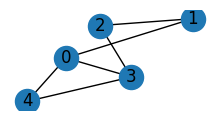

(1, 3)


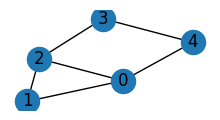

(0, 3)


In [91]:
n=5
trials =2
all_edges = [(i,j) for i in range(n) for j in range(i+1,n)]
cycle_edges = [(i, (i+1)) for i in range(n-1)]+[(0,n-1)]
non_cycle_edges = [edge for edge in all_edges if edge not in cycle_edges]

for trial in range(trials):
    G = nx.complete_graph(n)
    add_weights(G, 'unweighted')
    old_max_eigval = get_maximum_eigval(generate_H_EPR(G))
    np.random.shuffle(non_cycle_edges)
    for edge in non_cycle_edges:
        G.remove_edge(*edge)
        max_eigval = get_maximum_eigval(generate_H_EPR(G))
        if max_eigval > old_max_eigval-1+TOL:
            plt.figure(figsize=(2,1))
            nx.draw(G, with_labels=True)
            plt.show()
            print(edge)
            break
        old_max_eigval = max_eigval

In [90]:
G=nx.Graph()
G.add_nodes_from(range(5))
G.add_edges_from([(0,1),(1,2),(2,3),(3,4),(0,4),(1,3),(0,3)])
add_weights(G, 'unweighted')
H = generate_H_EPR(G)
print(get_maximum_eigval(H))

G=nx.Graph()
G.add_nodes_from(range(5))
G.add_edges_from([(0,1),(1,2),(2,3),(3,4),(0,4),(1,3)])
add_weights(G, 'unweighted')
H = generate_H_EPR(G)
print(get_maximum_eigval(H))

8.79868206912837
7.834820159084552


W+M=7.0, C=4.00, (W+C)/2+M=6.5,  OPT=6.83


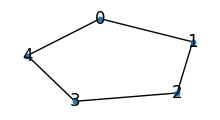

W+M=8.0, C=5.00, (W+C)/2+M=7.5,  OPT=7.83


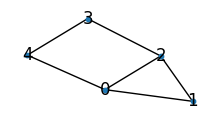

W+M=9.0, C=6.00, (W+C)/2+M=8.5,  OPT=8.89


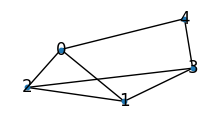

W+M=9.0, C=5.00, (W+C)/2+M=8.0,  OPT=8.80


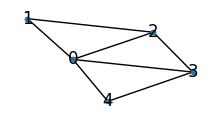

W+M=10.0, C=6.00, (W+C)/2+M=9.0,  OPT=9.90


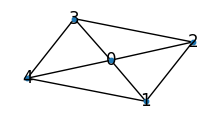

W+M=10.0, C=6.00, (W+C)/2+M=9.0,  OPT=9.87


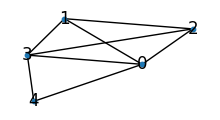

W+M=11.0, C=6.00, (W+C)/2+M=9.5,  OPT=10.94


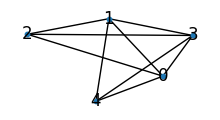

W+M=12.0, C=6.00, (W+C)/2+M=10.0,  OPT=12.00


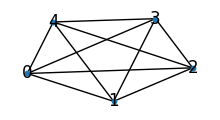

In [ ]:
for G in get_five_node_fc_graphs():
    add_weights(G, 'unweighted')
    
    H = generate_H_EPR(G)
    M = get_maximum_matching(G)
    C = get_maximum_cut(G)
    W = get_weight_sum(G)
    OPT = get_maximum_eigval(H)
    print(f'W+M={W+M}, C={C:.2f}, (W+C)/2+M={(W+C)/2+M},  OPT={OPT:.2f}')
    plt.figure(figsize=(2,1))
    nx.draw(G, with_labels=True, node_size=10)
    plt.show()

<Figure size 300x100 with 0 Axes>

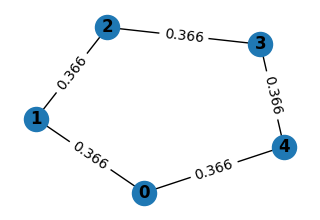

1.83


<Figure size 300x100 with 0 Axes>

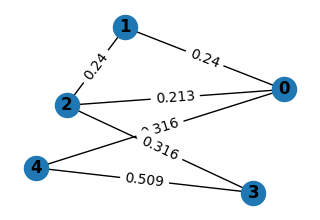

1.834


<Figure size 300x100 with 0 Axes>

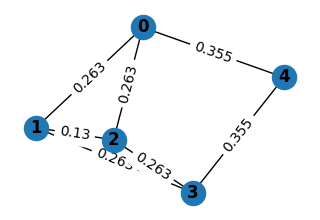

1.892


<Figure size 300x100 with 0 Axes>

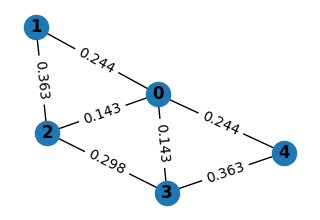

1.798


<Figure size 300x100 with 0 Axes>

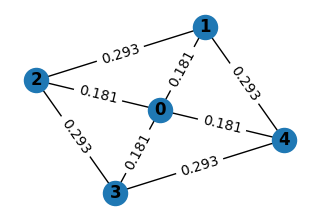

1.8959999999999997


<Figure size 300x100 with 0 Axes>

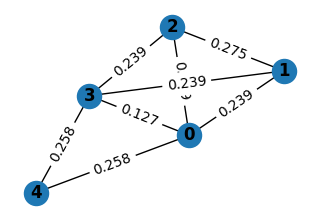

1.8739999999999997


<Figure size 300x100 with 0 Axes>

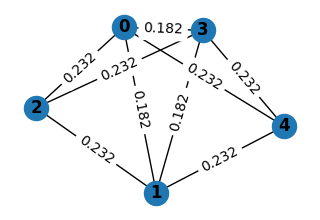

1.938


<Figure size 300x100 with 0 Axes>

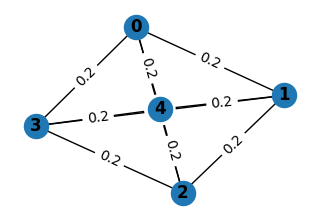

1.9999999999999998


In [39]:
ms, Es = [],[]
for G in get_five_node_fc_graphs():
    add_weights(G, 'unweighted')
    H = generate_H_EPR(G)
    plt.figure(figsize=(3,1))
    eigvals, eigvecs = np.linalg.eigh(H)
    plot_eigvec_energy_on_edges(G, eigvecs[:,np.argmax(eigvals)], ham_type='EPR', e_scale='h')
    #nx.draw(G)
    #plt.show()
    #add_weights(G, 'unweighted')
    #H = generate_H_EPR(G)
    #ms.append(G.number_of_edges())
    #Es.append(get_maximum_eigval(H))

In [515]:
ms, Es = np.array(ms), np.array(Es)

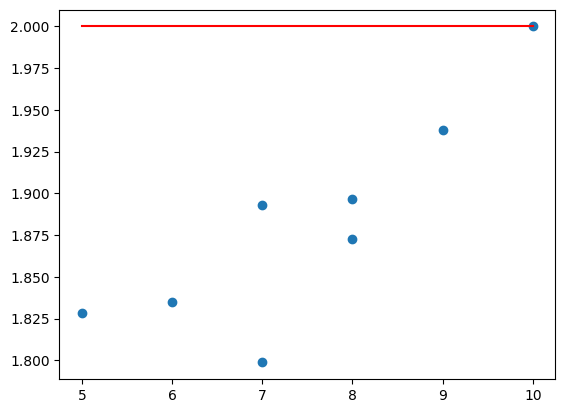

In [516]:
plt.scatter(ms,Es-ms)
plt.plot(ms, 2*np.ones_like(ms), color='red')
plt.show()

spectral gap 2.07


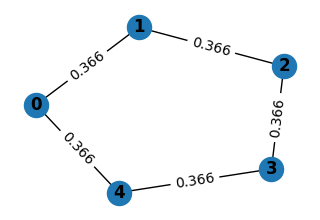

1.83
1.0


In [505]:
G =nx.cycle_graph(5)
n, m = G.number_of_nodes(), G.number_of_edges()
#G.add_edges_from([(0,2),(0,3),(1,4),])
add_weights(G, 'unweighted')
H=generate_H_EPR(G)
eigvals, eigvecs = np.linalg.eigh(H)
#print(np.unique(np.round(eigvals,4), return_counts=True))
print('spectral gap', np.round(get_spectral_gap(H),2))
plot_eigvec_energy_on_edges(G, eigvecs[:,-1], ham_type='EPR', e_scale='h')
print(m/n)

In [468]:
G=nx.complete_graph(7)
add_weights(G, 'unweighted')
print(G.number_of_edges()+get_maximum_matching(G))
H = generate_H_EPR(G)
print(max(np.sum(np.abs(row)) for row in H)) 
H = generate_H_Phi_minus(G)
print(max(np.sum(np.abs(row)) for row in H)) 


24.0
42.0
24.0


In [460]:
G=nx.cycle_graph(7)
n, m = G.number_of_nodes(), G.number_of_edges()
add_weights(G, 'unweighted')
H = generate_H_EPR(G)
get_maximum_eigval(H), m + m/n

(9.627213005296666, 8.0)

In [452]:
all_odd_graphs = [G for G in all_graphs if G.number_of_nodes() % 2 == 1]
odd_graph_idxs = [i for i, G in enumerate(all_graphs) if G.number_of_nodes() % 2 == 1]
odd_ns = ns[odd_graph_idxs]
odd_ms = total_weights[odd_graph_idxs]
odd_es = max_epr_energies[odd_graph_idxs]

np.all(odd_es < odd_ms + odd_ms/odd_ns+TOL)

False

In [454]:
(odd_es - (odd_ms + odd_ms/odd_ns))[:10]

array([3.33333333e-01, 8.88178420e-16, 2.00000000e-01, 9.09275359e-01,
       5.15525234e-01, 6.30816874e-01, 9.03211926e-01, 5.07682673e-01,
       8.00000000e-01, 4.04511577e-01])

In [366]:
SMALL_PATH_NS = [2,4,6,8,10]

In [394]:
small_path_n_idxs = []
for n in SMALL_PATH_NS:
    G = nx.path_graph(n)
    add_weights(G, 'unweighted')
    H = generate_H_EPR(G)
    eigvals, eigvecs = np.linalg.eigh(H)
    #print(np.round(eigvals,4))
    eigvals=np.round(np.sort(eigvals),3)
    large_idxs = np.where(eigvals>3*n/2-2-TOL)[0]
    alpha, beta = 3*n/2-1-np.unique(eigvals)[-1], 3*n/2-1-np.unique(eigvals)[-2]
    print(f'n = {n}, max_eigval = {eigvals[large_idxs]}, alpha = {alpha:.3f}, beta = {beta:.3f}, (1-beta)/(alpha-beta) = {(1-beta)/(alpha-beta):.3f}')
    small_path_n_idxs.append(large_idxs)
    #print(n, np.round(np.unique(eigvals, return_counts=True),4))

n = 2, max_eigval = [2.], alpha = 0.000, beta = 2.000, (1-beta)/(alpha-beta) = 0.500
n = 4, max_eigval = [4.732], alpha = 0.268, beta = 1.586, (1-beta)/(alpha-beta) = 0.445
n = 6, max_eigval = [7.487], alpha = 0.513, beta = 1.496, (1-beta)/(alpha-beta) = 0.505
n = 8, max_eigval = [10.25], alpha = 0.750, beta = 1.536, (1-beta)/(alpha-beta) = 0.682
n = 10, max_eigval = [13.016], alpha = 0.984, beta = 1.639, (1-beta)/(alpha-beta) = 0.976


In [371]:
for n_idx, n in enumerate(SMALL_PATH_NS):
    print(n)
    G = nx.path_graph(n)
    add_weights(G, 'unweighted')
    H = generate_H_EPR(G)
    eigvals, eigvecs = np.linalg.eigh(H)
    for idx in small_path_n_idxs[n_idx][::-1]:
        print(get_state_energy_on_edges(G, eigvecs[:, idx], ham_type='EPR', e_scale='h'))

2
{(0, 1): 1.0}
4
{(0, 1): 0.866, (1, 2): 0.0, (2, 3): 0.866}
6
{(0, 1): 0.835, (1, 2): 0.051, (2, 3): 0.715, (3, 4): 0.051, (4, 5): 0.835}
8
{(0, 1): 0.822, (1, 2): 0.069, (2, 3): 0.675, (3, 4): 0.118, (4, 5): 0.675, (5, 6): 0.069, (6, 7): 0.822}
10
{(0, 1): 0.816, (1, 2): 0.077, (2, 3): 0.657, (3, 4): 0.144, (4, 5): 0.629, (5, 6): 0.144, (6, 7): 0.657, (7, 8): 0.077, (8, 9): 0.816}


In [346]:
# look at eigenspectra of a star
for n in [2,3,4,5,6,7,8]:
    G = nx.star_graph(n)
    add_weights(G, 'unweighted')
    H = generate_H_EPR(G)
    eigvals, eigvecs = np.linalg.eigh(H)
    eigvals = np.round(eigvals,4)
    print(n, np.round(np.unique(eigvals, return_counts=True),2))

2 [[-0.  1.  3.]
 [ 4.  2.  2.]]
3 [[-0.  1.  3.  4.]
 [ 5.  6.  2.  3.]]
4 [[-0.  1.  2.  4.  5.]
 [ 6. 12.  4.  6.  4.]]
5 [[-0.  1.  2.  4.  5.  6.]
 [ 7. 20. 15.  5. 12.  5.]]
6 [[-0.  1.  2.  3.  5.  6.  7.]
 [ 8. 30. 36. 10. 18. 20.  6.]]
7 [[-0.  1.  2.  3.  5.  6.  7.  8.]
 [ 9. 42. 70. 42. 14. 42. 30.  7.]]
8 [[ -0.   1.   2.   3.   4.   6.   7.   8.   9.]
 [ 10.  56. 120. 112.  28.  56.  80.  42.   8.]]


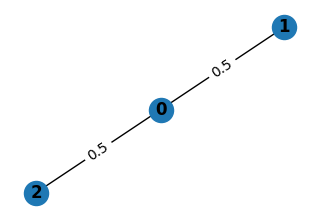

1.0


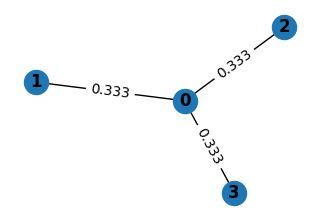

0.9990000000000001


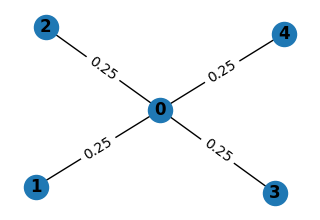

1.0


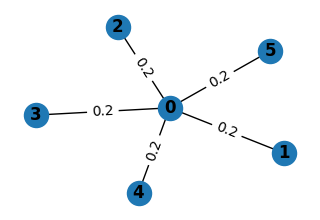

1.0


In [451]:
for n in [2,3,4,5]:
    G=nx.star_graph(n)
    add_weights(G, 'unweighted')
    H = generate_H_EPR(G)
    eigvals, eigvecs = np.linalg.eigh(H)
    max_eigval_idxs = np.where(np.abs(eigvals-max(eigvals))<TOL)[0]
    for idx in max_eigval_idxs[-1:]:
        plot_eigvec_energy_on_edges(G, eigvecs[:,idx], e_scale='h', ham_type='EPR')

In [302]:
def compute_total_slack(G, eigval):
    return G.number_of_nodes()-2*eigval+2*G.number_of_edges()

def get_slack_from_G(G, ham_type='QMC'):
    add_weights(G, 'unweighted')
    if ham_type=='QMC':
        H = generate_H_QMC(G)
    elif ham_type=='EPR':
        H = generate_H_EPR(G)
    else:
        raise ValueError('ham_type must be QMC or EPR')
    eigval = get_maximum_eigval(H)
    slack = compute_total_slack(G, eigval)
    return slack

{0: 0.268, 1: 0.268, 2: 0.268, 3: 0.268, 4: 0.268}


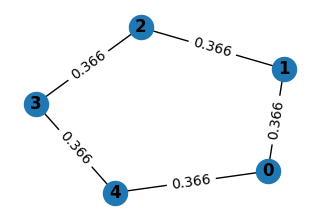

1.83


In [319]:
G=nx.cycle_graph(5)
add_weights(G, 'unweighted')
H = generate_H_EPR(G)
eigvals, eigvecs = np.linalg.eigh(H)
max_eigval_idxs = np.where(np.abs(eigvals-max(eigvals))<TOL)[0]
plot_eigvec_energy_on_edges(G, eigvecs[:,-1], ham_type='EPR', e_scale='h', compute_slack=True)

{0: 0.231, 1: 0.52, 2: 0.231, 3: 0.175, 4: 0.175}


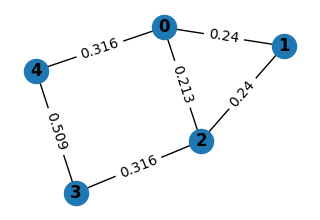

1.834


In [318]:
G=nx.cycle_graph(5)
G.add_edge(0,2)
add_weights(G, 'unweighted')
H = generate_H_EPR(G)
eigvals, eigvecs = np.linalg.eigh(H)
max_eigval_idxs = np.where(np.abs(eigvals-max(eigvals))<TOL)[0]
plot_eigvec_energy_on_edges(G, eigvecs[:,-1], ham_type='EPR', e_scale='h', compute_slack=True)

In [229]:
from scipy.linalg import sqrtm

In [251]:
def dagger(A):
    return A.conj().T

Hd = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
S = np.array([[1,0],[0,1j]])

In [256]:
sqrt_X = sqrtm(X)
sqrt_Y = sqrtm(Y)
sqrt_Z = sqrtm(Z)

np.round(dagger(S) @ Y @ S, 4) - (X)

array([[0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])

In [226]:
n=9
G = nx.cycle_graph(n)
#G.add_edge(0, 2)
add_weights(G, 'unweighted')
H = generate_H_EPR(G)

def get_objective(H):
    def objective(x):
        H_D = np.diag(np.diag(H))
        H_D[0,0]=1
        H_D[-1,-1]=1
        return np.real(np.max([sum(row)for row in np.linalg.inv(H_D)**x@H@H_D**x]))
    return objective

res = minimize(get_objective(H), 1)
res.x, np.round(res.fun,4), get_weight_sum(G)+get_maximum_matching(G)

(array([2.0803161]), 13.2979, 13.0)

In [156]:
n=5
G = nx.complete_graph(n)
G.add_edge(0, 2)
add_weights(G, 'unweighted')
H = generate_H_QMC(G)
print(np.max([np.sum(np.abs(row))for row in H]))
print(np.real(H))
get_maximum_eigval(H)

12.0
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


8.0

In [78]:
def get_complete_G_from_G(G):
    n = G.number_of_nodes()
    complete_G = nx.complete_graph(n)
    add_weights(complete_G, 'zero')
    for edge in G.edges():
        complete_G[edge[0]][edge[1]]['weight'] = 1
    return complete_G



In [85]:
# test if sum h^+ <= (|S|-1)/2 on all complete odd subsets S
def test_h_plus_bound(G, e_scale='h+'):
    complete_G = get_complete_G_from_G(G)
    complete_H = generate_H_EPR(complete_G)
    _, eigvecs = np.linalg.eigh(complete_H)
    h_plusses = [get_state_energy_on_edges(complete_G, eigvec, ham_type='EPR', e_scale=e_scale) for eigvec in eigvecs.T]
    #for h_plus in h_plusses:
    #    print(h_plus)
    n = G.number_of_nodes()
    for k in range(3, n, 2):
        for S in combinations(G.nodes(), k):
            for idx in range(2**n)[::-1]:
                if sum(h_plusses[idx][edge] for edge in combinations(S, 2)) > (k-1)/2+TOL:
                    print(S, idx, h_plusses[idx])
                    return False
    return True

In [87]:
from scipy.optimize import minimize

In [134]:
def get_state_from_coeffs(coeffs):
    state = coeffs[:len(coeffs)//2] + 1j*coeffs[len(coeffs)//2:]
    return state / np.linalg.norm(state)

def objective(coeffs, G, ham_type='EPR', e_scale='h+'):
    state = get_state_from_coeffs(coeffs)
    Es = get_state_energy_on_edges(G, state, ham_type=ham_type, e_scale=e_scale)
    return -sum(Es.values())

n=7
cost_fn = lambda x: objective(x, nx.complete_graph(n), ham_type='EPR', e_scale='h+')   
res = minimize(cost_fn, np.random.rand(2*2**n), method='cobyla')
-res.fun

2.748

In [109]:
G =nx.complete_graph(5)
add_weights(G, 'unweighted')
H = generate_H_EPR(G)
_, eigvecs = np.linalg.eigh(H)
sum(get_state_energy_on_edges(G, eigvecs[:,-1], ham_type='EPR', e_scale='h+').values())

1.9999999999999996

In [69]:
G=nx.cycle_graph(7)
test_h_plus_bound(G)

True

In [86]:
G=nx.cycle_graph(7)
test_h_plus_bound(G, e_scale='g^2/4')

(0, 1, 2) 127 {(0, 1): 0.47265625, (0, 2): 0.126025, (0, 3): 0.15760900000000003, (0, 4): 0.15760900000000003, (0, 5): 0.126025, (0, 6): 0.47265625, (1, 2): 0.47265625, (1, 3): 0.126025, (1, 4): 0.15760900000000003, (1, 5): 0.15760900000000003, (1, 6): 0.126025, (2, 3): 0.47265625, (2, 4): 0.126025, (2, 5): 0.15760900000000003, (2, 6): 0.15760900000000003, (3, 4): 0.47265625, (3, 5): 0.126025, (3, 6): 0.15760900000000003, (4, 5): 0.47265625, (4, 6): 0.126025, (5, 6): 0.47265625}


False

In [75]:
def generate_random_state(n):
    vec = np.random.randn(2 ** n) + 1j * np.random.randn(2 ** n)
    vec /= np.linalg.norm(vec) 
    return vec

def test_h_plus_bound_random_states(n, trials):
    G = nx.complete_graph(n)
    add_weights(G, 'unweighted')
    H = generate_H_EPR(G)
    max_E = 0
    bound =True
    for _ in tqdm(range(trials)):
        state = generate_random_state(n)
        trial_E = sum(get_state_energy_on_edges(G, state, ham_type='EPR', e_scale='h+').values())
        if  trial_E> max_E:
            max_E = trial_E
    return max_E

print(test_h_plus_bound_random_states(5, 10000))
print(test_h_plus_bound_random_states(7, 1000))

100%|██████████| 10000/10000 [00:37<00:00, 269.98it/s]


0.28400000000000003


 25%|██▌       | 254/1000 [00:08<00:23, 31.15it/s]


KeyboardInterrupt: 

[-7.89965629e-16 -4.33526374e-16  3.81966011e-01  3.81966011e-01
  7.72938500e-01  7.72938500e-01  1.10238778e+00  1.10238778e+00
  1.13919415e+00  1.13919415e+00  2.21523682e+00  2.21523682e+00
  2.30169144e+00  2.30169144e+00  2.51091165e+00  2.51091165e+00
  2.61803399e+00  2.61803399e+00  2.74589831e+00  2.74589831e+00
  3.84925607e+00  3.84925607e+00  4.77610586e+00  4.77610586e+00
  5.09920723e+00  5.09920723e+00  5.11490754e+00  5.11490754e+00
  5.53744450e+00  5.53744450e+00  7.83482016e+00  7.83482016e+00]


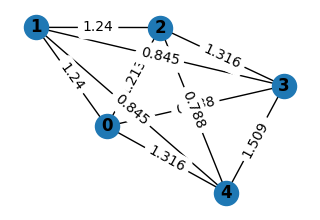

7.834


In [12]:
G=nx.complete_graph(5)
add_weights(G,'zero')
G[0][1]['weight']=1
G[1][2]['weight']=1
G[2][3]['weight']=1
G[3][4]['weight']=1
G[0][4]['weight']=1
G[0][2]['weight']=1
H=generate_H_EPR(G)
eigvals, eigvecs = np.linalg.eigh(H)
print(eigvals)
get_eigvec_energy_on_edges(G, eigvecs[:,-1], ham_type='EPR')

[8.98904334e-17 5.48487806e-16 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 4.00000000e+00 4.00000000e+00]


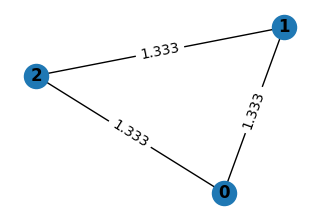

3.9989999999999997


In [158]:
G=nx.complete_graph(3)
add_weights(G, 'unweighted')
H = generate_H_EPR(G)
# print the eigvals
eigvals, eigvecs = np.linalg.eigh(H)
print(eigvals)
get_eigvec_energy_on_edges(G, eigvecs[:,-2], ham_type='EPR')

In [159]:
n=3
G= nx.complete_graph(n)
G.add_edges_from([(0,n),(1,n+1)])
add_weights(G, 'unweighted')
H = generate_H_EPR(G)
get_maximum_eigval(H), n**2/2-1/2+2+2/n



(6.630816873803901, 6.666666666666667)

In [ ]:
def get_powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

# test if opt is submodular

def test_submodularity(G):
    is_submodular=True
    n=G.number_of_nodes()
    m=G.number_of_edges()
    edges = G.edges()
    edge_powerset = get_powerset(edges)
    for edge_subset in edge_powerset:
        G_subset = nx.Graph()
        G_subset.add_nodes_from(range(n))
        G_subset.add_edges_from(edge_subset)
        # list of edges not in subset
        non_edge_subset = list(set(edges)-set(edge_subset))
        # loop through all pairs of edges in non_edge_subset using itertools
        for x_1, x_2 in combinations(non_edge_subset,2):
            G_1, G_2, G_12 = G_subset.copy(), G_subset.copy(), G_subset.copy()
            G_1.add_edge(*x_1)
            G_2.add_edge(*x_2)
            G_12.add_edges_from([x_1,x_2])
            add_weights(G_subset, 'unweighted')
            add_weights(G_1, 'unweighted')
            add_weights(G_2, 'unweighted')
            add_weights(G_12, 'unweighted')
            E_subset, E_1, E_2, E_12 = [get_maximum_eigval(generate_H_EPR(G)) for G in [G_subset, G_1, G_2, G_12]]
            if E_1+E_2 < E_12+E_subset-TOL:
                is_submodular=False
                print(f'failed for {edge_subset} and {x_1} and {x_2}')
                return is_submodular
    return is_submodular


test_submodularity(nx.cycle_graph(5))

In [170]:
# test rotating triangle bounds
G_1 = nx.Graph()
G_1.add_nodes_from(range(5))
G_1.add_edges_from([(0,1),(1,2),(2,0)])
add_weights(G_1, 'unweighted')
a=G_1.number_of_edges()+get_maximum_matching(G_1)
H_1 = generate_H_EPR(G_1)
G_2 = nx.Graph()
G_2.add_nodes_from(range(5))
G_2.add_edges_from([(2,3),(3,4),(4,0)])
add_weights(G_2, 'unweighted')
b=G_2.number_of_edges()+get_maximum_matching(G_2)
H_2 = generate_H_EPR(G_2)
anticommutator = H_1 @ H_2 + H_2 @ H_1
get_maximum_eigval(anticommutator+H_2@H_2), get_maximum_eigval(H_2@H_2)+1+2*a*b-2*a-2*b

(47.40176678344944, 45.392304845413264)

In [81]:
def test_triangle_bounds(G, goal, num_edges=1, energy_fn=generate_H_EPR, plot=False):

    # try removing one edge
    optimal_energies = []
    for edge in G.edges():
        G_minus_edge = G.copy()
        G_minus_edge.remove_edge(*edge)
        H_minus_edge = energy_fn(G_minus_edge)
        optimal_energy = get_maximum_eigval(H_minus_edge)
        optimal_energies.append(optimal_energy)
    optimal_energies = np.array(optimal_energies)
    min_energy, argmin_energy = np.min(optimal_energies), np.argmin(optimal_energies)
    if min_energy+2 <= goal+TOL:
        print(f'1 edge removal triangle bound holds, edge={list(G.edges())[argmin_energy]}, energy on remaining graph={min_energy:2f}')
        G_opt_deleted = G.copy()
        if plot:
            plt.figure(figsize=(3,1.5))
            G_opt_deleted.remove_edge(*list(G.edges())[argmin_energy])
            nx.draw(G_opt_deleted, with_labels=True)
            plt.show()
    else:
        print(f'1 edge removal triangle bound does not hold, min energy={np.min(optimal_energies)+2}')

    # try removing one half_edge
    optimal_energies = []
    for edge in G.edges():
        G_minus_edge = G.copy()
        G_minus_edge[edge[0]][edge[1]]['weight'] = 1/2
        H_minus_edge = energy_fn(G_minus_edge)
        optimal_energy = get_maximum_eigval(H_minus_edge)
        optimal_energies.append(optimal_energy)
    optimal_energies = np.array(optimal_energies)
    min_energy, argmin_energy = np.min(optimal_energies), np.argmin(optimal_energies)
    if min_energy+1 <= goal+TOL:
        print(f'1 half-edge removal triangle bound holds, edge={list(G.edges())[argmin_energy]}, energy on remaining graph={min_energy:2f}')
        G_opt_deleted = G.copy()
        if plot:
            plt.figure(figsize=(3,1.5))
            G_opt_deleted.remove_edge(*list(G.edges())[argmin_energy])
            nx.draw(G_opt_deleted, with_labels=True)
            plt.show()
    else:
        print(f'1 half-edge removal triangle bound does not hold, min energy={np.min(optimal_energies)+1}')
    
    if num_edges >=2:
        # try removing two edges
        deleted_edges = []
        optimal_energies =[]
        g1_energies, g2_energies = [],[]

        for edge_1_idx, edge_1 in enumerate(G.edges()):
            for edge_2_idx in range(edge_1_idx):
                edge_2 = list(G.edges())[edge_2_idx]
                G_minus_edge = G.copy()
                G_minus_edge.remove_edge(*edge_1)
                G_minus_edge.remove_edge(*edge_2)
                H_minus_edge = energy_fn(G_minus_edge)
                optimal_energy = get_maximum_eigval(H_minus_edge)
                g1_energies.append(optimal_energy)
                G_deleted = G.copy()
                add_weights(G_deleted, 'zero')
                G_deleted.add_edges_from([edge_1,edge_2])
                G_deleted[edge_1[0]][edge_1[1]]['weight'] = 1
                G_deleted[edge_2[0]][edge_2[1]]['weight'] = 1
                H_deleted = energy_fn(G_deleted)
                optimal_energy_deleted = get_maximum_eigval(H_deleted)
                g2_energies.append(optimal_energy_deleted)
                deleted_edges.append((edge_1,edge_2))
                optimal_energies.append(optimal_energy+optimal_energy_deleted)
        optimal_energies = np.array(optimal_energies)
        min_energy, argmin_energy = np.min(optimal_energies), np.argmin(optimal_energies)
        if min_energy <= goal+TOL:
            print(f'2 edge removal triangle bound holds, edges={deleted_edges[argmin_energy]}, energy={min_energy:.2f}, g1={g1_energies[argmin_energy]:.2f}, g2={g2_energies[argmin_energy]:.2f}')
            if plot:
                G_opt_deleted = G.copy()
                plt.figure(figsize=(3,1.5))
                G_opt_deleted.remove_edge(*deleted_edges[argmin_energy][0])
                G_opt_deleted.remove_edge(*deleted_edges[argmin_energy][1])
                nx.draw(G_opt_deleted, with_labels=True)
                plt.show()
        else:
            print(f'2 edge removal triangle bound does not hold, min energy={min_energy}')


    if num_edges >=2:
        # try removing two half-edges
        deleted_edges = []
        optimal_energies =[]
        g1_energies, g2_energies = [],[]

        for edge_1_idx, edge_1 in enumerate(G.edges()):
            for edge_2_idx in range(edge_1_idx):
                edge_2 = list(G.edges())[edge_2_idx]
                G_minus_edge = G.copy()
                G_minus_edge[edge_1[0]][edge_1[1]]['weight'] = 1/2
                G_minus_edge[edge_2[0]][edge_2[1]]['weight'] = 1/2
                H_minus_edge = energy_fn(G_minus_edge)
                optimal_energy = get_maximum_eigval(H_minus_edge)
                g1_energies.append(optimal_energy)
                G_deleted = G.copy()
                add_weights(G_deleted, 'zero')
                G_deleted.add_edges_from([edge_1,edge_2])
                G_deleted[edge_1[0]][edge_1[1]]['weight'] = 1/2
                G_deleted[edge_2[0]][edge_2[1]]['weight'] = 1/2
                H_deleted = energy_fn(G_deleted)
                optimal_energy_deleted = get_maximum_eigval(H_deleted)
                g2_energies.append(optimal_energy_deleted)
                deleted_edges.append((edge_1,edge_2))
                optimal_energies.append(optimal_energy+optimal_energy_deleted)
        optimal_energies = np.array(optimal_energies)
        min_energy, argmin_energy = np.min(optimal_energies), np.argmin(optimal_energies)
        if min_energy <= goal+TOL:
            print(f'2 edge half-removal triangle bound holds, edges={deleted_edges[argmin_energy]}, energy={min_energy:.2f}, g1={g1_energies[argmin_energy]:.2f}, g2={g2_energies[argmin_energy]:.2f}')
            G_opt_deleted = G.copy()
            if plot:
                plt.figure(figsize=(3,1.5))
                G_opt_deleted.remove_edge(*deleted_edges[argmin_energy][0])
                G_opt_deleted.remove_edge(*deleted_edges[argmin_energy][1])
                nx.draw(G_opt_deleted, with_labels=True)
                plt.show()
        else:
            print(f'2 edge half-removal triangle bound does not hold, min energy={min_energy}')


    if num_edges >=3:
        # try removing three edges
        optimal_energies =[]
        deleted_edges=[]
    
        for edge_1_idx, edge_1 in enumerate(G.edges()):
            for edge_2_idx in range(edge_1_idx):
                for edge_3_idx in range(edge_2_idx):
                    edge_2 = list(G.edges())[edge_2_idx]
                    edge_3 = list(G.edges())[edge_3_idx]
                    G_minus_edge = G.copy()
                    G_minus_edge.remove_edge(*edge_1)
                    G_minus_edge.remove_edge(*edge_2)
                    G_minus_edge.remove_edge(*edge_3)
                    H_minus_edge = energy_fn(G_minus_edge)
                    optimal_energy = get_maximum_eigval(H_minus_edge)
                    G_deleted = G.copy()
                    add_weights(G_deleted, 'zero')
                    G_deleted.add_edges_from([edge_1,edge_2])
                    G_deleted[edge_1[0]][edge_1[1]]['weight'] = 1
                    G_deleted[edge_2[0]][edge_2[1]]['weight'] = 1
                    G_deleted[edge_3[0]][edge_3[1]]['weight'] = 1
                    H_deleted = energy_fn(G_deleted)
                    optimal_energy_deleted = get_maximum_eigval(H_deleted)
                    deleted_edges.append((edge_1,edge_2))
                    optimal_energies.append(optimal_energy+optimal_energy_deleted)
        optimal_energies = np.array(optimal_energies)
        min_energy, argmin_energy = np.min(optimal_energies), np.argmin(optimal_energies)
        if min_energy <= goal+TOL:
            print(f'3 edge removal triangle bound holds, edges={deleted_edges[argmin_energy]}, energy={min_energy:.2f}')
        else:
            print(f'3 edge removal triangle bound does not hold, min energy={min_energy}')
    

In [82]:
def test_one_half_edge_triangle_bounds(G, goal, num_edges=1, energy_fn=generate_H_EPR, plot=False):

    # try removing one half_edge
    optimal_energies = []
    for edge in G.edges():
        G_minus_edge = G.copy()
        G_minus_edge[edge[0]][edge[1]]['weight'] = 1/2
        H_minus_edge = energy_fn(G_minus_edge)
        optimal_energy = get_maximum_eigval(H_minus_edge)
        optimal_energies.append(optimal_energy)
    optimal_energies = np.array(optimal_energies)
    min_energy, argmin_energy = np.min(optimal_energies), int(np.argmin(optimal_energies))
    return min_energy+1 <= goal+TOL, list(G.edges())[argmin_energy]


def test_two_half_edge_triangle_bounds(G, goal, energy_fn=generate_H_EPR, plot=False):
    deleted_edges = []
    optimal_energies =[]
    g1_energies, g2_energies = [],[]

    for edge_1_idx, edge_1 in enumerate(G.edges()):
        for edge_2_idx in range(edge_1_idx):
            edge_2 = list(G.edges())[edge_2_idx]
            G_minus_edge = G.copy()
            G_minus_edge[edge_1[0]][edge_1[1]]['weight'] = 1/2
            G_minus_edge[edge_2[0]][edge_2[1]]['weight'] = 1/2
            H_minus_edge = energy_fn(G_minus_edge)
            optimal_energy = get_maximum_eigval(H_minus_edge)
            g1_energies.append(optimal_energy)
            G_deleted = G.copy()
            add_weights(G_deleted, 'zero')
            G_deleted.add_edges_from([edge_1,edge_2])
            G_deleted[edge_1[0]][edge_1[1]]['weight'] = 1/2
            G_deleted[edge_2[0]][edge_2[1]]['weight'] = 1/2
            H_deleted = energy_fn(G_deleted)
            optimal_energy_deleted = get_maximum_eigval(H_deleted)
            g2_energies.append(optimal_energy_deleted)
            deleted_edges.append((edge_1,edge_2))
            optimal_energies.append(optimal_energy+optimal_energy_deleted)
    optimal_energies = np.array(optimal_energies)
    min_energy, argmin_energy = np.min(optimal_energies), int(np.argmin(optimal_energies))
    return min_energy <= goal+TOL, deleted_edges[argmin_energy]

In [93]:
energy_fn = generate_H_QMC
G = nx.cycle_graph(5)
G.add_edges_from([(0,2),(1,3),(0,3)])
add_weights(G, 'unweighted')
goal = G.number_of_edges()+get_maximum_matching(G)
test_triangle_bounds(G, goal, num_edges=1, energy_fn=energy_fn, plot=False)

1 edge removal triangle bound holds, edge=(0, 4), energy on remaining graph=7.000000
1 half-edge removal triangle bound holds, edge=(0, 4), energy on remaining graph=7.414214


In [85]:
energy_fn = generate_H_QMC
G = nx.cycle_graph(5)
G.add_edges_from([(0,2),(0,3)])
add_weights(G, 'unweighted')
goal = G.number_of_edges()+get_maximum_matching(G)
test_triangle_bounds(G, goal, num_edges=2, energy_fn=energy_fn, plot=False)
#print('test one half edge', test_one_half_edge_triangle_bounds(G, goal, energy_fn=energy_fn, plot=False))
#print('test two half edge', test_two_half_edge_triangle_bounds(G, goal, energy_fn=energy_fn, plot=False))


1 edge removal triangle bound holds, edge=(2, 3), energy on remaining graph=6.000000
1 half-edge removal triangle bound holds, edge=(2, 3), energy on remaining graph=6.618034
2 edge removal triangle bound holds, edges=((2, 3), (0, 2)), energy=9.00, g1=6.00, g2=3.00
2 edge half-removal triangle bound holds, edges=((2, 3), (1, 2)), energy=7.91, g1=6.41, g2=1.50


In [554]:
G = nx.Graph()
#G.add_edges_from([(0,1),(1,2),(2,3),(3,4),(4,0),(1,4),(1,3),(0,3),(2,4)])
for idx in tqdm(range(100)):
    G = nx.erdos_renyi_graph(7,.5)
    add_weights(G, 'unweighted')
    #G=nx.complete_graph(7)
    #goal=G.number_of_edges()+(G.number_of_nodes()-1)/2
    if np.abs(get_maximum_cut(G) - G.number_of_edges())  > TOL and nx.is_connected(G):
        goal = (G.number_of_edges() + get_maximum_cut(G))/2+get_maximum_matching(G)
        add_weights(G, 'unweighted')
        H = generate_H_QMC(G)
        two_half_edge_bound_true, edges = test_two_half_edge_triangle_bounds(G, goal, num_edges=1, energy_fn=generate_H_QMC, plot=False)
        if not two_half_edge_bound_true:
            plt.figure(figsize=(3,1.2))
            nx.draw(G, with_labels=True)
            plt.show()
    

100%|██████████| 100/100 [03:34<00:00,  2.15s/it]


In [416]:
a=0
triangle_edges = [(0,1,1),(1,2,1),(2,0,1)]
square_edges = [(1,4,1),(4,3,1),(3,2,1),(2,1,1)]
pentagon_edges = [(0,1,1),(1,2,1),(2,3,1),(3,4,1),(4,0,1)]
edges_and_weights_1 =  [(0,1,1),(1,2,1),(2,3,1),(3,4,1),(4,0,1),(1,4,a)]
edges_and_weights_2 = [(1,4,1-a)]
G1=G.copy()
G2=G.copy()
add_weights(G1, 'zero')
add_weights(G2, 'zero')
for edge_and_weight in edges_and_weights_1:
    G1[edge_and_weight[0]][edge_and_weight[1]]['weight'] = edge_and_weight[2]
for edge_and_weight in edges_and_weights_2:
    G2[edge_and_weight[0]][edge_and_weight[1]]['weight'] = edge_and_weight[2]
H1 = generate_H_EPR(G1)
E1 = get_maximum_eigval(H1)
H2 = generate_H_EPR(G2)
E2 = get_maximum_eigval(H2)
print(E1+E2)


8.828427124746192


In [ ]:
# gets 8.1893
edges_and_weights_1 = [(0,1,1),(0,4,1),(1,4,1),(3,4,1/2),(1,2,1/2)]
edges_and_weights_2 = [(3,2,1),(3,4,1/2),(1,2,1/2)] 

best integer valued triangle decomposition value:  8.8(pentagon+line)


EPR on complete graph max eigval vs 2nd max, computed below

n  ---  OPT -  next  -    diff

3 ---  4   ----    1   -----      3

5 ---  12   ---   8    -----     4

7 ---  24   ---   20   ----     4

9 ---  40   ---   36   ----     4

------------------------------------

EPR on cylces max eigval vs second max

n  ---  OPT --  next  -    diff

3 ---  4   -----    1   -------      3

5 ---  6.828  -    4.751    --    2.077

7 ---  9.627   -   8.098   --   1.529

9 ---  12.415      11.212   -   1.203

11 --  15.198      14.210  -    0.988

[-0.     -0.      0.382   0.382   0.7729  0.7729  1.1024  1.1024  1.1392
  1.1392  2.2152  2.2152  2.3017  2.3017  2.5109  2.5109  2.618   2.618
  2.7459  2.7459  3.8493  3.8493  4.7761  4.7761  5.0992  5.0992  5.1149
  5.1149  5.5374  5.5374  7.8348  7.8348]


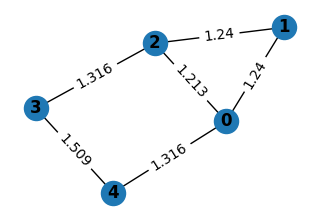

7.834


In [113]:
G = nx.cycle_graph(5)
G.add_edges_from([(0,2)])
add_weights(G, 'unweighted')
H = generate_H_EPR(G)
eigvals, eigvecs = eigh(H)
print(np.round(eigvals,4))
max_eigvec = eigvecs[:,-1]
get_eigvec_energy_on_edges(G, max_eigvec, 'EPR')

In [192]:
G=nx.cycle_graph(3)
#add weight -1 on first edge
G[0][1]['weight']=-1
G[0][2]['weight']=-1
G[1][2]['weight']=1
H = generate_H_EPR(G)
get_maximum_eigval(H)

1.5615528128088303

In [188]:
odd_ns = [3,5,7]
for n in odd_ns:
    G = nx.complete_graph(n)
    add_weights(G, 'unweighted')
    H = generate_H_EPR(G)
    eigvals, eigvecs = eigh(H)
    # print max eigvec
    print(f'{n} node complete graph:')
    print(get_statevector_as_braket( eigvecs[:,-1], n))
    print(get_statevector_as_braket( eigvecs[:,-2], n))
    

3 node complete graph:
['+0.8660|000>', '+0.2887|011>', '+0.2887|101>', '+0.2887|110>']
['+0.2887|001>', '+0.2887|010>', '+0.2887|100>', '+0.8660|111>']
5 node complete graph:
['+0.7906|00000>', '+0.1581|00011>', '+0.1581|00101>', '+0.1581|00110>', '+0.1581|01001>', '+0.1581|01010>', '+0.1581|01100>', '+0.1581|01111>', '+0.1581|10001>', '+0.1581|10010>', '+0.1581|10100>', '+0.1581|10111>', '+0.1581|11000>', '+0.1581|11011>', '+0.1581|11101>', '+0.1581|11110>']
['-0.1581|00001>', '-0.1581|00010>', '-0.1581|00100>', '-0.1581|00111>', '-0.1581|01000>', '-0.1581|01011>', '-0.1581|01101>', '-0.1581|01110>', '-0.1581|10000>', '-0.1581|10011>', '-0.1581|10101>', '-0.1581|10110>', '-0.1581|11001>', '-0.1581|11010>', '-0.1581|11100>', '-0.7906|11111>']
7 node complete graph:
['+0.0507|0000000>', '+0.1054|0000001>', '+0.1054|0000010>', '+0.0072|0000011>', '+0.1054|0000100>', '+0.0072|0000101>', '+0.0072|0000110>', '+0.0632|0000111>', '+0.1054|0001000>', '+0.0072|0001001>', '+0.0072|0001010>', '+

In [201]:
a_vals, b_vals = np.linspace(-1,1,150), np.linspace(-1,1,150)

vals = np.zeros((len(a_vals), len(b_vals)))

for a_idx, a in tqdm(enumerate(a_vals)):
    for b_idx, b in enumerate(np.linspace(-1,a-.1,100)):
        G = nx.path_graph(3)
        G[0][1]['weight'] = a
        G[1][2]['weight'] = b
        H = generate_H_EPR(G)
        max_eigval = get_maximum_eigval(H)

        if max_eigval/(a+b)>2:
            vals[a_idx, b_idx] = 0

        else:
            vals[a_idx, b_idx] = max_eigval/(a+b)



149it [00:06, 20.84it/s]/tmp/ipykernel_491/403032134.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  if max_eigval/(a+b)>2:
150it [00:07, 21.30it/s]


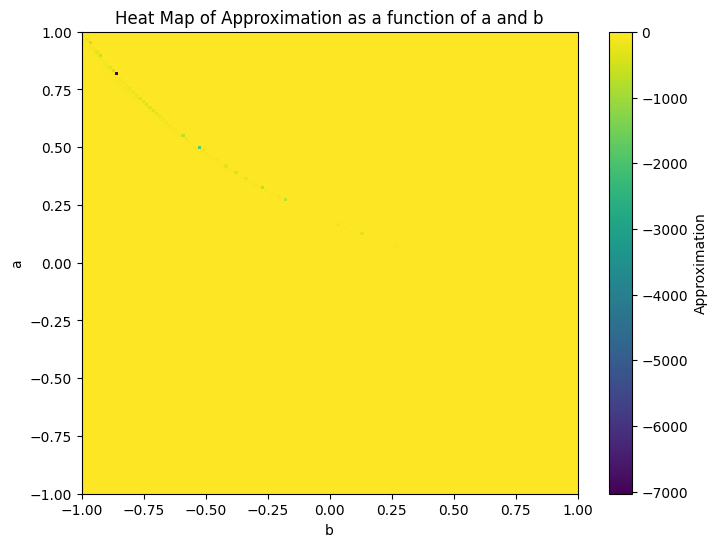

In [202]:
#plot heat map of vals with label
plt.figure(figsize=(8,6))
plt.imshow(vals, extent=[b_vals[0], b_vals[-1], a_vals[0], a_vals[-1]], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Approximation')
plt.xlabel('b')
plt.ylabel('a')
plt.title('Heat Map of Approximation as a function of a and b')
plt.show()

### Eunou Algo

In [25]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit import transpile
from qiskit.quantum_info import Statevector, Operator, Pauli
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()

In [26]:
def op_string(n, op1, op2, loc1, loc2):
    op_str = ['I']*n
    op_str[loc1] = op1
    op_str[loc2] = op2
    op_str = op_str[::-1]
    return ''.join(op_str)

In [27]:
def generate_H_EPR_op(G):
    op_list = []
    for edge in G.edges():
        weight = G[edge[0]][edge[1]]['weight']
        op_list.append((op_string(G.number_of_nodes(), 'I', 'I', edge[0], edge[1]), weight/2))
        op_list.append((op_string(G.number_of_nodes(), 'X', 'X', edge[0], edge[1]), weight/2))
        op_list.append((op_string(G.number_of_nodes(), 'Y', 'Y', edge[0], edge[1]), -weight/2))
        op_list.append((op_string(G.number_of_nodes(), 'Z', 'Z', edge[0], edge[1]), weight/2))
    return  SparsePauliOp.from_list(op_list)

def generate_H_QMC_op(G):
    op_list = []
    for edge in G.edges():
        weight = G[edge[0]][edge[1]]['weight']
        op_list.append((op_string(G.number_of_nodes(), 'I', 'I', edge[0], edge[1]), weight/2))
        op_list.append((op_string(G.number_of_nodes(), 'X', 'X', edge[0], edge[1]), -weight/2))
        op_list.append((op_string(G.number_of_nodes(), 'Y', 'Y', edge[0], edge[1]), -weight/2))
        op_list.append((op_string(G.number_of_nodes(), 'Z', 'Z', edge[0], edge[1]), -weight/2))
    return  SparsePauliOp.from_list(op_list)

In [28]:
def get_QMC_U(theta):
    return UnitaryGate(np.array([[np.cos(theta), np.sin(theta)/np.sqrt(2), -np.sin(theta)/np.sqrt(2), 0], 
                     [np.sin(theta)/np.sqrt(2), np.cos(theta), 0, np.sin(theta)/np.sqrt(2)],
                     [-np.sin(theta)/np.sqrt(2), 0, np.cos(theta), np.sin(theta)/np.sqrt(2)],
                     [0, np.sin(theta)/np.sqrt(2), np.sin(theta)/np.sqrt(2), np.cos(theta)]]))


In [29]:
def get_unitary_from_H(H, theta):
    U = expm(1j * theta * H)
    return UnitaryGate(U)

In [30]:
epr_opt = lambda idx : opt_eprs[idx] * total_weights[idx]
qmc_opt = lambda idx : opt_qmcs[idx] * total_weights[idx]
qmc_match_bound = lambda idx : total_weights[idx] + matches[idx] 
qmc_cutmatch_bound = lambda idx : matches[idx] + (cuts[idx] + total_weights[idx])/2
qmc_bound_tight = lambda idx : min(3 * cuts[idx] - total_weights[idx], matches[idx] + (cuts[idx] + total_weights[idx])/2)
qmc_cutmatch_loose_bound = lambda idx : min(3 * cuts[idx] - total_weights[idx], matches[idx] + total_weights[idx])

In [31]:
def upper_bound_apx_ratio(algo, num_graphs, ham_type='QMC', opt_bound=epr_opt):
    apx_ratio = 1
    worst_idx = 0
    for G_idx in tqdm(range(num_graphs)):
        G = all_graphs[G_idx]
        ALG = algo(G)
        OPT = opt_bound(G_idx)
        ratio = ALG/OPT
        if ratio < apx_ratio:
            apx_ratio = ratio
            worst_idx = G_idx
    return apx_ratio, worst_idx

In [32]:
def eval_eunou_algo_EPR(G, test_op=None):
    n=G.number_of_nodes()
    add_weights(G, 'unweighted')
    qc = QuantumCircuit(n)
    M, max_matching_edges = get_maximum_matching(G, return_edges=True)
    theta = np.arcsin((np.sqrt(5)-1)/2)/2
    H = np.kron(X-Y, X-Y) / 2
    gate = get_unitary_from_H(H, theta)
    for (i,j) in max_matching_edges:
        qc.append(gate, [i, j])
    if test_op!=None:
        job = estimator.run([(qc, test_op)], precision=1e-6)
        result = job.result()
        print(result[0].data.evs.item())
    op = generate_H_EPR_op(G)
    job = estimator.run([(qc, op)], precision=1e-6)
    result = job.result()
    return result[0].data.evs.item()

def eval_eunou_algo_QMC(G, test_op=None):
    n=G.number_of_nodes()
    add_weights(G, 'unweighted')
    qc = QuantumCircuit(n)
    C, partitions = get_maximum_cut_and_edges(G)
    partition = max(partitions, key=len)
    cut_edges = [edge for edge in G.edges() if (edge[0] in partition) + (edge[1] in partition)==1]
    bipartite_G = nx.Graph()
    bipartite_G.add_edges_from(cut_edges)
    add_weights(bipartite_G, 'unweighted')
    _, bipartite_matching_edges = get_maximum_matching(bipartite_G, return_edges=True)
    #print(bipartite_matching_edges)
    #theta = np.arcsin((np.sqrt(5)-1)/2)
    #theta = .62
    #theta = np.pi/4
    theta=.395
    H = np.kron(Y, X) 
    gate = get_unitary_from_H(H, theta)
    for i in partition:
        qc.x(i)
    for (i,j) in bipartite_matching_edges:
        if i in partition:
            qc.append(gate, [i, j])
        else:
            qc.append(gate, [j, i])
    if test_op!=None:
        job = estimator.run([(qc, test_op)], precision=1e-6)
        result = job.result()
        print(result[0].data.evs.item())
    op = generate_H_QMC_op(G)
    job = estimator.run([(qc, op)], precision=1e-6)
    result = job.result()
    return result[0].data.evs.item()

In [82]:
apxs = [eval_eunou_algo_EPR(all_graphs[idx])/max_epr_energies[idx] for idx in range(20000)]

  0%|          | 0/10000 [07:10<?, ?it/s]


In [83]:
worst_idxs = np.where(np.abs(apxs-np.min(apxs))<TOL)[0]

In [84]:
worst_idxs

array([    0,     6,     8,   101,   141,  5570, 12111])

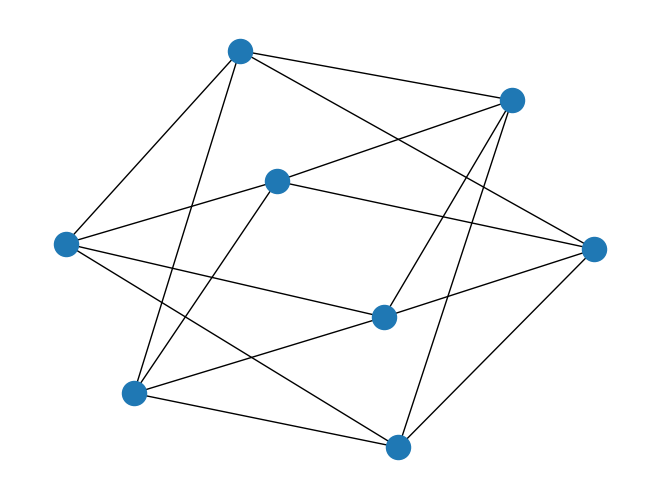

In [93]:
nx.draw(all_graphs[5570])

In [529]:
upper_bound_apx_ratio(eval_eunou_algo_QMC, 1000, ham_type='QMC', opt_bound=qmc_cutmatch_loose_bound)

100%|██████████| 1000/1000 [00:11<00:00, 89.87it/s]


(np.float64(0.6482781992756101), 405)

In [44]:
upper_bound_apx_ratio(eval_eunou_algo_EPR, 100, ham_type='EPR')

100%|██████████| 100/100 [00:00<00:00, 143.14it/s]


(np.float64(0.809016596164551), 0)

In [332]:
upper_bound_apx_ratio(eval_eunou_algo_EPR, 1000, ham_type='EPR')

100%|██████████| 1000/1000 [00:09<00:00, 110.06it/s]


np.float64(0.8090169149734122)

In [197]:
test_op_list = []
test_edge= (0,2)
weight=1
test_op_list.append((op_string(G.number_of_nodes(), 'I', 'I', test_edge[0], test_edge[0]), weight/2))
test_op_list.append((op_string(G.number_of_nodes(), 'X', 'X', test_edge[0], test_edge[1]), weight/2))
test_op_list.append((op_string(G.number_of_nodes(), 'Y', 'Y', test_edge[0], test_edge[1]), -weight/2))
test_op_list.append((op_string(G.number_of_nodes(), 'Z', 'Z', test_edge[0], test_edge[1]), weight/2))
test_op = SparsePauliOp.from_list(test_op_list)

In [55]:
idx=6
G  = all_graphs[idx]
add_weights(G, 'unweighted')
eval_eunou_algo_EPR(G)/(opt_eprs[idx]*total_weights[idx])

np.float64(0.8090170198040508)

In [226]:
idx=1
G  = all_graphs[idx]
add_weights(G, 'unweighted')
eval_eunou_algo_QMC(G)/(opt_eprs[idx]*total_weights[idx])

np.float64(0.5749859791961992)

###  Weighted graphs

In [ ]:
WEIGHTED_NS = np.array([4,6,8,10])
WEIGHTED_TRIALS_BY_N = np.array([10*4**6, 10*2*4**5, 10*2*4**4, 10*4**3])
# if reloading and not much time, uncomment the below
#WEIGHTED_TRIALS_BY_N = np.array([trials//100 for trials in WEIGHTED_TRIALS_BY_N])
print(WEIGHTED_TRIALS_BY_N)

if PRECOMPUTED_WEIGHTED_DATA:
    weighted_max_energies = np.load('data/weighted_max_energies.npy')
    weighted_max_epr_energies = np.load('data/weighted_max_epr_energies.npy')
    weighted_match_energies = np.load('data/weighted_match_energies.npy')
    weighted_cut_energies = np.load('data/weighted_cut_energies.npy')
    weighted_total_weights = np.load('data/weighted_total_weights.npy')

else:
    weighted_max_energies, weighted_max_epr_energies, weighted_match_energies, weighted_cut_energies, weighted_total_weights = [], [], [], [], []
    for N, trials in zip(WEIGHTED_NS, WEIGHTED_TRIALS_BY_N):
        for _ in tqdm(range(trials)):
            G = nx.complete_graph(N)
            add_weights(G, 'uniform')
            total_weight = get_weight_sum(G)
            weighted_total_weights.append(total_weight)
            weighted_max_energies.append(get_maximum_eigval(generate_H_QMC(G)))
            weighted_max_epr_energies.append(get_maximum_eigval(generate_H_EPR(G)))
            weighted_match_energies.append(get_match_energy(G))
            weighted_cut_energies.append(get_cut_energy(G))
            # create a non-trivial Erdos renyi graph
            for trial in range(100):
                G = nx.erdos_renyi_graph(N, np.random.uniform(.1, 1))
                if G.number_of_edges() != 0:
                    break
            add_weights(G, 'uniform')
            total_weight = get_weight_sum(G)
            weighted_total_weights.append(total_weight)
            weighted_max_energies.append(get_maximum_eigval(generate_H_QMC(G)))
            weighted_max_epr_energies.append(get_maximum_eigval(generate_H_EPR(G)))
            weighted_match_energies.append(get_match_energy(G))
            weighted_cut_energies.append(get_cut_energy(G))
            G = nx.complete_graph(N)
            add_weights(G, 'exponential', scale=1)
            total_weight = get_weight_sum(G)
            weighted_total_weights.append(total_weight)
            weighted_max_energies.append(get_maximum_eigval(generate_H_QMC(G)))
            weighted_max_epr_energies.append(get_maximum_eigval(generate_H_EPR(G)))
            weighted_match_energies.append(get_match_energy(G))
            weighted_cut_energies.append(get_cut_energy(G))
            G = nx.complete_graph(N)
            add_weights(G, 'exponential', scale=10)
            total_weight = get_weight_sum(G)
            weighted_total_weights.append(total_weight)
            weighted_max_energies.append(get_maximum_eigval(generate_H_QMC(G)))
            weighted_max_epr_energies.append(get_maximum_eigval(generate_H_EPR(G)))
            weighted_match_energies.append(get_match_energy(G))
            weighted_cut_energies.append(get_cut_energy(G))
    
    weighted_total_weights = np.array(weighted_total_weights)
    weighted_max_energies = np.array(weighted_max_energies)
    weighted_max_epr_energies = np.array(weighted_max_epr_energies)
    weighted_match_energies = np.array(weighted_match_energies)
    weighted_cut_energies = np.array(weighted_cut_energies)
    np.save('data/weighted_total_weights.npy', weighted_total_weights)
    np.save('data/weighted_max_energies.npy', weighted_max_energies)
    np.save('data/weighted_max_epr_energies.npy', weighted_max_epr_energies)
    np.save('data/weighted_match_energies.npy', weighted_match_energies)
    np.save('data/weighted_cut_energies.npy', weighted_cut_energies)

In [314]:
weighted_existence_best_bound = np.min(np.maximum(weighted_match_energies, weighted_cut_energies)/weighted_max_energies)
alg_best_bound = np.min(np.maximum(weighted_match_energies, .956*weighted_cut_energies)/weighted_max_energies)
print(f'ALG\' / OPT best bound {weighted_existence_best_bound:.4f}, ALG / OPT best bound {alg_best_bound:.4f}')

ALG' / OPT best bound 0.7508, ALG / OPT best bound 0.7508


Test Conjecture 1 and 2 for weighted

In [315]:
conj_1_true_qmc, conj_1_true_epr=True, True
for opt, opt_epr, m in zip(weighted_opts, weighted_opt_eprs, weighted_ms):
    if opt >= m+1+TOL:
        conj_1_true_qmc=False
    if opt_epr >= m+1+TOL:
        conj_1_true_epr=False
print(f'Conjecture 1 for QMC is {conj_1_true_qmc}')
print(f'Conjecture 1 for EPR is {conj_1_true_epr}') 
print()


conj_2_true = True
for opt, m, c in zip(weighted_opts, weighted_ms, weighted_cs):
    if c >= 1/2+3*m/2 and opt >= 4*c/3+TOL:
        conj_2_true = False
    if c <= 1/2+3*m/2 and opt >= 2*m+2/3+TOL:
        conj_2_true = False
print(f'conjecture 2 is {conj_2_true}')

Conjecture 1 for QMC is True
Conjecture 1 for EPR is True

conjecture 2 is True
conjecture 3 is True


In [261]:
conj_a_true_qmc, conj_b_true_qmc=True, True
for opt, m, c in zip(weighted_opts,  weighted_ms, weighted_cs):
    if opt >= 1/2+m/2+c+TOL:
        conj_a_true_qmc=False
    if opt >= c+4*m/3+TOL:
        conj_b_true_epr=False
print(f'Conjecture a for QMC is {conj_a_true_qmc}')
print(f'Conjecture b for QMC is {conj_b_true_qmc}') 
print()

Conjecture a for QMC is True
Conjecture b for QMC is True



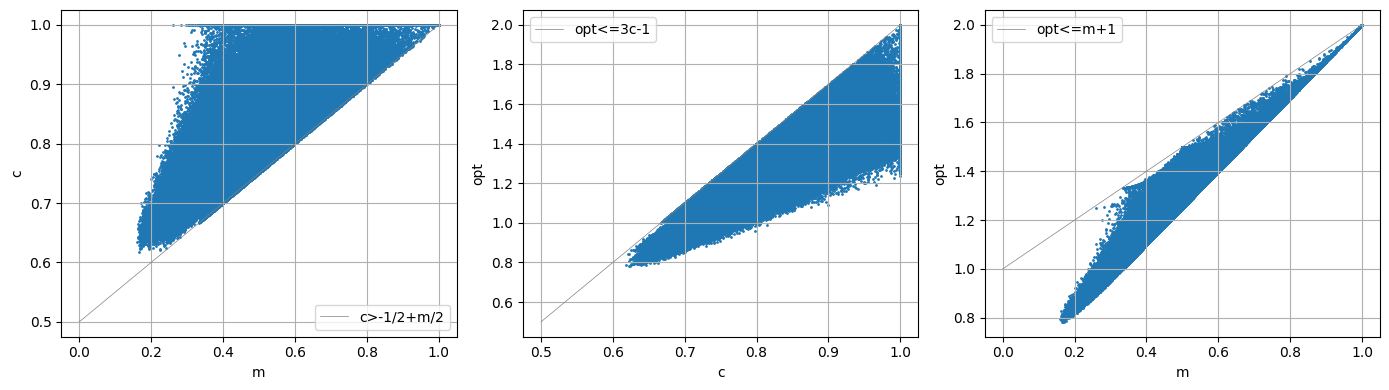

In [318]:
xs_full = np.linspace(0,1,100)
xs_half = np.linspace(.5,1,100)

# visualize cs, ms and opts
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

axs[0].plot(xs_full, 1/2 + xs_full / 2, label='c>-1/2+m/2', linewidth=.5, color='grey')
axs[0].scatter(weighted_ms, weighted_cs, s=1)
axs[0].grid()
axs[0].set_xlabel('m')
axs[0].set_ylabel('c')
axs[0].legend()

axs[1].scatter(weighted_cs, weighted_opts, s=1)
axs[1].plot(xs_half, 3 * xs_half - 1, label='opt<=3c-1', linewidth=.5, color='grey')
axs[1].grid()
axs[1].set_xlabel('c')
axs[1].set_ylabel('opt')
axs[1].legend()

axs[2].plot(xs_full, 1 + xs_full , label='opt<=m+1', linewidth=.5, color='grey')
axs[2].scatter(weighted_ms, weighted_opts, s=1)
axs[2].grid()
axs[2].set_xlabel('m')
axs[2].set_ylabel('opt')
axs[2].legend()

plt.tight_layout()
plt.show()

### Average-Case

Over random unweighted regular graphs

In [310]:
RUN_AVERAGE = False

In [311]:
if RUN_AVERAGE:
    ns_reg = np.arange(4, 11, 1)
    ds_reg = np.arange(2,10,1)
    trials = 10
    max_energies_reg, match_energies_reg, cut_energies_reg = [], [], []
    for n in tqdm(ns_reg):
        n_max_energies_reg, n_match_energies_reg, n_cut_energies_reg = [], [], []
        for d in ds_reg:
            if (n * d) % 2 == 0 and d<n:
                n_d_max_energies_reg, n_d_match_energies_reg, n_d_cut_energies_reg = [], [], []
                for trial in range(trials):
                    G = nx.random_regular_graph(d, n)
                    add_weights(G, 'unweighted')
                    H = generate_H_QMC(G)
                    n_d_max_energies_reg.append(get_maximum_eigval(H))
                    n_d_match_energies_reg.append(get_match_energy(G))
                    n_d_cut_energies_reg.append(get_cut_energy(G))
            n_max_energies_reg.append(n_d_max_energies_reg)
            n_match_energies_reg.append(n_d_match_energies_reg)
            n_cut_energies_reg.append(n_d_cut_energies_reg)
        max_energies_reg.append(n_max_energies_reg)
        match_energies_reg.append(n_match_energies_reg)
        cut_energies_reg.append(n_cut_energies_reg)


In [312]:
if RUN_AVERAGE:
    for n_idx, n in tqdm(enumerate(ns_reg)):
        d_idx =0
        for d in ds_reg:
            if (n * d) % 2 == 0 and d < n:
                print(f'n={n}, d={d}: match avg apx: {np.mean(np.array(match_energies_reg[n_idx][d_idx])/np.array(max_energies_reg[n_idx][d_idx])):.2f}, cut avg apx: {np.mean(np.array(cut_energies_reg[n_idx][d_idx])/np.array(max_energies_reg[n_idx][d_idx])):.2f}, best avg apx: {np.mean(np.maximum(np.array(match_energies_reg[n_idx][d_idx]), np.array(cut_energies_reg[n_idx][d_idx]))/np.array(max_energies_reg[n_idx][d_idx])):.2f}')
                print(f'n={n}, d={d}: match worst apx: {np.min(np.array(match_energies_reg[n_idx][d_idx])/np.array(max_energies_reg[n_idx][d_idx])):.2f}, cut worst apx: {np.min(np.array(cut_energies_reg[n_idx][d_idx])/np.array(max_energies_reg[n_idx][d_idx])):.2f}, best worst apx: {np.min(np.maximum(np.array(match_energies_reg[n_idx][d_idx]), np.array(cut_energies_reg[n_idx][d_idx]))/np.array(max_energies_reg[n_idx][d_idx])):.2f}')
                d_idx += 1

In [313]:
# previous output
'''
n=4, d=2: match avg apx: 0.83, cut avg apx: 0.67, best avg apx: 0.83
n=4, d=2: match worst apx: 0.83, cut worst apx: 0.67, best worst apx: 0.83
n=4, d=3: match avg apx: 1.00, cut avg apx: 0.67, best avg apx: 1.00
n=4, d=3: match worst apx: 1.00, cut worst apx: 0.67, best worst apx: 1.00
n=5, d=2: match avg apx: 0.88, cut avg apx: 0.64, best avg apx: 0.88
n=5, d=2: match worst apx: 0.88, cut worst apx: 0.64, best worst apx: 0.88
n=5, d=4: match avg apx: 0.88, cut avg apx: 0.64, best avg apx: 0.88
n=5, d=4: match worst apx: 0.88, cut worst apx: 0.64, best worst apx: 0.88
n=6, d=2: match avg apx: 0.90, cut avg apx: 0.69, best avg apx: 0.90
n=6, d=2: match worst apx: 0.87, cut worst apx: 0.67, best worst apx: 0.87
n=6, d=3: match avg apx: 0.84, cut avg apx: 0.67, best avg apx: 0.84
n=6, d=3: match worst apx: 0.75, cut worst apx: 0.66, best worst apx: 0.75
n=6, d=4: match avg apx: 0.87, cut avg apx: 0.67, best avg apx: 0.87
n=6, d=4: match worst apx: 0.87, cut worst apx: 0.67, best worst apx: 0.87
n=6, d=5: match avg apx: 1.00, cut avg apx: 0.75, best avg apx: 1.00
n=6, d=5: match worst apx: 1.00, cut worst apx: 0.75, best worst apx: 1.00
n=7, d=2: match avg apx: 0.87, cut avg apx: 0.65, best avg apx: 0.87
n=7, d=2: match worst apx: 0.87, cut worst apx: 0.65, best worst apx: 0.87
n=7, d=4: match avg apx: 0.87, cut avg apx: 0.65, best avg apx: 0.87
n=7, d=4: match worst apx: 0.87, cut worst apx: 0.65, best worst apx: 0.87
n=7, d=6: match avg apx: 0.82, cut avg apx: 0.75, best avg apx: 0.83
n=7, d=6: match worst apx: 0.77, cut worst apx: 0.73, best worst apx: 0.80
n=8, d=2: match avg apx: 0.89, cut avg apx: 0.70, best avg apx: 0.89
n=8, d=2: match worst apx: 0.88, cut worst apx: 0.65, best worst apx: 0.88
n=8, d=3: match avg apx: 0.86, cut avg apx: 0.72, best avg apx: 0.86
n=8, d=3: match worst apx: 0.81, cut worst apx: 0.68, best worst apx: 0.81
n=8, d=4: match avg apx: 0.84, cut avg apx: 0.74, best avg apx: 0.84
n=8, d=4: match worst apx: 0.78, cut worst apx: 0.72, best worst apx: 0.78
n=8, d=5: match avg apx: 0.85, cut avg apx: 0.75, best avg apx: 0.85
n=8, d=5: match worst apx: 0.85, cut worst apx: 0.74, best worst apx: 0.85
n=8, d=6: match avg apx: 0.90, cut avg apx: 0.80, best avg apx: 0.90
n=8, d=6: match worst apx: 0.90, cut worst apx: 0.80, best worst apx: 0.90
n=8, d=7: match avg apx: 1.00, cut avg apx: 0.80, best avg apx: 1.00
n=8, d=7: match worst apx: 1.00, cut worst apx: 0.80, best worst apx: 1.00
n=9, d=2: match avg apx: 0.87, cut avg apx: 0.66, best avg apx: 0.87
n=9, d=2: match worst apx: 0.86, cut worst apx: 0.65, best worst apx: 0.86
n=9, d=4: match avg apx: 0.87, cut avg apx: 0.66, best avg apx: 0.87
n=9, d=4: match worst apx: 0.86, cut worst apx: 0.65, best worst apx: 0.86
n=9, d=6: match avg apx: 0.82, cut avg apx: 0.76, best avg apx: 0.82
n=9, d=6: match worst apx: 0.80, cut worst apx: 0.75, best worst apx: 0.80
n=9, d=8: match avg apx: 0.82, cut avg apx: 0.76, best avg apx: 0.82
n=9, d=8: match worst apx: 0.80, cut worst apx: 0.75, best worst apx: 0.80
n=10, d=2: match avg apx: 0.88, cut avg apx: 0.70, best avg apx: 0.88
n=10, d=2: match worst apx: 0.86, cut worst apx: 0.66, best worst apx: 0.86
n=10, d=3: match avg apx: 0.86, cut avg apx: 0.74, best avg apx: 0.86
n=10, d=3: match worst apx: 0.82, cut worst apx: 0.71, best worst apx: 0.82
n=10, d=4: match avg apx: 0.84, cut avg apx: 0.75, best avg apx: 0.84
n=10, d=4: match worst apx: 0.77, cut worst apx: 0.70, best worst apx: 0.80
n=10, d=5: match avg apx: 0.82, cut avg apx: 0.78, best avg apx: 0.83
n=10, d=5: match worst apx: 0.77, cut worst apx: 0.73, best worst apx: 0.81
n=10, d=6: match avg apx: 0.85, cut avg apx: 0.77, best avg apx: 0.85
n=10, d=6: match worst apx: 0.80, cut worst apx: 0.75, best worst apx: 0.80
n=10, d=7: match avg apx: 0.86, cut avg apx: 0.80, best avg apx: 0.86
n=10, d=7: match worst apx: 0.83, cut worst apx: 0.79, best worst apx: 0.83
n=10, d=8: match avg apx: 0.92, cut avg apx: 0.80, best avg apx: 0.92
n=10, d=8: match worst apx: 0.92, cut worst apx: 0.80, best worst apx: 0.92
n=10, d=9: match avg apx: 1.00, cut avg apx: 0.83, best avg apx: 1.00
n=10, d=9: match worst apx: 1.00, cut worst apx: 0.83, best worst apx: 1.00
'''

'\nn=4, d=2: match avg apx: 0.83, cut avg apx: 0.67, best avg apx: 0.83\nn=4, d=2: match worst apx: 0.83, cut worst apx: 0.67, best worst apx: 0.83\nn=4, d=3: match avg apx: 1.00, cut avg apx: 0.67, best avg apx: 1.00\nn=4, d=3: match worst apx: 1.00, cut worst apx: 0.67, best worst apx: 1.00\nn=5, d=2: match avg apx: 0.88, cut avg apx: 0.64, best avg apx: 0.88\nn=5, d=2: match worst apx: 0.88, cut worst apx: 0.64, best worst apx: 0.88\nn=5, d=4: match avg apx: 0.88, cut avg apx: 0.64, best avg apx: 0.88\nn=5, d=4: match worst apx: 0.88, cut worst apx: 0.64, best worst apx: 0.88\nn=6, d=2: match avg apx: 0.90, cut avg apx: 0.69, best avg apx: 0.90\nn=6, d=2: match worst apx: 0.87, cut worst apx: 0.67, best worst apx: 0.87\nn=6, d=3: match avg apx: 0.84, cut avg apx: 0.67, best avg apx: 0.84\nn=6, d=3: match worst apx: 0.75, cut worst apx: 0.66, best worst apx: 0.75\nn=6, d=4: match avg apx: 0.87, cut avg apx: 0.67, best avg apx: 0.87\nn=6, d=4: match worst apx: 0.87, cut worst apx: 0.6